# Preprocessing Pipelines for All Datasets

## EDOS

In [129]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

def preprocess_and_save_edos(path, binary=True, output_dir="./splits"):
    df = pd.read_csv(path)
    df["clean_text"] = df["text"].str.lower().str.replace(r"[^\w\s]", "", regex=True)

   
    if binary:
        df["label"] = df["label_sexist"].map({"not sexist": 0, "sexist": 1})
    else:
        df["label_category"] = df["label_category"].fillna("none")
        cat_map = {cat: i for i, cat in enumerate(df["label_category"].unique())}
        df["label"] = df["label_category"].map(cat_map)


    train_df, temp_df = train_test_split(
        df, test_size=0.2, stratify=df["label"], random_state=42
    )


    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
    )

    train_df = train_df[["clean_text", "label"]]
    val_df   = val_df[["clean_text", "label"]]
    test_df  = test_df[["clean_text", "label"]]

    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(f"{output_dir}/edos_train.csv", index=False)
    val_df.to_csv(f"{output_dir}/edos_val.csv", index=False)
    test_df.to_csv(f"{output_dir}/edos_test.csv", index=False)

    print("EDOS splits (train/val/test) saved to:", output_dir)
    return train_df, val_df, test_df


## Davidson

In [131]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

def preprocess_and_save_davidson(path, output_dir="./splits"):
    df = pd.read_csv(path)
    df = df.rename(columns={"tweet": "text", "class": "label"})
    df["clean_text"] = df["text"].str.lower().str.replace(r"[^\w\s]", "", regex=True)


    train_df, temp_df = train_test_split(
        df, test_size=0.2, stratify=df["label"], random_state=42
    )

    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
    )


    train_df = train_df[["clean_text", "label"]]
    val_df   = val_df[["clean_text", "label"]]
    test_df  = test_df[["clean_text", "label"]]

    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(f"{output_dir}/davidson_train.csv", index=False)
    val_df.to_csv(f"{output_dir}/davidson_val.csv", index=False)
    test_df.to_csv(f"{output_dir}/davidson_test.csv", index=False)

    print("Davidson splits (train/val/test) saved to:", output_dir)
    return train_df, val_df, test_df


## HateXplain

In [133]:
import json
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split

def extract_text(tokens):
    return " ".join(tokens) if isinstance(tokens, list) else ""

def extract_label(annotators):
    if isinstance(annotators, list) and len(annotators) > 0:
        return annotators[0].get("label", None)
    return None

def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)         
    text = re.sub(r"@\w+", "", text)                  
    text = re.sub(r"[^a-zA-Z\s]", "", text)            
    text = re.sub(r"\s+", " ", text).strip()           
    return text.lower()

def preprocess_and_save_hatexplain_json(json_path, output_dir="./splits"):
    with open(json_path, "r") as f:
        data = json.load(f)

    df_raw = pd.DataFrame.from_dict(data, orient="index")

    df = pd.DataFrame()
    df["text"] = df_raw["post_tokens"].apply(extract_text)
    df["label"] = df_raw["annotators"].apply(extract_label)
    df = df[df["label"].isin(["normal", "offensive", "hatespeech"])].copy()

    df["clean_text"] = df["text"].apply(clean_text)
    label_map = {"normal": 0, "offensive": 1, "hatespeech": 2}
    df["label"] = df["label"].map(label_map)


    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)


    os.makedirs(output_dir, exist_ok=True)
    train_df[["clean_text", "label"]].to_csv(f"{output_dir}/hatexplain_train.csv", index=False)
    val_df[["clean_text", "label"]].to_csv(f"{output_dir}/hatexplain_val.csv", index=False)
    test_df[["clean_text", "label"]].to_csv(f"{output_dir}/hatexplain_test.csv", index=False)

    print("HateXplain 80/10/10 splits saved successfully.")
    return train_df, val_df, test_df


## Function Calls 

In [135]:
edos_path = "/Users/sandyajaleshkumar/Desktop/Practicum/Datasets/EDOS Dataset/edos_labelled_aggregated.csv"
davidson_path = "/Users/sandyajaleshkumar/Desktop/Practicum/Datasets/Davidson Dataset/labeled_data.csv"
hatexplain_path = "/Users/sandyajaleshkumar/Desktop/Practicum/Datasets/HateXplain Dataset/dataset.json"


In [139]:

output_dir = "./splits"


edos_train_df, edos_val_df, edos_test_df = preprocess_and_save_edos(edos_path, binary=True, output_dir=output_dir)
davidson_train_df, davidson_val_df, davidson_test_df = preprocess_and_save_davidson(davidson_path, output_dir=output_dir)
hatexplain_train_df, hatexplain_val_df, hatexplain_test_df = preprocess_and_save_hatexplain_json(hatexplain_path, output_dir=output_dir)


EDOS splits (train/val/test) saved to: ./splits
Davidson splits (train/val/test) saved to: ./splits
HateXplain 80/10/10 splits saved successfully.


# Number of Tokens and Dataset Split 

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer


df = pd.read_csv("./splits/edos_train.csv")  
texts = df["clean_text"].astype(str).tolist()

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

lengths = [len(seq) for seq in sequences]
avg_length = sum(lengths) / len(lengths)
print(f"Average number of tokens per text: {avg_length:.2f}")


Average number of tokens per text: 22.15


In [5]:
import pandas as pd
from transformers import AutoTokenizer

df = pd.read_csv("./splits/edos_train.csv")
texts = df["clean_text"].astype(str).tolist()

char_lens = [len(t) for t in texts]
avg_char_len = sum(char_lens) / len(char_lens)

word_lens = [len(t.split()) for t in texts]
avg_word_len = sum(word_lens) / len(word_lens)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_lens = [len(tokenizer.encode(t, truncation=True, max_length=512)) for t in texts]
avg_bert_len = sum(bert_lens) / len(bert_lens)


print(f"Average # characters: {avg_char_len:.2f}")
print(f"Average # word tokens: {avg_word_len:.2f}")
print(f"Average # BERT tokens: {avg_bert_len:.2f}")


Average # characters: 121.79
Average # word tokens: 23.14
Average # BERT tokens: 28.25


In [7]:
import pandas as pd
from transformers import AutoTokenizer

df = pd.read_csv("./splits/hatexplain_train.csv")
texts = df["clean_text"].astype(str).tolist()

char_lens = [len(t) for t in texts]
avg_char_len = sum(char_lens) / len(char_lens)

word_lens = [len(t.split()) for t in texts]
avg_word_len = sum(word_lens) / len(word_lens)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_lens = [len(tokenizer.encode(t, truncation=True, max_length=512)) for t in texts]
avg_bert_len = sum(bert_lens) / len(bert_lens)

print(f"Average character length: {avg_char_len:.2f}")
print(f"Average word token count: {avg_word_len:.2f}")
print(f"Average BERT token count: {avg_bert_len:.2f}")


Average character length: 125.96
Average word token count: 23.35
Average BERT token count: 28.65


In [12]:
import pandas as pd
from transformers import AutoTokenizer

df = pd.read_csv("./splits/davidson_train.csv")
texts = df["clean_text"].astype(str).tolist()

char_lens = [len(t) for t in texts]
avg_char_len = sum(char_lens) / len(char_lens)

word_lens = [len(t.split()) for t in texts]
avg_word_len = sum(word_lens) / len(word_lens)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_lens = [len(tokenizer.encode(t, truncation=True, max_length=512)) for t in texts]
avg_bert_len = sum(bert_lens) / len(bert_lens)

print(f"Average character length: {avg_char_len:.2f}")
print(f"Average word token count: {avg_word_len:.2f}")
print(f"Average BERT token count: {avg_bert_len:.2f}")


Average character length: 79.36
Average word token count: 14.01
Average BERT token count: 23.91


In [239]:
import pandas as pd

datasets = ["edos", "davidson", "hatexplain"]
splits = ["train", "val", "test"]

for dataset in datasets:
    print(f"\n{dataset.upper()} Dataset Summary")
    
    rows = []
    for split in splits:
        path = f"./splits/{dataset}_{split}.csv"
        df = pd.read_csv(path)
        total_rows = len(df)
        class_counts = df["label"].value_counts().to_dict()
        
        row = {
            "Split": split.capitalize(),
            "Total Rows": total_rows
        }
        for label in sorted(class_counts):
            row[f"Class {label}"] = class_counts[label]
        rows.append(row)
    
    summary_df = pd.DataFrame(rows)
    summary_df = summary_df.fillna(0).astype({"Total Rows": int, **{col: int for col in summary_df.columns if col.startswith("Class")}})
    print(summary_df.to_string(index=False))



EDOS Dataset Summary
Split  Total Rows  Class 0  Class 1
Train       16000    12117     3883
  Val        2000     1514      486
 Test        2000     1515      485

DAVIDSON Dataset Summary
Split  Total Rows  Class 0  Class 1  Class 2
Train       19826     1144    15352     3330
  Val        2478      143     1919      416
 Test        2479      143     1919      417

HATEXPLAIN Dataset Summary
Split  Total Rows  Class 0  Class 1  Class 2
Train       16118     6567     4758     4793
  Val        2015      821      595      599
 Test        2015      821      595      599


# Section A: Shallow (Static) Embeddings: TF-IDF + Classifiers 


## EDOS

In [141]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib, os

edos_train = pd.read_csv("./splits/edos_train.csv")
edos_val   = pd.read_csv("./splits/edos_val.csv")
X_train, y_train = edos_train["clean_text"], edos_train["label"]
X_val, y_val     = edos_val["clean_text"],   edos_val["label"]

os.makedirs("./models", exist_ok=True)

classifiers = {
    "edos_svc": LinearSVC(),
    "edos_lr":  LogisticRegression(max_iter=1000),
    "edos_rf":  RandomForestClassifier(n_estimators=100),
    "edos_xgb": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, clf in classifiers.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000)),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    print(f"\n--- {name.upper()} ---")
    print(classification_report(y_val, y_pred, digits=4))
    joblib.dump(pipe, f"./models/{name}.joblib")



--- EDOS_SVC ---
              precision    recall  f1-score   support

           0     0.8530    0.9392    0.8941      1514
           1     0.7237    0.4959    0.5885       486

    accuracy                         0.8315      2000
   macro avg     0.7884    0.7176    0.7413      2000
weighted avg     0.8216    0.8315    0.8198      2000


--- EDOS_LR ---
              precision    recall  f1-score   support

           0     0.8170    0.9729    0.8882      1514
           1     0.7919    0.3210    0.4568       486

    accuracy                         0.8145      2000
   macro avg     0.8044    0.6470    0.6725      2000
weighted avg     0.8109    0.8145    0.7833      2000


--- EDOS_RF ---
              precision    recall  f1-score   support

           0     0.8248    0.9921    0.9007      1514
           1     0.9330    0.3436    0.5023       486

    accuracy                         0.8345      2000
   macro avg     0.8789    0.6678    0.7015      2000
weighted avg     0.851

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- EDOS_XGB ---
              precision    recall  f1-score   support

           0     0.8393    0.9624    0.8966      1514
           1     0.7841    0.4259    0.5520       486

    accuracy                         0.8320      2000
   macro avg     0.8117    0.6941    0.7243      2000
weighted avg     0.8259    0.8320    0.8129      2000



In [143]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import pandas as pd, joblib, os

edos_train = pd.read_csv("./splits/edos_train.csv")
edos_val   = pd.read_csv("./splits/edos_val.csv")
X_train, y_train = edos_train["clean_text"], edos_train["label"]
X_val, y_val     = edos_val["clean_text"],   edos_val["label"]

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("mlp",   MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

print("\n=== EDOS: TF-IDF + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

os.makedirs("./models", exist_ok=True)
joblib.dump(pipeline, "./models/edos_mlp.joblib")



=== EDOS: TF-IDF + MLP ===
              precision    recall  f1-score   support

           0     0.8410    0.8382    0.8396      1514
           1     0.5010    0.5062    0.5036       486

    accuracy                         0.7575      2000
   macro avg     0.6710    0.6722    0.6716      2000
weighted avg     0.7583    0.7575    0.7579      2000



['./models/edos_mlp.joblib']

## Davidson

In [145]:
davidson_train = pd.read_csv("./splits/davidson_train.csv")
davidson_val   = pd.read_csv("./splits/davidson_val.csv")
X_train, y_train = davidson_train["clean_text"], davidson_train["label"]
X_val, y_val     = davidson_val["clean_text"],   davidson_val["label"]

os.makedirs("./models", exist_ok=True)

classifiers = {
    "davidson_svc": LinearSVC(),
    "davidson_lr":  LogisticRegression(max_iter=1000),
    "davidson_rf":  RandomForestClassifier(n_estimators=100),
    "davidson_xgb": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

for name, clf in classifiers.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000)),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    print(f"\n--- {name.upper()} ---")
    print(classification_report(y_val, y_pred, digits=4))
    joblib.dump(pipe, f"./models/{name}.joblib")



--- DAVIDSON_SVC ---
              precision    recall  f1-score   support

           0     0.6964    0.2727    0.3920       143
           1     0.9123    0.9599    0.9355      1919
           2     0.8189    0.7933    0.8059       416

    accuracy                         0.8923      2478
   macro avg     0.8092    0.6753    0.7111      2478
weighted avg     0.8842    0.8923    0.8824      2478


--- DAVIDSON_LR ---
              precision    recall  f1-score   support

           0     0.8065    0.1748    0.2874       143
           1     0.9041    0.9729    0.9372      1919
           2     0.8508    0.7812    0.8145       416

    accuracy                         0.8947      2478
   macro avg     0.8538    0.6430    0.6797      2478
weighted avg     0.8895    0.8947    0.8791      2478


--- DAVIDSON_RF ---
              precision    recall  f1-score   support

           0     0.8000    0.0839    0.1519       143
           1     0.8749    0.9807    0.9248      1919
           

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:37:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- DAVIDSON_XGB ---
              precision    recall  f1-score   support

           0     0.5500    0.2308    0.3251       143
           1     0.9350    0.9437    0.9393      1919
           2     0.7879    0.9111    0.8450       416

    accuracy                         0.8971      2478
   macro avg     0.7576    0.6952    0.7032      2478
weighted avg     0.8881    0.8971    0.8880      2478



In [147]:
davidson_train = pd.read_csv("./splits/davidson_train.csv")
davidson_val   = pd.read_csv("./splits/davidson_val.csv")
X_train, y_train = davidson_train["clean_text"], davidson_train["label"]
X_val, y_val     = davidson_val["clean_text"],   davidson_val["label"]

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("mlp",   MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

print("\n=== DAVIDSON: TF-IDF + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

os.makedirs("./models", exist_ok=True)
joblib.dump(pipeline, "./models/davidson_mlp.joblib")



=== DAVIDSON: TF-IDF + MLP ===
              precision    recall  f1-score   support

           0     0.4068    0.3357    0.3678       143
           1     0.9119    0.9281    0.9199      1919
           2     0.7862    0.7692    0.7776       416

    accuracy                         0.8672      2478
   macro avg     0.7017    0.6777    0.6885      2478
weighted avg     0.8617    0.8672    0.8642      2478



['./models/davidson_mlp.joblib']

## HateXplain

In [149]:
hatexplain_train = pd.read_csv("./splits/hatexplain_train.csv")
hatexplain_val   = pd.read_csv("./splits/hatexplain_val.csv")
X_train, y_train = hatexplain_train["clean_text"], hatexplain_train["label"]
X_val, y_val     = hatexplain_val["clean_text"],   hatexplain_val["label"]

os.makedirs("./models", exist_ok=True)

classifiers = {
    "hatexplain_svc": LinearSVC(),
    "hatexplain_lr":  LogisticRegression(max_iter=1000),
    "hatexplain_rf":  RandomForestClassifier(n_estimators=100),
    "hatexplain_xgb": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

for name, clf in classifiers.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000)),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    print(f"\n--- {name.upper()} ---")
    print(classification_report(y_val, y_pred, digits=4))
    joblib.dump(pipe, f"./models/{name}.joblib")



--- HATEXPLAIN_SVC ---
              precision    recall  f1-score   support

           0     0.6039    0.6797    0.6395       821
           1     0.4432    0.3933    0.4167       595
           2     0.6341    0.5960    0.6145       599

    accuracy                         0.5702      2015
   macro avg     0.5604    0.5563    0.5569      2015
weighted avg     0.5654    0.5702    0.5663      2015


--- HATEXPLAIN_LR ---
              precision    recall  f1-score   support

           0     0.6034    0.7357    0.6630       821
           1     0.4905    0.3899    0.4345       595
           2     0.6876    0.6210    0.6526       599

    accuracy                         0.5995      2015
   macro avg     0.5938    0.5822    0.5834      2015
weighted avg     0.5951    0.5995    0.5924      2015


--- HATEXPLAIN_RF ---
              precision    recall  f1-score   support

           0     0.5682    0.8319    0.6752       821
           1     0.5617    0.2908    0.3832       595
     

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:39:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- HATEXPLAIN_XGB ---
              precision    recall  f1-score   support

           0     0.6013    0.7881    0.6821       821
           1     0.5034    0.3731    0.4286       595
           2     0.7129    0.5927    0.6472       599

    accuracy                         0.6074      2015
   macro avg     0.6059    0.5846    0.5860      2015
weighted avg     0.6056    0.6074    0.5969      2015



In [106]:
hatexplain_train = pd.read_csv("./splits/hatexplain_train.csv")
hatexplain_val   = pd.read_csv("./splits/hatexplain_val.csv")
X_train, y_train = hatexplain_train["clean_text"], hatexplain_train["label"]
X_val, y_val     = hatexplain_val["clean_text"],   hatexplain_val["label"]

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("mlp",   MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

print("\n=== HATEXPLAIN: TF-IDF + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

os.makedirs("./models", exist_ok=True)
joblib.dump(pipeline, "./models/hatexplain_mlp.joblib")



=== HATEXPLAIN: TF-IDF + MLP ===
              precision    recall  f1-score   support

           0     0.5653    0.5570    0.5611      2463
           1     0.3754    0.3933    0.3841      1785
           2     0.5429    0.5281    0.5354      1797

    accuracy                         0.5001      6045
   macro avg     0.4945    0.4928    0.4936      6045
weighted avg     0.5026    0.5001    0.5012      6045



['./models/hatexplain_mlp.joblib']

# Section B: Shallow (Static) Embeddings: GloVe + Neural Models


## EDOS

In [151]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

MAX_LEN = 100
MAX_WORDS = 10000
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

train_df = pd.read_csv("./splits/edos_train.csv")
val_df = pd.read_csv("./splits/edos_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts_train)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_val   = tokenizer.texts_to_sequences(texts_val)
word_index = tokenizer.word_index

X_train = pad_sequences(sequences_train, maxlen=MAX_LEN)
X_val   = pad_sequences(sequences_val,   maxlen=MAX_LEN)

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# GloVe-Average + MLP
X_train_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_train
])
X_val_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_val
])

mlp = Sequential([
    Dense(128, activation='relu', input_shape=(EMBEDDING_DIM,)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.fit(X_train_avg, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val_avg, y_val), callbacks=[early_stop])
y_pred = (mlp.predict(X_val_avg) > 0.5).astype(int)
print("\n=== EDOS: GloVe-Avg + MLP ===")
print(classification_report(y_val, y_pred))
mlp.save(os.path.join(MODEL_DIR, "edos_glove_mlp.h5"))

# GloVe-Emb + CNN
cnn = Sequential([
    Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_LEN, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val), callbacks=[early_stop])
y_pred = (cnn.predict(X_val) > 0.5).astype(int)
print("\n=== EDOS: GloVe-Emb + CNN ===")
print(classification_report(y_val, y_pred))
cnn.save(os.path.join(MODEL_DIR, "edos_glove_cnn.h5"))

# GloVe-Emb + BiLSTM 
bilstm = Sequential([
    Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
           validation_data=(X_val, y_val), callbacks=[early_stop])
y_pred = (bilstm.predict(X_val) > 0.5).astype(int)
print("\n=== EDOS: GloVe-Emb + BiLSTM ===")
print(classification_report(y_val, y_pred))
bilstm.save(os.path.join(MODEL_DIR, "edos_glove_bilstm.h5"))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - accuracy: 0.7505 - loss: 0.5466 - val_accuracy: 0.7615 - val_loss: 0.5095
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.7538 - loss: 0.5173 - val_accuracy: 0.7605 - val_loss: 0.4971
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.7681 - loss: 0.4914 - val_accuracy: 0.7655 - val_loss: 0.4917
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.7602 - loss: 0.4968 - val_accuracy: 0.7735 - val_loss: 0.4887
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.7663 - loss: 0.4890 - val_accuracy: 0.7675 - val_loss: 0.4854
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.7712 - loss: 0.4847 - val_accuracy: 0.7640 - val_loss: 0.4858
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.7725 - loss: 0.4778 - val_accuracy: 0.7775 - val_loss: 0.4782
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7760 - loss: 0.4738 - 


=== EDOS: GloVe-Avg + MLP ===
              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1514
           1       0.68      0.17      0.27       486

    accuracy                           0.78      2000
   macro avg       0.73      0.57      0.57      2000
weighted avg       0.76      0.78      0.72      2000

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7532 - loss: 0.5534 - val_accuracy: 0.7890 - val_loss: 0.4580
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8016 - loss: 0.4448 - val_accuracy: 0.7740 - val_loss: 0.4742
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8307 - loss: 0.3861 - val_accuracy: 0.8130 - val_loss: 0.4229
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8532 - loss: 0.3359 - val_accuracy: 0.8180 - val_loss: 0.4853
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8733 - loss: 0.2942 - val_accuracy: 0.8170 - val_loss: 0.4835
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8952 - loss: 0.2455 - val_accuracy: 0.8180 - val_loss: 0.5359
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== EDOS: GloVe-Emb + CNN ===


              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1514
           1       0.66      0.49      0.56       486

    accuracy                           0.81      2000
   macro avg       0.75      0.70      0.72      2000
weighted avg       0.80      0.81      0.80      2000

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.7525 - loss: 0.5556 - val_accuracy: 0.7610 - val_loss: 0.4931
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7908 - loss: 0.4636 - val_accuracy: 0.8210 - val_loss: 0.4211
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8248 - loss: 0.4158 - val_accuracy: 0.8235 - val_loss: 0.4069
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.8402 - loss: 0.3859 - val_accuracy: 0.8290 - val_loss: 0.4022
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.8351 - loss: 0.3893 - val_accuracy: 0.8265 - val_loss: 0.4070
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.8491 - loss: 0.3670 - val_accuracy: 0.8245 - val_loss: 0.4139
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.8508 - loss: 0.3571 - val_accuracy: 0.8310 - val_loss: 0.4093
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step



=== EDOS: GloVe-Emb + BiLSTM ===
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1514
           1       0.71      0.50      0.58       486

    accuracy                           0.83      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.82      0.83      0.82      2000



## DAVIDSON

In [153]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

MAX_LEN = 100
MAX_WORDS = 10000
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

train_df = pd.read_csv("./splits/davidson_train.csv")
val_df   = pd.read_csv("./splits/davidson_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts_train)
X_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=MAX_LEN)
X_val   = pad_sequences(tokenizer.texts_to_sequences(texts_val),   maxlen=MAX_LEN)
word_index = tokenizer.word_index

y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat   = to_categorical(y_val, num_classes=3)

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# GloVe-Average + MLP
X_train_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_train
])
X_val_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_val
])

mlp = Sequential([
    Dense(128, activation='relu', input_shape=(EMBEDDING_DIM,)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.fit(X_train_avg, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val_avg, y_val_cat), callbacks=[early_stop])

y_pred = np.argmax(mlp.predict(X_val_avg), axis=1)
print("\n=== DAVIDSON: GloVe-Avg + MLP ===")
print(classification_report(y_val, y_pred))
mlp.save(os.path.join(MODEL_DIR, "davidson_glove_mlp.h5"))

# GloVe-Emb + CNN
cnn = Sequential([
    Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_LEN, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(X_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val_cat), callbacks=[early_stop])
y_pred = np.argmax(cnn.predict(X_val), axis=1)
print("\n=== DAVIDSON: GloVe-Emb + CNN ===")
print(classification_report(y_val, y_pred))
cnn.save(os.path.join(MODEL_DIR, "davidson_glove_cnn.h5"))

# GloVe-Emb + BiLSTM 
bilstm = Sequential([
    Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm.fit(X_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE,
           validation_data=(X_val, y_val_cat), callbacks=[early_stop])
y_pred = np.argmax(bilstm.predict(X_val), axis=1)
print("\n=== DAVIDSON: GloVe-Emb + BiLSTM ===")
print(classification_report(y_val, y_pred))
bilstm.save(os.path.join(MODEL_DIR, "davidson_glove_bilstm.h5"))


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.7892 - loss: 0.5729 - val_accuracy: 0.8442 - val_loss: 0.4345
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.8336 - loss: 0.4465 - val_accuracy: 0.8483 - val_loss: 0.4133
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.8534 - loss: 0.4044 - val_accuracy: 0.8483 - val_loss: 0.4044
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.8536 - loss: 0.3993 - val_accuracy: 0.8483 - val_loss: 0.4021
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.8544 - loss: 0.3852 - val_accuracy: 0.8584 - val_loss: 0.3976
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.8577 - loss: 0.3851 - val_accuracy: 0.8575 - val_loss: 0.3934
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.8637 - loss: 0.3764 - val_accuracy: 0.8458 - val_loss: 0.4002
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.8638 - loss: 0.3703 - val_accurac


=== DAVIDSON: GloVe-Avg + MLP ===
              precision    recall  f1-score   support

           0       0.62      0.10      0.18       143
           1       0.88      0.96      0.92      1919
           2       0.75      0.66      0.70       416

    accuracy                           0.86      2478
   macro avg       0.75      0.57      0.60      2478
weighted avg       0.84      0.86      0.84      2478

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8176 - loss: 0.5289 - val_accuracy: 0.8769 - val_loss: 0.3334
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8766 - loss: 0.3256 - val_accuracy: 0.8781 - val_loss: 0.3208
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8950 - loss: 0.2746 - val_accuracy: 0.8834 - val_loss: 0.3181
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9115 - loss: 0.2331 - val_accuracy: 0.8785 - val_loss: 0.3305
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9224 - loss: 0.1983 - val_accuracy: 0.8810 - val_loss: 0.3908
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9324 - loss: 0.1703 - val_accuracy: 0.8697 - val_loss: 0.4142
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



=== DAVIDSON: GloVe-Emb + CNN ===
              precision    recall  f1-score   support

           0       0.58      0.08      0.14       143
           1       0.90      0.97      0.93      1919
           2       0.82      0.78      0.80       416

    accuracy                           0.88      2478
   macro avg       0.77      0.61      0.62      2478
weighted avg       0.87      0.88      0.86      2478

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.8034 - loss: 0.5315 - val_accuracy: 0.8652 - val_loss: 0.3634
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8738 - loss: 0.3384 - val_accuracy: 0.8765 - val_loss: 0.3250
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8851 - loss: 0.3122 - val_accuracy: 0.8777 - val_loss: 0.3164
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8928 - loss: 0.2912 - val_accuracy: 0.8814 - val_loss: 0.3157
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8967 - loss: 0.2774 - val_accuracy: 0.8842 - val_loss: 0.3037
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9021 - loss: 0.2618 - val_accuracy: 0.8838 - val_loss: 0.3058
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9051 - loss: 0.2650 - val_accuracy: 0.8818 - val_loss: 0.3148
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9065 - loss: 0.2477 - val_accurac


=== DAVIDSON: GloVe-Emb + BiLSTM ===
              precision    recall  f1-score   support

           0       0.61      0.21      0.31       143
           1       0.92      0.95      0.93      1919
           2       0.77      0.83      0.80       416

    accuracy                           0.88      2478
   macro avg       0.77      0.66      0.68      2478
weighted avg       0.87      0.88      0.87      2478



## HateXplain

In [155]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

MAX_LEN = 100
MAX_WORDS = 10000
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

train_df = pd.read_csv("./splits/hatexplain_train.csv")
val_df   = pd.read_csv("./splits/hatexplain_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts_train)
X_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=MAX_LEN)
X_val   = pad_sequences(tokenizer.texts_to_sequences(texts_val), maxlen=MAX_LEN)
word_index = tokenizer.word_index

y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat   = to_categorical(y_val, num_classes=3)

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# GloVe-Average + MLP 
X_train_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_train
])
X_val_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_val
])

mlp = Sequential([
    Dense(128, activation='relu', input_shape=(EMBEDDING_DIM,)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.fit(X_train_avg, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val_avg, y_val_cat), callbacks=[early_stop])

y_pred = np.argmax(mlp.predict(X_val_avg), axis=1)
print("\n=== HATEXPLAIN: GloVe-Avg + MLP ===")
print(classification_report(y_val, y_pred))
mlp.save(os.path.join(MODEL_DIR, "hatexplain_glove_mlp.h5"))

# GloVe-Emb + CNN 
cnn = Sequential([
    Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_LEN, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(X_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val_cat), callbacks=[early_stop])
y_pred = np.argmax(cnn.predict(X_val), axis=1)
print("\n=== HATEXPLAIN: GloVe-Emb + CNN ===")
print(classification_report(y_val, y_pred))
cnn.save(os.path.join(MODEL_DIR, "hatexplain_glove_cnn.h5"))

# GloVe-Emb + BiLSTM 
bilstm = Sequential([
    Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm.fit(X_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE,
           validation_data=(X_val, y_val_cat), callbacks=[early_stop])
y_pred = np.argmax(bilstm.predict(X_val), axis=1)
print("\n=== HATEXPLAIN: GloVe-Emb + BiLSTM ===")
print(classification_report(y_val, y_pred))
bilstm.save(os.path.join(MODEL_DIR, "hatexplain_glove_bilstm.h5"))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.4408 - loss: 1.0601 - val_accuracy: 0.4928 - val_loss: 1.0018
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5152 - loss: 0.9880 - val_accuracy: 0.5092 - val_loss: 0.9900
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5305 - loss: 0.9716 - val_accuracy: 0.5112 - val_loss: 0.9772
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5381 - loss: 0.9623 - val_accuracy: 0.5042 - val_loss: 0.9859
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.5418 - loss: 0.9507 - val_accuracy: 0.5127 - val_loss: 0.9719
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5489 - loss: 0.9442 - val_accuracy: 0.5246 - val_loss: 0.9760
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5416 - loss: 0.9529 - val_accuracy: 0.5156 - val_loss: 0.9721
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5526 - loss: 0.9407 - 


=== HATEXPLAIN: GloVe-Avg + MLP ===
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       821
           1       0.43      0.33      0.37       595
           2       0.56      0.53      0.55       599

    accuracy                           0.54      2015
   macro avg       0.52      0.52      0.51      2015
weighted avg       0.53      0.54      0.53      2015

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4500 - loss: 1.0659 - val_accuracy: 0.5395 - val_loss: 0.9498
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5645 - loss: 0.9220 - val_accuracy: 0.5782 - val_loss: 0.9105
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6047 - loss: 0.8613 - val_accuracy: 0.5846 - val_loss: 0.8960
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6357 - loss: 0.8110 - val_accuracy: 0.5916 - val_loss: 0.8996
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6712 - loss: 0.7458 - val_accuracy: 0.5831 - val_loss: 0.9184
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7008 - loss: 0.6835 - val_accuracy: 0.5821 - val_loss: 0.9553
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



=== HATEXPLAIN: GloVe-Emb + CNN ===
              precision    recall  f1-score   support

           0       0.57      0.82      0.67       821
           1       0.56      0.24      0.33       595
           2       0.63      0.61      0.62       599

    accuracy                           0.58      2015
   macro avg       0.59      0.55      0.54      2015
weighted avg       0.58      0.58      0.56      2015

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


504/504 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.4522 - loss: 1.0493 - val_accuracy: 0.5489 - val_loss: 0.9419
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.5578 - loss: 0.9233 - val_accuracy: 0.5747 - val_loss: 0.9115
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.5916 - loss: 0.8949 - val_accuracy: 0.5846 - val_loss: 0.8944
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.6138 - loss: 0.8602 - val_accuracy: 0.5931 - val_loss: 0.8841
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.6226 - loss: 0.8432 - val_accuracy: 0.5975 - val_loss: 0.8869
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6181 - loss: 0.8411 - val_accuracy: 0.6040 - val_loss: 0.8705
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.6308 - loss: 0.8179 - val_accuracy: 0.6005 - val_loss: 0.8795
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6546 - loss: 0.7888 - val_accurac


=== HATEXPLAIN: GloVe-Emb + BiLSTM ===
              precision    recall  f1-score   support

           0       0.62      0.76      0.68       821
           1       0.49      0.37      0.42       595
           2       0.68      0.64      0.66       599

    accuracy                           0.61      2015
   macro avg       0.60      0.59      0.59      2015
weighted avg       0.60      0.61      0.60      2015



# Section C: Contextual Embeddings: Transformers + Neural Models

## EDOS

### BERT-Embed + MLP

In [159]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import joblib
from tqdm import tqdm

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
EMBEDDING_DIM = 768
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
val_df   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = train_df["label"].astype(int).tolist()
y_val       = val_df["label"].astype(int).tolist()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state
            mean_vec = last_hidden.mean(dim=1).squeeze().cpu().numpy()
            all_embeddings.append(mean_vec)
    return np.array(all_embeddings)

X_train = get_bert_embeddings(texts_train, tokenizer, model)
X_val   = get_bert_embeddings(texts_val, tokenizer, model)

clf = MLPClassifier(
    hidden_layer_sizes=(128,),
    max_iter=1,
    warm_start=True,
    random_state=42
)

best_score = 0
patience = 3
wait = 0

print("\nTraining MLP with manual early stopping...")

for epoch in range(50):  
    clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    print(f"Epoch {epoch+1} - Val Accuracy: {score:.4f}")
    
    if score > best_score:
        best_score = score
        wait = 0
        joblib.dump(clf, os.path.join(SAVE_PATH, "edos_bert_mlp.joblib"))
        print("Model improved and saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

clf = joblib.load(os.path.join(SAVE_PATH, "edos_bert_mlp.joblib"))
y_pred = clf.predict(X_val)
print("\n=== EDOS: BERT-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))


Extracting BERT embeddings: 100%|███████████| 2000/2000 [02:26<00:00, 13.64it/s]



Training MLP with manual early stopping...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1 - Val Accuracy: 0.8000
Model improved and saved.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2 - Val Accuracy: 0.8050
Model improved and saved.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 3 - Val Accuracy: 0.8045
Epoch 4 - Val Accuracy: 0.8040


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 5 - Val Accuracy: 0.8095
Model improved and saved.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 6 - Val Accuracy: 0.8090


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 7 - Val Accuracy: 0.8110
Model improved and saved.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 8 - Val Accuracy: 0.8080


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 9 - Val Accuracy: 0.8115
Model improved and saved.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 10 - Val Accuracy: 0.8145
Model improved and saved.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 11 - Val Accuracy: 0.8115
Epoch 12 - Val Accuracy: 0.8140
Epoch 13 - Val Accuracy: 0.8110
Early stopping triggered.

=== EDOS: BERT-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.8483    0.9194    0.8824      1514
           1     0.6602    0.4877    0.5609       486

    accuracy                         0.8145      2000
   macro avg     0.7542    0.7035    0.7217      2000
weighted avg     0.8026    0.8145    0.8043      2000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


### BERT-Embed + BiLSTM 

In [161]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
BATCH_SIZE = 32
EPOCHS = 20
os.makedirs(SAVE_PATH, exist_ok=True)

df_train = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
df_val   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")
texts_train = df_train["clean_text"].astype(str).tolist()
texts_val   = df_val["clean_text"].astype(str).tolist()
y_train     = df_train["label"].astype(int).to_numpy()
y_val       = df_val["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_bert_sequence_embeddings(texts_train, tokenizer, model)
X_val   = get_bert_sequence_embeddings(texts_val, tokenizer, model)

bilstm_model = Sequential([
    Bidirectional(LSTM(64), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
bilstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=2
)

y_pred = (bilstm_model.predict(X_val) > 0.5).astype(int).reshape(-1)
print("\n=== EDOS: BERT-Embed + BiLSTM ===")
print(classification_report(y_val, y_pred, digits=4))

bilstm_model.save(os.path.join(SAVE_PATH, "edos_bert_bilstm.h5"))
print("Model saved as: edos_bert_bilstm.h5")


Extracting BERT sequence embeddings: 100%|█| 16000/16000 [20:16<00:00, 13.15it/s
Extracting BERT sequence embeddings: 100%|██| 2000/2000 [01:36<00:00, 20.71it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
500/500 - 45s - 90ms/step - accuracy: 0.7747 - loss: 0.4805 - val_accuracy: 0.8115 - val_loss: 0.4174
Epoch 2/20
500/500 - 50s - 100ms/step - accuracy: 0.8141 - loss: 0.4112 - val_accuracy: 0.8245 - val_loss: 0.3860
Epoch 3/20
500/500 - 52s - 104ms/step - accuracy: 0.8434 - loss: 0.3609 - val_accuracy: 0.8380 - val_loss: 0.3542
Epoch 4/20
500/500 - 42s - 83ms/step - accuracy: 0.8651 - loss: 0.3155 - val_accuracy: 0.8360 - val_loss: 0.3592
Epoch 5/20
500/500 - 41s - 83ms/step - accuracy: 0.8882 - loss: 0.2726 - val_accuracy: 0.8490 - val_loss: 0.3550
Epoch 6/20
500/500 - 35s - 70ms/step - accuracy: 0.9078 - loss: 0.2247 - val_accuracy: 0.8285 - val_loss: 0.3990
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

=== EDOS: BERT-Embed + BiLSTM ===


              precision    recall  f1-score   support

           0     0.8597    0.9392    0.8977      1514
           1     0.7341    0.5226    0.6106       486

    accuracy                         0.8380      2000
   macro avg     0.7969    0.7309    0.7542      2000
weighted avg     0.8292    0.8380    0.8279      2000

Model saved as: edos_bert_bilstm.h5


###  BERT-Embed + XGBoost

In [162]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import joblib
import xgboost as xgb
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

df_train = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
df_val   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")
texts_train = df_train["clean_text"].astype(str).tolist()
texts_val   = df_val["clean_text"].astype(str).tolist()
y_train     = df_train["label"].astype(int).to_numpy()
y_val       = df_val["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            all_embeddings.append(mean_vec)
    return np.array(all_embeddings)

X_train = get_bert_embeddings(texts_train, tokenizer, model)
X_val   = get_bert_embeddings(texts_val, tokenizer, model)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)

print("\n=== EDOS: BERT-Embed + XGBoost ===")
print(classification_report(y_val, y_pred, digits=4))

model_name = "edos_bert_xgb.joblib"
joblib.dump(xgb_model, os.path.join(SAVE_PATH, model_name))
print(f"Model saved as: {model_name}")


Extracting BERT embeddings: 100%|███████████| 2000/2000 [02:37<00:00, 12.69it/s]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== EDOS: BERT-Embed + XGBoost ===
              precision    recall  f1-score   support

           0     0.8195    0.9267    0.8698      1514
           1     0.6146    0.3642    0.4574       486

    accuracy                         0.7900      2000
   macro avg     0.7170    0.6454    0.6636      2000
weighted avg     0.7697    0.7900    0.7696      2000

Model saved as: edos_bert_xgb.joblib


### BERT-Embed + CNN

In [163]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
BATCH_SIZE = 32
EPOCHS = 10
os.makedirs(SAVE_PATH, exist_ok=True)

df_train = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
df_val   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")
texts_train = df_train["clean_text"].astype(str).tolist()
texts_val   = df_val["clean_text"].astype(str).tolist()
y_train     = df_train["label"].astype(int).to_numpy()
y_val       = df_val["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # (max_len, hidden)
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_bert_sequence_embeddings(texts_train, tokenizer, model)
X_val   = get_bert_sequence_embeddings(texts_val, tokenizer, model)

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

y_pred = (cnn_model.predict(X_val) > 0.5).astype(int).reshape(-1)
print("\n=== EDOS: BERT-Embed + CNN ===")
print(classification_report(y_val, y_pred, digits=4))

cnn_model.save(os.path.join(SAVE_PATH, "edos_bert_cnn.h5"))
print("Model saved as: edos_bert_cnn.h5")


Extracting BERT sequence embeddings: 100%|█| 16000/16000 [23:15<00:00, 11.47it/s
Extracting BERT sequence embeddings: 100%|██| 2000/2000 [02:14<00:00, 14.90it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 99ms/step - accuracy: 0.7364 - loss: 0.6144 - val_accuracy: 0.8255 - val_loss: 0.4049
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.8274 - loss: 0.3999 - val_accuracy: 0.8385 - val_loss: 0.3685
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 153ms/step - accuracy: 0.8463 - loss: 0.3673 - val_accuracy: 0.8465 - val_loss: 0.3515
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.8622 - loss: 0.3268 - val_accuracy: 0.8440 - val_loss: 0.3504
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.8739 - loss: 0.3016 - val_accuracy: 0.8580 - val_loss: 0.3469
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.8856 - loss: 0.2715 - val_accuracy: 0.8495 - val_loss: 0.3493
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9064 - loss: 0.2420 - val_accuracy: 0.8450 - val_loss: 0.3833
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

=== EDOS: BERT-Embed + CNN ===


              precision    recall  f1-score   support

           0     0.8863    0.9320    0.9086      1514
           1     0.7475    0.6276    0.6823       486

    accuracy                         0.8580      2000
   macro avg     0.8169    0.7798    0.7954      2000
weighted avg     0.8526    0.8580    0.8536      2000

Model saved as: edos_bert_cnn.h5


### ALBERT-Embed + MLP

In [166]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import joblib
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
EMBEDDING_DIM = 768 
os.makedirs(SAVE_PATH, exist_ok=True)

df_train = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
df_val   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")
texts_train = df_train["clean_text"].astype(str).tolist()
texts_val   = df_val["clean_text"].astype(str).tolist()
y_train     = df_train["label"].astype(int).to_numpy()
y_val       = df_val["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_albert_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state
            mean_vec = last_hidden.mean(dim=1).squeeze().cpu().numpy()
            all_embeddings.append(mean_vec)
    return np.array(all_embeddings)

X_train = get_albert_embeddings(texts_train, tokenizer, model)
X_val   = get_albert_embeddings(texts_val, tokenizer, model)

mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=1, warm_start=True, random_state=42)
best_val_score = 0
patience = 2
no_improve_epochs = 0

for epoch in range(1, 301):
    mlp.fit(X_train, y_train)
    score = mlp.score(X_val, y_val)
    print(f"Epoch {epoch}: val_accuracy = {score:.4f}")

    if score > best_val_score:
        best_val_score = score
        joblib.dump(mlp, os.path.join(SAVE_PATH, "edos_albert_mlp.joblib"))
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

clf = joblib.load(os.path.join(SAVE_PATH, "edos_albert_mlp.joblib"))
y_pred = clf.predict(X_val)
print("\n=== EDOS: ALBERT-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))


Extracting ALBERT embeddings: 100%|█████████| 2000/2000 [01:49<00:00, 18.25it/s]
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1: val_accuracy = 0.7660


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2: val_accuracy = 0.7815


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 3: val_accuracy = 0.7875


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 4: val_accuracy = 0.7895
Epoch 5: val_accuracy = 0.7910


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 6: val_accuracy = 0.7905
Epoch 7: val_accuracy = 0.7925


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 8: val_accuracy = 0.7895
Epoch 9: val_accuracy = 0.7895
Early stopping triggered.

=== EDOS: ALBERT-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.8085    0.9511    0.8741      1514
           1     0.6621    0.2984    0.4113       486

    accuracy                         0.7925      2000
   macro avg     0.7353    0.6247    0.6427      2000
weighted avg     0.7730    0.7925    0.7616      2000



### ALBERT-Embed + BiLSTM

In [167]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
BATCH_SIZE = 32
EPOCHS = 10
os.makedirs(SAVE_PATH, exist_ok=True)

df_train = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
df_val   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")

texts_train = df_train["clean_text"].astype(str).tolist()
texts_val   = df_val["clean_text"].astype(str).tolist()
y_train     = df_train["label"].astype(int).to_numpy()
y_val       = df_val["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_albert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_albert_sequence_embeddings(texts_train, tokenizer, model)
X_val   = get_albert_sequence_embeddings(texts_val, tokenizer, model)

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
bilstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

y_pred = (bilstm_model.predict(X_val) > 0.5).astype(int).reshape(-1)
print("\n=== EDOS: ALBERT-Embed + BiLSTM ===")
print(classification_report(y_val, y_pred, digits=4))

bilstm_model.save(os.path.join(SAVE_PATH, "edos_albert_bilstm.h5"))
print("Model saved as: edos_albert_bilstm.h5")


Extracting ALBERT sequence embeddings: 100%|█| 16000/16000 [13:48<00:00, 19.31it
Extracting ALBERT sequence embeddings: 100%|█| 2000/2000 [01:39<00:00, 20.01it/s
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.7507 - loss: 0.5416 - val_accuracy: 0.7850 - val_loss: 0.4546
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7883 - loss: 0.4599 - val_accuracy: 0.8115 - val_loss: 0.4195
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.8149 - loss: 0.4210 - val_accuracy: 0.8250 - val_loss: 0.3997
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.8387 - loss: 0.3851 - val_accuracy: 0.8450 - val_loss: 0.3805
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - accuracy: 0.8464 - loss: 0.3671 - val_accuracy: 0.8400 - val_loss: 0.3664
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.8651 - loss: 0.3350 - val_accuracy: 0.8345 - val_loss: 0.3698
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - accuracy: 0.8693 - loss: 0.3176 - val_accuracy: 0.8345 - val_loss: 0.3777
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step



=== EDOS: ALBERT-Embed + BiLSTM ===
              precision    recall  f1-score   support

           0     0.8636    0.9366    0.8986      1514
           1     0.7318    0.5391    0.6209       486

    accuracy                         0.8400      2000
   macro avg     0.7977    0.7378    0.7597      2000
weighted avg     0.8316    0.8400    0.8311      2000

Model saved as: edos_albert_bilstm.h5


### ALBERT-Embed + CNN

In [168]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
BATCH_SIZE = 32
EPOCHS = 10
os.makedirs(SAVE_PATH, exist_ok=True)

df_train = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
df_val   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")

texts_train = df_train["clean_text"].astype(str).tolist()
texts_val   = df_val["clean_text"].astype(str).tolist()
y_train     = df_train["label"].astype(int).to_numpy()
y_val       = df_val["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_albert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_albert_sequence_embeddings(texts_train, tokenizer, model)
X_val   = get_albert_sequence_embeddings(texts_val, tokenizer, model)

# CNN Model
cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

y_pred = (cnn_model.predict(X_val) > 0.5).astype(int).reshape(-1)
print("\n=== EDOS: ALBERT-Embed + CNN ===")
print(classification_report(y_val, y_pred, digits=4))

cnn_model.save(os.path.join(SAVE_PATH, "edos_albert_cnn.h5"))
print("Model saved as: edos_albert_cnn.h5")


Extracting ALBERT sequence embeddings: 100%|█| 16000/16000 [15:08<00:00, 17.62it
Extracting ALBERT sequence embeddings: 100%|█| 2000/2000 [01:40<00:00, 19.84it/s
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.7303 - loss: 0.8011 - val_accuracy: 0.8095 - val_loss: 0.4444
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.8059 - loss: 0.4501 - val_accuracy: 0.8130 - val_loss: 0.4221
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.8218 - loss: 0.4146 - val_accuracy: 0.8265 - val_loss: 0.3998
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.8386 - loss: 0.3908 - val_accuracy: 0.8330 - val_loss: 0.3929
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.8465 - loss: 0.3657 - val_accuracy: 0.8315 - val_loss: 0.3944
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.8574 - loss: 0.3462 - val_accuracy: 0.8295 - val_loss: 0.3991
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

=== EDOS: ALBERT-Embed + CNN ===


              precision    recall  f1-score   support

           0     0.8567    0.9359    0.8946      1514
           1     0.7197    0.5123    0.5986       486

    accuracy                         0.8330      2000
   macro avg     0.7882    0.7241    0.7466      2000
weighted avg     0.8234    0.8330    0.8226      2000

Model saved as: edos_albert_cnn.h5


### ELECTRA-Embed + MLP

In [169]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import joblib
import os
from tqdm import tqdm

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

df_train = pd.read_csv(f"{DATA_PATH}/edos_train.csv")
df_val   = pd.read_csv(f"{DATA_PATH}/edos_val.csv")

texts_train = df_train["clean_text"].astype(str).tolist()
texts_val   = df_val["clean_text"].astype(str).tolist()
y_train     = df_train["label"].astype(int).tolist()
y_val       = df_val["label"].astype(int).tolist()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_electra_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            pooled = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(pooled)
    return np.array(embeddings)

X_train = get_electra_embeddings(texts_train, tokenizer, model)
X_val   = get_electra_embeddings(texts_val, tokenizer, model)
y_train = np.array(y_train)
y_val   = np.array(y_val)

clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=1, warm_start=True, random_state=42)
best_f1 = 0
patience = 2
no_improve = 0

for epoch in range(1, 31):  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True)
    f1 = report["weighted avg"]["f1-score"]
    print(f"Epoch {epoch:02d} - F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        joblib.dump(clf, os.path.join(SAVE_PATH, "edos_electra_mlp.joblib"))
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

clf = joblib.load(os.path.join(SAVE_PATH, "edos_electra_mlp.joblib"))
y_pred = clf.predict(X_val)
print("\n=== EDOS: ELECTRA-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))


Extracting ELECTRA embeddings: 100%|████████| 2000/2000 [02:34<00:00, 12.95it/s]
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sk

Epoch 01 - F1: 0.6523
Epoch 02 - F1: 0.6523


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 03 - F1: 0.6658
Epoch 04 - F1: 0.6721


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 05 - F1: 0.6779
Epoch 06 - F1: 0.6830


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 07 - F1: 0.6867
Epoch 08 - F1: 0.6835


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 09 - F1: 0.6930
Epoch 10 - F1: 0.6970
Epoch 11 - F1: 0.6849
Epoch 12 - F1: 0.6958
Early stopping triggered.

=== EDOS: ELECTRA-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.7732    0.9683    0.8598      1514
           1     0.5385    0.1152    0.1898       486

    accuracy                         0.7610      2000
   macro avg     0.6558    0.5418    0.5248      2000
weighted avg     0.7162    0.7610    0.6970      2000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


### ELECTRA-Embed + BiLSTM 

In [173]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
BATCH_SIZE = 32
EPOCHS = 20
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "edos_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "edos_val.csv"))

texts_train = train_df["clean_text"].tolist()
texts_val   = val_df["clean_text"].tolist()
y_train     = train_df["label"].astype(int).to_numpy()
y_val       = val_df["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_electra_sequence_embeddings(texts, tokenizer, model, max_len):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            embeddings.append(last_hidden)
    return np.array(embeddings)

X_train = get_electra_sequence_embeddings(texts_train, tokenizer, model, MAX_LEN)
X_val   = get_electra_sequence_embeddings(texts_val, tokenizer, model, MAX_LEN)

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
bilstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

y_pred = (bilstm_model.predict(X_val) > 0.5).astype(int).reshape(-1)
print("\n=== EDOS: ELECTRA-Embed + BiLSTM ===")
print(classification_report(y_val, y_pred, digits=4))

bilstm_model.save(os.path.join(SAVE_PATH, "edos_electra_bilstm.h5"))
print("Model saved as: edos_electra_bilstm.h5")


Extracting ELECTRA sequence embeddings: 100%|█| 16000/16000 [25:24<00:00, 10.49i
Extracting ELECTRA sequence embeddings: 100%|█| 2000/2000 [02:48<00:00, 11.85it/
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - accuracy: 0.7515 - loss: 0.5538 - val_accuracy: 0.7550 - val_loss: 0.4949
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.7717 - loss: 0.4808 - val_accuracy: 0.7875 - val_loss: 0.4494
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.8018 - loss: 0.4265 - val_accuracy: 0.8080 - val_loss: 0.4254
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.8362 - loss: 0.3810 - val_accuracy: 0.8130 - val_loss: 0.4049
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.8736 - loss: 0.3124 - val_accuracy: 0.8130 - val_loss: 0.4231
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.8971 - loss: 0.2556 - val_accuracy: 0.8225 - val_loss: 0.4345
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.9292 - loss: 0.1948 - val_accuracy: 0.8145 - val_loss: 0.5137
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step



=== EDOS: ELECTRA-Embed + BiLSTM ===
              precision    recall  f1-score   support

           0     0.8459    0.9207    0.8817      1514
           1     0.6591    0.4774    0.5537       486

    accuracy                         0.8130      2000
   macro avg     0.7525    0.6991    0.7177      2000
weighted avg     0.8005    0.8130    0.8020      2000

Model saved as: edos_electra_bilstm.h5


### ELECTRA-Embed + CNN

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
BATCH_SIZE = 32
EPOCHS = 20
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "edos_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "edos_val.csv"))

texts_train = train_df["clean_text"].tolist()
texts_val   = val_df["clean_text"].tolist()
y_train     = train_df["label"].astype(int).to_numpy()
y_val       = val_df["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_electra_sequence_embeddings(texts, tokenizer, model, max_len):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_electra_sequence_embeddings(texts_train, tokenizer, model, MAX_LEN)
X_val   = get_electra_sequence_embeddings(texts_val, tokenizer, model, MAX_LEN)

# CNN 
cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

y_pred = (cnn_model.predict(X_val) > 0.5).astype(int).reshape(-1)
print("\n=== EDOS: ELECTRA-Embed + CNN ===")
print(classification_report(y_val, y_pred, digits=4))

cnn_model.save(os.path.join(SAVE_PATH, "edos_electra_cnn.h5"))
print("Model saved as: edos_electra_cnn.h5")


Extracting ELECTRA sequence embeddings: 100%|█| 16000/16000 [43:52<00:00,  6.08i
Extracting ELECTRA sequence embeddings: 100%|█| 2000/2000 [11:44<00:00,  2.84it/
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.7175 - loss: 0.6673 - val_accuracy: 0.7770 - val_loss: 0.4852
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7830 - loss: 0.4857 - val_accuracy: 0.7860 - val_loss: 0.4671
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8040 - loss: 0.4477 - val_accuracy: 0.7875 - val_loss: 0.4581
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8341 - loss: 0.3799 - val_accuracy: 0.7995 - val_loss: 0.4443
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.8667 - loss: 0.3216 - val_accuracy: 0.7915 - val_loss: 0.4550
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8818 - loss: 0.2777 - val_accuracy: 0.7935 - val_loss: 0.4568
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9054 - loss: 0.2344 - val_accuracy: 0.8005 - val_loss: 0.4551
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== EDOS: ELECTRA-Embed + CNN ===
              p

Model saved as: edos_electra_cnn.h5


## DAVIDSON

### BERT-Embed + MLP

In [4]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import joblib
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "davidson_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "davidson_val.csv"))

texts_train = train_df["clean_text"].tolist()
texts_val   = val_df["clean_text"].tolist()
y_train     = train_df["label"].astype(int).to_numpy()
y_val       = val_df["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_vecs = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            all_vecs.append(mean_vec)
    return np.array(all_vecs)

X_train = get_bert_embeddings(texts_train, tokenizer, model)
X_val   = get_bert_embeddings(texts_val, tokenizer, model)

mlp = MLPClassifier(
    hidden_layer_sizes=(128,),
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_val)
print("\n=== DAVIDSON: BERT-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

joblib.dump(mlp, os.path.join(SAVE_PATH, "davidson_bert_mlp.joblib"))
print("Model saved as: davidson_bert_mlp.joblib")


Extracting BERT embeddings: 100%|███████████| 2478/2478 [03:03<00:00, 13.51it/s]



=== DAVIDSON: BERT-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.5758    0.1329    0.2159       143
           1     0.8796    0.9630    0.9194      1919
           2     0.7878    0.6514    0.7132       416

    accuracy                         0.8628      2478
   macro avg     0.7477    0.5824    0.6162      2478
weighted avg     0.8466    0.8628    0.8442      2478

Model saved as: davidson_bert_mlp.joblib


### BERT + BiLSTM

In [6]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(f"{DATA_PATH}/davidson_train.csv")
val_df   = pd.read_csv(f"{DATA_PATH}/davidson_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int).values, num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).values,   num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            seq_embeds = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # shape: (max_len, hidden)
            all_seq.append(seq_embeds)
    return np.array(all_seq)

X_train = get_bert_sequence_embeddings(texts_train, tokenizer, model, max_len=MAX_LEN)
X_val   = get_bert_sequence_embeddings(texts_val, tokenizer, model, max_len=MAX_LEN)

model_bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])
model_bilstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "davidson_bert_bilstm_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(model_bilstm.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== DAVIDSON: BERT-Embed + BiLSTM ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting BERT sequence embeddings: 100%|█| 19826/19826 [30:17<00:00, 10.91it/s
Extracting BERT sequence embeddings: 100%|██| 2478/2478 [18:56<00:00,  2.18it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8294 - loss: 0.4879

620/620 ━━━━━━━━━━━━━━━━━━━━ 466s 750ms/step - accuracy: 0.8294 - loss: 0.4878 - val_accuracy: 0.8797 - val_loss: 0.3281
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8895 - loss: 0.3077

620/620 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.8895 - loss: 0.3077 - val_accuracy: 0.8935 - val_loss: 0.2866
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9065 - loss: 0.2543

620/620 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.9065 - loss: 0.2543 - val_accuracy: 0.8995 - val_loss: 0.2794
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9184 - loss: 0.2377

620/620 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9184 - loss: 0.2377 - val_accuracy: 0.9003 - val_loss: 0.2634
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 962s 2s/step - accuracy: 0.9274 - loss: 0.2121 - val_accuracy: 0.8947 - val_loss: 0.2841
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9345 - loss: 0.1847 - val_accuracy: 0.8975 - val_loss: 0.2889
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

=== DAVIDSON: BERT-Embed + BiLSTM ===
              precision    recall  f1-score   support

           0     0.6462    0.2937    0.4038       143
           1     0.9198    0.9625    0.9407      1919
           2     0.8444    0.8221    0.8331       416

    accuracy                         0.9003      2478
   macro avg     0.8035    0.6928    0.7259      2478
weighted avg     0.8914    0.9003    0.8916      2478



### BERT-Embed + CNN

In [8]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(f"{DATA_PATH}/davidson_train.csv")
val_df   = pd.read_csv(f"{DATA_PATH}/davidson_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int).values, num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).values,   num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_bert_sequence_embeddings(texts_train, tokenizer, model, max_len=MAX_LEN)
X_val   = get_bert_sequence_embeddings(texts_val, tokenizer, model, max_len=MAX_LEN)

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "davidson_bert_cnn_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(cnn_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== DAVIDSON: BERT-Embed + CNN ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting BERT sequence embeddings: 100%|█| 19826/19826 [1:28:42<00:00,  3.73it
Extracting BERT sequence embeddings: 100%|██| 2478/2478 [09:01<00:00,  4.58it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
618/620 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8205 - loss: 0.5864

620/620 ━━━━━━━━━━━━━━━━━━━━ 88s 139ms/step - accuracy: 0.8207 - loss: 0.5857 - val_accuracy: 0.8878 - val_loss: 0.3024
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8893 - loss: 0.3120

620/620 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8893 - loss: 0.3120 - val_accuracy: 0.8955 - val_loss: 0.2882
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9019 - loss: 0.2847

620/620 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.9019 - loss: 0.2847 - val_accuracy: 0.9015 - val_loss: 0.2777
Epoch 4/10
619/620 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9089 - loss: 0.2597

620/620 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.9089 - loss: 0.2598 - val_accuracy: 0.9011 - val_loss: 0.2757
Epoch 5/10
619/620 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9154 - loss: 0.2396

620/620 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.9154 - loss: 0.2397 - val_accuracy: 0.9027 - val_loss: 0.2746
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9212 - loss: 0.2253 - val_accuracy: 0.9019 - val_loss: 0.2833
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.9270 - loss: 0.2075 - val_accuracy: 0.8983 - val_loss: 0.2835
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== DAVIDSON: BERT-Embed + CNN ===
              precision    recall  f1-score   support

           0     0.6875    0.1538    0.2514       143
           1     0.9331    0.9521    0.9425      1919
           2     0.7951    0.9327    0.8584       416

    accuracy                         0.9027      2478
   macro avg     0.8052    0.6795    0.6841      2478
weighted avg     0.8958    0.9027    0.8885      2478



### BERT-Embed + XGBoost

In [66]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from xgboost import DMatrix, train as xgb_train, Booster
from tqdm import tqdm
import joblib
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
EARLY_STOPPING_ROUNDS = 5
NUM_BOOST_ROUND = 1000
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(f"{DATA_PATH}/davidson_train.csv")
val_df   = pd.read_csv(f"{DATA_PATH}/davidson_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = train_df["label"].astype(int).values
y_val       = val_df["label"].astype(int).values

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embeddings(texts):
    all_embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            all_embeddings.append(mean_vec)
    return np.array(all_embeddings)

X_train = get_embeddings(texts_train)
X_val   = get_embeddings(texts_val)

dtrain = DMatrix(X_train, label=y_train)
dval   = DMatrix(X_val, label=y_val)

params = {
    "objective": "multi:softmax",
    "eval_metric": "mlogloss",
    "num_class": 3,
    "max_depth": 6,
    "eta": 0.1,
    "verbosity": 1
}

watchlist = [(dtrain, "train"), (dval, "eval")]
xgb_model: Booster = xgb_train(
    params=params,
    dtrain=dtrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=watchlist,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    verbose_eval=True
)

y_pred = xgb_model.predict(dval)
print("\n=== DAVIDSON: BERT-Embed + XGBoost ===")
print(classification_report(y_val, y_pred.astype(int), digits=4))

xgb_model.save_model(os.path.join(SAVE_PATH, "davidson_bert_xgb.json"))
print("Model saved as: davidson_bert_xgb.json")


Extracting BERT embeddings: 100%|███████████| 2478/2478 [53:44<00:00,  1.30s/it]


[0]	train-mlogloss:1.01086	eval-mlogloss:1.01597
[1]	train-mlogloss:0.93630	eval-mlogloss:0.94746
[2]	train-mlogloss:0.87249	eval-mlogloss:0.88877
[3]	train-mlogloss:0.81707	eval-mlogloss:0.83896
[4]	train-mlogloss:0.76812	eval-mlogloss:0.79586
[5]	train-mlogloss:0.72560	eval-mlogloss:0.75786
[6]	train-mlogloss:0.68792	eval-mlogloss:0.72419
[7]	train-mlogloss:0.65402	eval-mlogloss:0.69569
[8]	train-mlogloss:0.62370	eval-mlogloss:0.66986
[9]	train-mlogloss:0.59635	eval-mlogloss:0.64679
[10]	train-mlogloss:0.57165	eval-mlogloss:0.62603
[11]	train-mlogloss:0.54939	eval-mlogloss:0.60803
[12]	train-mlogloss:0.52917	eval-mlogloss:0.59186
[13]	train-mlogloss:0.51069	eval-mlogloss:0.57671
[14]	train-mlogloss:0.49400	eval-mlogloss:0.56359
[15]	train-mlogloss:0.47833	eval-mlogloss:0.55245
[16]	train-mlogloss:0.46384	eval-mlogloss:0.54198
[17]	train-mlogloss:0.45013	eval-mlogloss:0.53210
[18]	train-mlogloss:0.43770	eval-mlogloss:0.52359
[19]	train-mlogloss:0.42593	eval-mlogloss:0.51571
[20]	train

### ALBERT-Embed + MLP

In [72]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, log_loss
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import joblib
import os
import copy

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
PATIENCE = 2
MAX_EPOCHS = 20
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(f"{DATA_PATH}/davidson_train.csv")
val_df   = pd.read_csv(f"{DATA_PATH}/davidson_val.csv")

texts_train = train_df["clean_text"].tolist()
y_train     = train_df["label"].astype(int).values
texts_val   = val_df["clean_text"].tolist()
y_val       = val_df["label"].astype(int).values

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_albert_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(mean_vec)
    return np.array(embeddings)

X_train = get_albert_embeddings(texts_train)
X_val   = get_albert_embeddings(texts_val)

best_loss = float("inf")
patience_counter = 0
best_model = None

clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=1, warm_start=True, random_state=42)

for epoch in range(1, MAX_EPOCHS + 1):
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_val)
    val_loss = log_loss(y_val, y_proba)
    print(f"Epoch {epoch}: val_loss = {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(clf)  
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

y_pred = best_model.predict(X_val)
print("\n=== DAVIDSON: ALBERT-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

joblib.dump(best_model, os.path.join(SAVE_PATH, "davidson_albert_mlp.joblib"))
print("Model saved as: davidson_albert_mlp.joblib")


Extracting ALBERT embeddings: 100%|█████████| 2478/2478 [02:34<00:00, 16.00it/s]
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1: val_loss = 0.4810


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2: val_loss = 0.4600
Epoch 3: val_loss = 0.4560


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 4: val_loss = 0.4522
Epoch 5: val_loss = 0.4407


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 6: val_loss = 0.4409
Epoch 7: val_loss = 0.4401


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 8: val_loss = 0.4328


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 9: val_loss = 0.4259
Epoch 10: val_loss = 0.4271


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 11: val_loss = 0.4234
Epoch 12: val_loss = 0.4229


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 13: val_loss = 0.4213
Epoch 14: val_loss = 0.4208


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 15: val_loss = 0.4189


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 16: val_loss = 0.4190
Epoch 17: val_loss = 0.4212
Early stopping triggered.

=== DAVIDSON: ALBERT-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.3684    0.1469    0.2100       143
           1     0.8877    0.9390    0.9126      1919
           2     0.7161    0.6731    0.6939       416

    accuracy                         0.8487      2478
   macro avg     0.6574    0.5863    0.6055      2478
weighted avg     0.8289    0.8487    0.8354      2478

Model saved as: davidson_albert_mlp.joblib


### ALBERT-Embed + BiLSTM

In [31]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(f"{DATA_PATH}/davidson_train.csv")
val_df   = pd.read_csv(f"{DATA_PATH}/davidson_val.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int), num_classes=NUM_CLASSES)

texts_val = val_df["clean_text"].astype(str).tolist()
y_val     = to_categorical(val_df["label"].astype(int), num_classes=NUM_CLASSES)

# Tokenizer + ALBERT model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_albert_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_albert_seq_embeddings(texts_train)
X_val   = get_albert_seq_embeddings(texts_val)

bilstm_model = Sequential([
    Bidirectional(LSTM(64), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "davidson_albert_bilstm_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(bilstm_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== DAVIDSON: ALBERT-Embed + BiLSTM ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting ALBERT token embeddings: 100%|███| 2478/2478 [03:58<00:00, 10.38it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7973 - loss: 0.5788

620/620 ━━━━━━━━━━━━━━━━━━━━ 150s 237ms/step - accuracy: 0.7973 - loss: 0.5786 - val_accuracy: 0.8644 - val_loss: 0.3768
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8696 - loss: 0.3706

620/620 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.8697 - loss: 0.3706 - val_accuracy: 0.8862 - val_loss: 0.3393
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8862 - loss: 0.3308

620/620 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8862 - loss: 0.3308 - val_accuracy: 0.8866 - val_loss: 0.3135
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8912 - loss: 0.3077

620/620 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.8912 - loss: 0.3077 - val_accuracy: 0.8862 - val_loss: 0.3060
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9035 - loss: 0.2792

620/620 ━━━━━━━━━━━━━━━━━━━━ 112s 181ms/step - accuracy: 0.9035 - loss: 0.2792 - val_accuracy: 0.8923 - val_loss: 0.2988
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9127 - loss: 0.2517 - val_accuracy: 0.8902 - val_loss: 0.3248
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 151s 243ms/step - accuracy: 0.9158 - loss: 0.2421 - val_accuracy: 0.8850 - val_loss: 0.3003
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

=== DAVIDSON: ALBERT-Embed + BiLSTM ===
              precision    recall  f1-score   support

           0     0.4737    0.0629    0.1111       143
           1     0.9153    0.9630    0.9385      1919
           2     0.8045    0.8510    0.8271       416

    accuracy                         0.8923      2478
   macro avg     0.7312    0.6256    0.6256      2478
weighted avg     0.8712    0.8923    0.8721      2478



### ALBERT-Embed + CNN

In [32]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 10
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "davidson_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "davidson_val.csv"))

texts_train = train_df["clean_text"].tolist()
texts_val   = val_df["clean_text"].tolist()
y_train     = to_categorical(train_df["label"].astype(int), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int),   num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_albert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_albert_sequence_embeddings(texts_train, tokenizer, model)
X_val   = get_albert_sequence_embeddings(texts_val, tokenizer, model)

cnn_model = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "davidson_albert_cnn_best.h5"),
        monitor='val_loss', save_best_only=True
    )
]

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

y_pred = np.argmax(cnn_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== DAVIDSON: ALBERT-Embed + CNN ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting ALBERT token embeddings: 100%|███| 2478/2478 [13:54<00:00,  2.97it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
619/620 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7859 - loss: 0.8914

620/620 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - accuracy: 0.7860 - loss: 0.8904 - val_accuracy: 0.8705 - val_loss: 0.3696
Epoch 2/10
619/620 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8598 - loss: 0.3827

620/620 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8598 - loss: 0.3827 - val_accuracy: 0.8664 - val_loss: 0.3372
Epoch 3/10
619/620 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8796 - loss: 0.3377

620/620 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8795 - loss: 0.3377 - val_accuracy: 0.8862 - val_loss: 0.3220
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8844 - loss: 0.3217

620/620 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.8844 - loss: 0.3217 - val_accuracy: 0.8866 - val_loss: 0.3095
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8851 - loss: 0.3206 - val_accuracy: 0.8910 - val_loss: 0.3168
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.8922 - loss: 0.3019 - val_accuracy: 0.8882 - val_loss: 0.3130
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== DAVIDSON: ALBERT-Embed + CNN ===
              precision    recall  f1-score   support

           0     0.6000    0.1259    0.2081       143
           1     0.9090    0.9583    0.9330      1919
           2     0.8000    0.8173    0.8086       416

    accuracy                         0.8866      2478
   macro avg     0.7697    0.6338    0.6499      2478
weighted avg     0.8729    0.8866    0.8703      2478



### ELECTRA-Embed + MLP

In [30]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import joblib
import os

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "davidson_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "davidson_val.csv"))

texts_train = train_df["clean_text"].tolist()
texts_val   = val_df["clean_text"].tolist()
y_train     = train_df["label"].astype(int).to_numpy()
y_val       = val_df["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_electra_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            all_embeddings.append(mean_vec)
    return np.array(all_embeddings)

X_train = get_electra_embeddings(texts_train, tokenizer, model)
X_val   = get_electra_embeddings(texts_val, tokenizer, model)

mlp = MLPClassifier(
    hidden_layer_sizes=(128,),
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1, 
    n_iter_no_change=5,
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_val)
print("\n=== DAVIDSON: ELECTRA-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

joblib.dump(mlp, os.path.join(SAVE_PATH, "davidson_electra_mlp.joblib"))
print("Model saved as: davidson_electra_mlp.joblib")


Extracting ELECTRA embeddings: 100%|████████| 2478/2478 [02:43<00:00, 15.13it/s]



=== DAVIDSON: ELECTRA-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.4444    0.0280    0.0526       143
           1     0.8319    0.9776    0.8989      1919
           2     0.7570    0.3894    0.5143       416

    accuracy                         0.8241      2478
   macro avg     0.6778    0.4650    0.4886      2478
weighted avg     0.7970    0.8241    0.7855      2478

Model saved as: davidson_electra_mlp.joblib


### ELECTRA-Embed + BiLSTM

In [28]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "davidson_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "davidson_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_electra_seq_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_electra_seq_embeddings(texts_train, tokenizer, model)
X_val   = get_electra_seq_embeddings(texts_val, tokenizer, model)

bilstm_model = Sequential([
    Bidirectional(LSTM(64), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "davidson_electra_bilstm_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(bilstm_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== DAVIDSON: ELECTRA-Embed + BiLSTM ===")
print(classification_report(y_true, y_pred, digits=4))

bilstm_model.save(os.path.join(SAVE_PATH, "davidson_electra_bilstm.h5"))
print("Model saved as: davidson_electra_bilstm.h5")


Extracting ELECTRA token embeddings: 100%|█| 19826/19826 [25:40<00:00, 12.87it/s
Extracting ELECTRA token embeddings: 100%|██| 2478/2478 [03:30<00:00, 11.80it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7870 - loss: 0.6014

620/620 ━━━━━━━━━━━━━━━━━━━━ 60s 93ms/step - accuracy: 0.7871 - loss: 0.6013 - val_accuracy: 0.8358 - val_loss: 0.4492
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8526 - loss: 0.4224

620/620 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.8526 - loss: 0.4224 - val_accuracy: 0.8620 - val_loss: 0.3711
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8826 - loss: 0.3330

620/620 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.8826 - loss: 0.3330 - val_accuracy: 0.8717 - val_loss: 0.3520
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8978 - loss: 0.2828

620/620 ━━━━━━━━━━━━━━━━━━━━ 67s 108ms/step - accuracy: 0.8978 - loss: 0.2828 - val_accuracy: 0.8765 - val_loss: 0.3460
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 63s 102ms/step - accuracy: 0.9051 - loss: 0.2599 - val_accuracy: 0.8753 - val_loss: 0.3498
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.9185 - loss: 0.2283 - val_accuracy: 0.8753 - val_loss: 0.3783
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

=== DAVIDSON: ELECTRA-Embed + BiLSTM ===


              precision    recall  f1-score   support

           0     0.4203    0.2028    0.2736       143
           1     0.9015    0.9588    0.9293      1919
           2     0.8234    0.7284    0.7730       416

    accuracy                         0.8765      2478
   macro avg     0.7151    0.6300    0.6586      2478
weighted avg     0.8606    0.8765    0.8652      2478

Model saved as: davidson_electra_bilstm.h5


### ELECTRA-Embed + CNN

In [26]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "davidson_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "davidson_val.csv"))

texts_train = train_df["clean_text"].tolist()
texts_val   = val_df["clean_text"].tolist()
y_train     = to_categorical(train_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_electra_seq_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_electra_seq_embeddings(texts_train, tokenizer, model)
X_val   = get_electra_seq_embeddings(texts_val, tokenizer, model)

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "davidson_electra_cnn_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(cnn_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== DAVIDSON: ELECTRA-Embed + CNN ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting ELECTRA token embeddings: 100%|█| 19826/19826 [21:36<00:00, 15.29it/s
Extracting ELECTRA token embeddings: 100%|██| 2478/2478 [03:14<00:00, 12.76it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7746 - loss: 0.6867

620/620 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.7747 - loss: 0.6864 - val_accuracy: 0.8547 - val_loss: 0.4098
Epoch 2/10
619/620 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8525 - loss: 0.4101

620/620 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.8525 - loss: 0.4100 - val_accuracy: 0.8604 - val_loss: 0.3644
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8760 - loss: 0.3463

620/620 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.8760 - loss: 0.3463 - val_accuracy: 0.8773 - val_loss: 0.3389
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.8931 - loss: 0.2926 - val_accuracy: 0.8737 - val_loss: 0.3393
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9006 - loss: 0.2692 - val_accuracy: 0.8741 - val_loss: 0.3434
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

=== DAVIDSON: ELECTRA-Embed + CNN ===
              precision    recall  f1-score   support

           0     0.5676    0.1469    0.2333       143
           1     0.9064    0.9484    0.9269      1919
           2     0.7691    0.8005    0.7845       416

    accuracy                         0.8773      2478
   macro avg     0.7477    0.6319    0.6482      2478
weighted avg     0.8638    0.8773    0.8630      2478



## HateXplain

In [13]:
MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

df = pd.concat([
    pd.read_csv(f"{DATA_PATH}/hatexplain_train.csv"),
    pd.read_csv(f"{DATA_PATH}/hatexplain_val.csv")
], ignore_index=True)


In [15]:
df

,clean_text,label
0,trump containing silence on the sa genocide an...,2
1,might fuck around and drunk text this nigga,0
2,fuck those faggots and dykes,2
3,women lie to kick it niggas lie to hit,0
4,flair into the white trash period of my life o...,0
...,...,...
20143,deflect all you want kike spawn the whole worl...,2
20144,recently arrested antifa protestor tweets abou...,0
20145,that new nike react technology on that running...,0
20146,south african white people are some of the wor...,2


### BERT-Embed + MLP

In [36]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import joblib
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].tolist()
texts_val   = val_df["clean_text"].tolist()
y_train     = train_df["label"].astype(int).to_numpy()
y_val       = val_df["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            all_embeddings.append(mean_vec)
    return np.array(all_embeddings)

X_train = get_bert_embeddings(texts_train, tokenizer, model)
X_val   = get_bert_embeddings(texts_val, tokenizer, model)

mlp = MLPClassifier(
    hidden_layer_sizes=(128,),
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_val)
print("\n=== HATEXPLAIN: BERT-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

joblib.dump(mlp, os.path.join(SAVE_PATH, "hatexplain_bert_mlp.joblib"))
print("Model saved as: hatexplain_bert_mlp.joblib")


Extracting BERT embeddings: 100%|███████████| 2015/2015 [02:37<00:00, 12.78it/s]



=== HATEXPLAIN: BERT-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.6130    0.7698    0.6825       821
           1     0.4907    0.3546    0.4117       595
           2     0.6282    0.5810    0.6036       599

    accuracy                         0.5911      2015
   macro avg     0.5773    0.5685    0.5660      2015
weighted avg     0.5814    0.5911    0.5791      2015

Model saved as: hatexplain_bert_mlp.joblib


### BERT-Embed + BiLSTM

In [41]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int),   num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_bert_seq_embeddings(texts_train)
X_val   = get_bert_seq_embeddings(texts_val)

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "hatexplain_bert_bilstm_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(bilstm_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== HATEXPLAIN: BERT-Embed + BiLSTM ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting BERT token embeddings: 100%|█████| 2015/2015 [01:59<00:00, 16.80it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4895 - loss: 1.0125

504/504 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.4896 - loss: 1.0124 - val_accuracy: 0.5965 - val_loss: 0.8846
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6005 - loss: 0.8730

504/504 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.6006 - loss: 0.8730 - val_accuracy: 0.6124 - val_loss: 0.8628
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6337 - loss: 0.8156

504/504 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.6337 - loss: 0.8156 - val_accuracy: 0.6164 - val_loss: 0.8462
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.6632 - loss: 0.7693 - val_accuracy: 0.6129 - val_loss: 0.8768
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.6859 - loss: 0.7300 - val_accuracy: 0.6020 - val_loss: 0.8837
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

=== HATEXPLAIN: BERT-Embed + BiLSTM ===
              precision    recall  f1-score   support

           0     0.6050    0.8319    0.7005       821
           1     0.5645    0.2353    0.3321       595
           2     0.6567    0.6995    0.6774       599

    accuracy                         0.6164      2015
   macro avg     0.6087    0.5889    0.5700      2015
weighted avg     0.6084    0.6164    0.5849      2015



### BERT-Embed + CNN

In [42]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int),   num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_bert_seq_embeddings(texts_train)
X_val   = get_bert_seq_embeddings(texts_val)

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "hatexplain_bert_cnn_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(cnn_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== HATEXPLAIN: BERT-Embed + CNN ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting BERT token embeddings: 100%|█████| 2015/2015 [13:03<00:00,  2.57it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4976 - loss: 1.1810

504/504 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.4977 - loss: 1.1806 - val_accuracy: 0.5965 - val_loss: 0.9014
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5832 - loss: 0.8953

504/504 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5832 - loss: 0.8953 - val_accuracy: 0.5995 - val_loss: 0.8748
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.6053 - loss: 0.8615 - val_accuracy: 0.6055 - val_loss: 0.8752
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6245 - loss: 0.8269 - val_accuracy: 0.6020 - val_loss: 0.8767
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== HATEXPLAIN: BERT-Embed + CNN ===
              precision    recall  f1-score   support

           0     0.5949    0.8210    0.6899       821
           1     0.5357    0.2521    0.3429       595
           2     0.6379    0.6411    0.6395       599

    accuracy                         0.5995      2015
   macro avg     0.5895    0.5714    0.5574      2015
weighted avg     0.5902    0.5995    0.5724      2015



### ALBERT-Embed + MLP

In [44]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import joblib
import os

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = train_df["label"].astype(int).to_numpy()
y_val       = val_df["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_albert_embeddings(texts):
    all_vecs = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            all_vecs.append(mean_vec)
    return np.array(all_vecs)

X_train = get_albert_embeddings(texts_train)
X_val   = get_albert_embeddings(texts_val)

mlp = MLPClassifier(
    hidden_layer_sizes=(128,),
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_val)
print("\n=== HATEXPLAIN: ALBERT-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

joblib.dump(mlp, os.path.join(SAVE_PATH, "hatexplain_albert_mlp.joblib"))
print("Model saved as: hatexplain_albert_mlp.joblib")


Extracting ALBERT embeddings: 100%|█████████| 2015/2015 [01:52<00:00, 17.88it/s]



=== HATEXPLAIN: ALBERT-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.5484    0.7515    0.6341       821
           1     0.5357    0.1261    0.2041       595
           2     0.5093    0.6377    0.5663       599

    accuracy                         0.5330      2015
   macro avg     0.5312    0.5051    0.4682      2015
weighted avg     0.5331    0.5330    0.4870      2015

Model saved as: hatexplain_albert_mlp.joblib


### ALBERT-Embed + BiLSTM

In [46]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).to_numpy(),   num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_seq_embeddings(texts_train)
X_val   = get_seq_embeddings(texts_val)

model_bilstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "hatexplain_albert_bilstm_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(model_bilstm.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== HATEXPLAIN: ALBERT-Embed + BiLSTM ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting ALBERT token embeddings: 100%|███| 2015/2015 [02:45<00:00, 12.15it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4243 - loss: 1.0806

504/504 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.4244 - loss: 1.0805 - val_accuracy: 0.5489 - val_loss: 0.9483
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5363 - loss: 0.9630

504/504 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.5363 - loss: 0.9629 - val_accuracy: 0.5628 - val_loss: 0.9134
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5752 - loss: 0.9070

504/504 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.5752 - loss: 0.9070 - val_accuracy: 0.5782 - val_loss: 0.9111
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5942 - loss: 0.8887

504/504 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.5942 - loss: 0.8887 - val_accuracy: 0.5901 - val_loss: 0.8805
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6105 - loss: 0.8601

504/504 ━━━━━━━━━━━━━━━━━━━━ 78s 154ms/step - accuracy: 0.6105 - loss: 0.8602 - val_accuracy: 0.6040 - val_loss: 0.8713
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.6198 - loss: 0.8307 - val_accuracy: 0.5950 - val_loss: 0.8876
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.6375 - loss: 0.8097 - val_accuracy: 0.5960 - val_loss: 0.8827
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

=== HATEXPLAIN: ALBERT-Embed + BiLSTM ===
              precision    recall  f1-score   support

           0     0.5958    0.7917    0.6799       821
           1     0.4801    0.3042    0.3724       595
           2     0.7057    0.6444    0.6736       599

    accuracy                         0.6040      2015
   macro avg     0.5939    0.5801    0.5753      2015
weighted avg     0.5943    0.6040    0.5873      2015



### ALBERT-Embed + CNN

In [48]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "albert-base-v2"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).to_numpy(),   num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_seq_embeddings(texts_train)
X_val   = get_seq_embeddings(texts_val)

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "hatexplain_albert_cnn_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(cnn_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== HATEXPLAIN: ALBERT-Embed + CNN ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting ALBERT token embeddings: 100%|███| 2015/2015 [01:49<00:00, 18.47it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
503/504 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4354 - loss: 1.7689

504/504 ━━━━━━━━━━━━━━━━━━━━ 70s 136ms/step - accuracy: 0.4356 - loss: 1.7666 - val_accuracy: 0.5737 - val_loss: 0.9211
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5375 - loss: 0.9713

504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.5375 - loss: 0.9713 - val_accuracy: 0.5782 - val_loss: 0.9044
Epoch 3/10
502/504 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5627 - loss: 0.9274

504/504 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.5627 - loss: 0.9274 - val_accuracy: 0.5960 - val_loss: 0.8904
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5787 - loss: 0.9068

504/504 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.5787 - loss: 0.9068 - val_accuracy: 0.5836 - val_loss: 0.8890
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5918 - loss: 0.8759 - val_accuracy: 0.5926 - val_loss: 0.8924
Epoch 6/10
503/504 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6015 - loss: 0.8653

504/504 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.6015 - loss: 0.8653 - val_accuracy: 0.5896 - val_loss: 0.8842
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.6087 - loss: 0.8490 - val_accuracy: 0.5881 - val_loss: 0.8912
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.6207 - loss: 0.8364 - val_accuracy: 0.5821 - val_loss: 0.8953
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== HATEXPLAIN: ALBERT-Embed + CNN ===
              precision    recall  f1-score   support

           0     0.5663    0.8526    0.6806       821
           1     0.4776    0.1966    0.2786       595
           2     0.6948    0.6194    0.6549       599

    accuracy                         0.5896      2015
   macro avg     0.5796    0.5562    0.5380      2015
weighted avg     0.5783    0.5896    0.5542      2015



### ELECTRA-Embed + MLP

In [50]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import joblib
import os

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = train_df["label"].astype(int).to_numpy()
y_val       = val_df["label"].astype(int).to_numpy()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embeddings(texts):
    all_vecs = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            mean_vec = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            all_vecs.append(mean_vec)
    return np.array(all_vecs)

X_train = get_embeddings(texts_train)
X_val   = get_embeddings(texts_val)

mlp = MLPClassifier(
    hidden_layer_sizes=(128,),
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=42
)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_val)

print("\n=== HATEXPLAIN: ELECTRA-Embed + MLP ===")
print(classification_report(y_val, y_pred, digits=4))

joblib.dump(mlp, os.path.join(SAVE_PATH, "hatexplain_electra_mlp.joblib"))
print("Model saved as: hatexplain_electra_mlp.joblib")


Extracting ELECTRA embeddings: 100%|████████| 2015/2015 [03:57<00:00,  8.47it/s]



=== HATEXPLAIN: ELECTRA-Embed + MLP ===
              precision    recall  f1-score   support

           0     0.5567    0.7540    0.6405       821
           1     0.4699    0.1966    0.2773       595
           2     0.5306    0.5793    0.5539       599

    accuracy                         0.5375      2015
   macro avg     0.5190    0.5100    0.4905      2015
weighted avg     0.5233    0.5375    0.5075      2015

Model saved as: hatexplain_electra_mlp.joblib


### ELECTRA-Embed + BiLSTM

In [52]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_seq_embeddings(texts_train)
X_val   = get_seq_embeddings(texts_val)

model_bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(MAX_LEN, HIDDEN_SIZE)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "hatexplain_electra_bilstm_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(model_bilstm.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== HATEXPLAIN: ELECTRA-Embed + BiLSTM ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting ELECTRA token embeddings: 100%|█| 16118/16118 [36:01<00:00,  7.46it/s
Extracting ELECTRA token embeddings: 100%|██| 2015/2015 [13:58<00:00,  2.40it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4658 - loss: 1.0471

504/504 ━━━━━━━━━━━━━━━━━━━━ 140s 271ms/step - accuracy: 0.4658 - loss: 1.0470 - val_accuracy: 0.5692 - val_loss: 0.9342
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5666 - loss: 0.9220

504/504 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.5667 - loss: 0.9220 - val_accuracy: 0.5906 - val_loss: 0.8987
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5923 - loss: 0.8746

504/504 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.5923 - loss: 0.8746 - val_accuracy: 0.5931 - val_loss: 0.8932
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6284 - loss: 0.8315

504/504 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.6284 - loss: 0.8315 - val_accuracy: 0.6065 - val_loss: 0.8713
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.6566 - loss: 0.7796 - val_accuracy: 0.6089 - val_loss: 0.8890
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 137s 272ms/step - accuracy: 0.6852 - loss: 0.7356 - val_accuracy: 0.5940 - val_loss: 0.9251
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

=== HATEXPLAIN: ELECTRA-Embed + BiLSTM ===
              precision    recall  f1-score   support

           0     0.6098    0.7881    0.6876       821
           1     0.5072    0.2958    0.3737       595
           2     0.6573    0.6661    0.6617       599

    accuracy                         0.6065      2015
   macro avg     0.5914    0.5833    0.5743      2015
weighted avg     0.5936    0.6065    0.5872      2015



### ELECTRA-Embed + CNN

In [54]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import os

MODEL_NAME = "google/electra-base-discriminator"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
HIDDEN_SIZE = 768
NUM_CLASSES = 3
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_val.csv"))

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val   = val_df["clean_text"].astype(str).tolist()
y_train     = to_categorical(train_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)
y_val       = to_categorical(val_df["label"].astype(int).to_numpy(), num_classes=NUM_CLASSES)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA token embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_train = get_seq_embeddings(texts_train)
X_val   = get_seq_embeddings(texts_val)

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_LEN, HIDDEN_SIZE)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, "hatexplain_electra_cnn_best.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

y_pred = np.argmax(cnn_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("\n=== HATEXPLAIN: ELECTRA-Embed + CNN ===")
print(classification_report(y_true, y_pred, digits=4))


Extracting ELECTRA token embeddings: 100%|█| 16118/16118 [25:33<00:00, 10.51it/s
Extracting ELECTRA token embeddings: 100%|██| 2015/2015 [03:44<00:00,  8.98it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
503/504 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4605 - loss: 1.2188

504/504 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.4607 - loss: 1.2181 - val_accuracy: 0.5707 - val_loss: 0.9279
Epoch 2/10
503/504 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5756 - loss: 0.9204

504/504 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.5755 - loss: 0.9204 - val_accuracy: 0.5931 - val_loss: 0.8948
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.6021 - loss: 0.8758 - val_accuracy: 0.5965 - val_loss: 0.8959
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6117 - loss: 0.8481

504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6117 - loss: 0.8481 - val_accuracy: 0.5931 - val_loss: 0.8892
Epoch 5/10
503/504 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6472 - loss: 0.7937

504/504 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.6472 - loss: 0.7938 - val_accuracy: 0.5980 - val_loss: 0.8823
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.6697 - loss: 0.7504 - val_accuracy: 0.5846 - val_loss: 0.9130
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.6863 - loss: 0.7147 - val_accuracy: 0.5901 - val_loss: 0.9147
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== HATEXPLAIN: ELECTRA-Embed + CNN ===
              precision    recall  f1-score   support

           0     0.5926    0.8185    0.6875       821
           1     0.4971    0.2857    0.3629       595
           2     0.6735    0.6060    0.6380       599

    accuracy                         0.5980      2015
   macro avg     0.5877    0.5701    0.5628      2015
weighted avg     0.5884    0.5980    0.5769      2015



# Ensembles (based on best performing architectures on validation results)

## EDOS (validation)

### miscellaneous (required for Soft Voting)

In [105]:
import os
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

train_df = pd.read_csv("./splits/edos_train.csv")
val_df   = pd.read_csv("./splits/edos_val.csv")

X_train = train_df["clean_text"].astype(str)
y_train = train_df["label"].astype(int)

X_val = val_df["clean_text"].astype(str)
y_val = val_df["label"].astype(int)

svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('svc', SVC(probability=True))  
])

svc_pipeline.fit(X_train, y_train)

y_pred = svc_pipeline.predict(X_val)
print("\n=== EDOS: TF-IDF + SVC (probability=True) ===")
print(classification_report(y_val, y_pred))

os.makedirs("./models", exist_ok=True)
joblib.dump(svc_pipeline, "./models/edos_svc_prob.joblib")
print(" Model saved as: edos_svc_prob.joblib")



=== EDOS: TF-IDF + SVC (probability=True) ===
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1514
           1       0.91      0.32      0.48       486

    accuracy                           0.83      2000
   macro avg       0.86      0.66      0.69      2000
weighted avg       0.84      0.83      0.79      2000

 Model saved as: edos_svc_prob.joblib


In [106]:
svc = joblib.load("./models/edos_svc_prob.joblib")
svc_probs = svc.predict_proba(X_val) 


In [107]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

val_df = pd.read_csv("./splits/edos_val.csv")
texts = val_df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(last_hidden)
    return np.array(all_seq)

bert_val_embeddings = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save("./models/edos_bert_embed_val.npy", bert_val_embeddings)
print(" Saved: ./models/edos_bert_embed_val.npy")


Extracting BERT sequence embeddings: 100%|██| 2000/2000 [01:53<00:00, 17.65it/s]


 Saved: ./models/edos_bert_embed_val.npy


### Soft Voting 

In [81]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# === Load validation data ===
val_df = pd.read_csv("./splits/edos_val.csv")
texts = val_df["clean_text"].astype(str).tolist()
y_true = val_df["label"].astype(int).values

# === 1. TF-IDF + SVC (with probability=True) ===
svc = joblib.load("./models/edos_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

# === 2. GloVe + BiLSTM ===
glove_model = load_model("./models/edos_glove_bilstm.h5")

# Load tokenizer used during GloVe training
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)  # Replace with loaded tokenizer if available
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)

glove_probs = glove_model.predict(glove_X)

# === 3. BERT + BiLSTM ===
bert_model = load_model("./models/edos_bert_bilstm.h5")
bert_X = np.load("./models/edos_bert_embed_val.npy")  # ← load precomputed frozen embeddings
bert_probs = bert_model.predict(bert_X)

# === Soft Voting Ensemble ===
avg_probs = (svc_probs + glove_probs + bert_probs) / 3
y_pred = (avg_probs[:, 1] > 0.5).astype(int)

# === Report ===
print("\n=== EDOS: Soft Voting Ensemble (SVC + GloVe + BERT) ===")
print(classification_report(y_true, y_pred, digits=4))


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step

=== EDOS: Soft Voting Ensemble (SVC + GloVe + BERT) ===
              precision    recall  f1-score   support

           0     0.8814    0.9899    0.9325      4544
           1     0.9487    0.5845    0.7233      1456

    accuracy                         0.8915      6000
   macro avg     0.9151    0.7872    0.8279      6000
weighted avg     0.8978    0.8915    0.8818      6000



### Hard Voting

In [83]:
from scipy.stats import mode

svc_preds   = svc.predict(texts)
glove_preds = np.argmax(glove_probs, axis=1)
bert_preds  = (bert_probs > 0.5).astype(int).reshape(-1)

stacked_preds = np.vstack([svc_preds, glove_preds, bert_preds])
final_preds, _ = mode(stacked_preds, axis=0)

print(classification_report(y_true, final_preds.flatten(), digits=4))


              precision    recall  f1-score   support

           0     0.8140    0.9980    0.8967      4544
           1     0.9790    0.2885    0.4456      1456

    accuracy                         0.8258      6000
   macro avg     0.8965    0.6432    0.6712      6000
weighted avg     0.8541    0.8258    0.7872      6000



### Weighted Soft Voting

In [85]:
svc_w, glove_w, bert_w = 0.2, 0.3, 0.5

weighted_probs = (svc_w * svc_probs) + (glove_w * glove_probs) + (bert_w * bert_probs)
y_pred = (weighted_probs[:, 1] > 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9384    0.9859    0.9616      4544
           1     0.9478    0.7981    0.8665      1456

    accuracy                         0.9403      6000
   macro avg     0.9431    0.8920    0.9140      6000
weighted avg     0.9407    0.9403    0.9385      6000



In [87]:

svc_w, glove_w, bert_w = 0.1, 0.3, 0.6


weighted_probs = (svc_w * svc_probs) + (glove_w * glove_probs) + (bert_w * bert_probs)
y_pred = (weighted_probs[:, 1] > 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9476    0.9833    0.9651      4544
           1     0.9409    0.8304    0.8822      1456

    accuracy                         0.9462      6000
   macro avg     0.9442    0.9068    0.9236      6000
weighted avg     0.9460    0.9462    0.9450      6000



In [117]:
svc_w, glove_w, bert_w = 0.1, 0.2, 0.7


weighted_probs = (svc_w * svc_probs) + (glove_w * glove_probs) + (bert_w * bert_probs)
y_pred = (weighted_probs[:, 1] > 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9521    0.9806    0.9662      4544
           1     0.9333    0.8462    0.8876      1456

    accuracy                         0.9480      6000
   macro avg     0.9427    0.9134    0.9269      6000
weighted avg     0.9476    0.9480    0.9471      6000



In [119]:
svc_w, glove_w, bert_w = 0.1, 0.1, 0.8


weighted_probs = (svc_w * svc_probs) + (glove_w * glove_probs) + (bert_w * bert_probs)
y_pred = (weighted_probs[:, 1] > 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9551    0.9778    0.9663      4544
           1     0.9251    0.8565    0.8894      1456

    accuracy                         0.9483      6000
   macro avg     0.9401    0.9171    0.9279      6000
weighted avg     0.9478    0.9483    0.9476      6000



### Stacking

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

svc_class1   = svc_probs[:, 1]
glove_class1 = glove_probs.flatten()
bert_class1  = bert_probs.flatten()

X_stack = np.vstack([svc_class1, glove_class1, bert_class1]).T
meta_clf = LogisticRegression()
meta_clf.fit(X_stack, y_true)
y_pred_stack = meta_clf.predict(X_stack)

print("\n=== EDOS: Stacking Ensemble (Logistic Regression) ===")
print(classification_report(y_true, y_pred_stack, digits=4))



=== EDOS: Stacking Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

           0     0.8691    0.9419    0.9040      1515
           1     0.7542    0.5567    0.6406       485

    accuracy                         0.8485      2000
   macro avg     0.8116    0.7493    0.7723      2000
weighted avg     0.8412    0.8485    0.8401      2000



<Figure size 600x500 with 0 Axes>

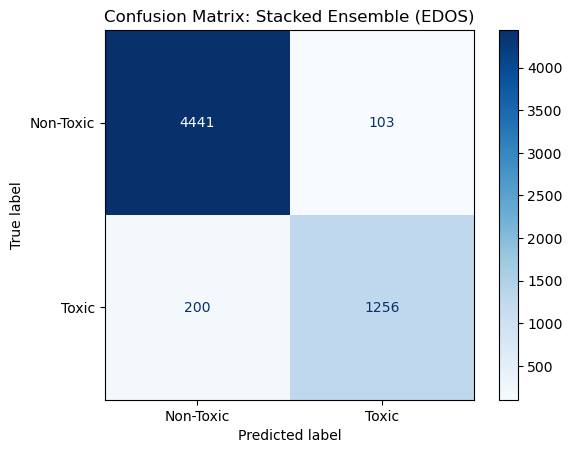

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Stacked Ensemble (EDOS)")
plt.show()


## EDOS (SVC + GloVe + BERT)

In [207]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


In [209]:
from tensorflow.keras.preprocessing.text import Tokenizer

train_df = pd.read_csv("./splits/edos_train.csv")
val_df   = pd.read_csv("./splits/edos_val.csv")
all_texts = pd.concat([train_df, val_df])["clean_text"].astype(str).tolist()

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(all_texts)

joblib.dump(tokenizer, "./models/edos_glove_tokenizer.joblib")


['./models/edos_glove_tokenizer.joblib']

In [39]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import pandas as pd
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits/edos_test.csv"
SAVE_PATH = "./models/edos_bert_embed_test_seq.npy"
MAX_LEN = 100

df = pd.read_csv(DATA_PATH)
texts = df["clean_text"].astype(str).tolist()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT token embeddings"):
            inputs = tokenizer(
                text, return_tensors="pt", truncation=True,
                padding="max_length", max_length=MAX_LEN
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_test_seq = get_bert_seq_embeddings(texts)
np.save(SAVE_PATH, X_test_seq)
print(f"Saved sequence embeddings to: {SAVE_PATH}")


Extracting BERT token embeddings: 100%|█████| 2000/2000 [01:34<00:00, 21.20it/s]


Saved sequence embeddings to: ./models/edos_bert_embed_test_seq.npy


In [96]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import pandas as pd
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits/edos_test.csv"
SAVE_PATH = "./models/edos_bert_embed_test_seq.npy"
MAX_LEN = 100

df = pd.read_csv(DATA_PATH)
texts = df["clean_text"].astype(str).tolist()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_seq_embeddings(texts):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT token embeddings"):
            inputs = tokenizer(
                text, return_tensors="pt", truncation=True,
                padding="max_length", max_length=MAX_LEN
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_test_seq = get_bert_seq_embeddings(texts)
np.save(SAVE_PATH, X_test_seq)
print(f"Saved sequence embeddings to: {SAVE_PATH}")


Extracting BERT token embeddings: 100%|█████| 2000/2000 [02:18<00:00, 14.40it/s]


Saved sequence embeddings to: ./models/edos_bert_embed_test_seq.npy


In [213]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

# TF-IDF + SVC
svc = joblib.load("./models/edos_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

# GloVe + BiLSTM
glove_model = load_model("./models/edos_glove_bilstm.h5")
tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib") 
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

# BERT + BiLSTM
bert_model = load_model("./models/edos_bert_bilstm.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")  
bert_probs = bert_model.predict(bert_X)

avg_probs = (svc_probs + glove_probs + bert_probs) / 3
y_pred = (avg_probs[:, 1] > 0.5).astype(int)

print("\n=== EDOS TEST: Soft Voting Ensemble (SVC + GloVe + BERT) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

=== EDOS TEST: Soft Voting Ensemble (SVC + GloVe + BERT) ===
              precision    recall  f1-score   support

           0     0.8480    0.9723    0.9059      1515
           1     0.8403    0.4557    0.5909       485

    accuracy                         0.8470      2000
   macro avg     0.8442    0.7140    0.7484      2000
weighted avg     0.8461    0.8470    0.8295      2000



In [100]:
svc_w, glove_w, bert_w = 0.1, 0.1, 0.8


weighted_probs = (svc_w * svc_probs) + (glove_w * glove_probs) + (bert_w * bert_probs)
y_pred = (weighted_probs[:, 1] > 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8640    0.9564    0.9079      1515
           1     0.7957    0.5299    0.6361       485

    accuracy                         0.8530      2000
   macro avg     0.8299    0.7432    0.7720      2000
weighted avg     0.8475    0.8530    0.8420      2000



In [233]:
svc_w, glove_w, bert_w = 0.1, 0.4, 0.8


weighted_probs = (svc_w * svc_probs) + (glove_w * glove_probs) + (bert_w * bert_probs)
y_pred = (weighted_probs[:, 1] > 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8870    0.9122    0.8994      1515
           1     0.6991    0.6371    0.6667       485

    accuracy                         0.8455      2000
   macro avg     0.7931    0.7747    0.7831      2000
weighted avg     0.8415    0.8455    0.8430      2000



In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

svc_class1   = svc_probs[:, 1]
glove_class1 = glove_probs.flatten()
bert_class1  = bert_probs.flatten()

X_stack = np.vstack([svc_class1, glove_class1, bert_class1]).T
meta_clf = LogisticRegression()
meta_clf.fit(X_stack, y_true)
y_pred_stack = meta_clf.predict(X_stack)

print("\n=== EDOS: Stacking Ensemble (Logistic Regression) ===")
print(classification_report(y_true, y_pred_stack, digits=4))



=== EDOS: Stacking Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

           0     0.8727    0.9505    0.9100      1515
           1     0.7857    0.5670    0.6587       485

    accuracy                         0.8575      2000
   macro avg     0.8292    0.7588    0.7843      2000
weighted avg     0.8516    0.8575    0.8490      2000



## DAVIDSON (SVC + GloVe + BERT)

In [253]:
import pandas as pd
import joblib
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

train_df = pd.read_csv("./splits/davidson_train.csv")
val_df   = pd.read_csv("./splits/davidson_val.csv")

X_train = train_df["clean_text"]
y_train = train_df["label"].astype(int)
X_val   = val_df["clean_text"]
y_val   = val_df["label"].astype(int)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("svc", SVC(probability=True))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

In [255]:
print("\n=== DAVIDSON: TF-IDF + SVC (val set) ===")
print(classification_report(y_val, y_pred, digits=4))

os.makedirs("./models", exist_ok=True)
joblib.dump(pipe, "./models/davidson_svc_prob.joblib")
print(" Saved as: ./models/davidson_svc_prob.joblib")



=== DAVIDSON: TF-IDF + SVC (val set) ===
              precision    recall  f1-score   support

           0     0.8182    0.1259    0.2182       143
           1     0.9089    0.9719    0.9393      1919
           2     0.8515    0.8269    0.8390       416

    accuracy                         0.8987      2478
   macro avg     0.8595    0.6416    0.6655      2478
weighted avg     0.8940    0.8987    0.8809      2478

 Saved as: ./models/davidson_svc_prob.joblib


In [257]:
import joblib

svc = joblib.load("./models/davidson_svc_prob.joblib")  
svc_probs = svc.predict_proba(texts)  


In [259]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import joblib
import os

MAX_WORDS = 10000

train_df = pd.read_csv("./splits/davidson_train.csv")
texts = train_df["clean_text"].astype(str).tolist()

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

os.makedirs("./models", exist_ok=True)
joblib.dump(tokenizer, "./models/davidson_glove_tokenizer.joblib")
print("Tokenizer saved as: davidson_glove_tokenizer.joblib")


Tokenizer saved as: davidson_glove_tokenizer.joblib


In [263]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

test_df = pd.read_csv(os.path.join(DATA_PATH, "davidson_test.csv"))
texts = test_df["clean_text"].astype(str).tolist()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT test embeddings"):
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=max_len
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy() 
            all_seq.append(token_vecs)
    return np.array(all_seq)

X_test = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save(os.path.join(SAVE_PATH, "davidson_bert_embed_test.npy"), X_test)
print(" Saved Davidson test embeddings to: davidson_bert_embed_test.npy")


Extracting BERT test embeddings: 100%|██████| 2479/2479 [01:59<00:00, 20.79it/s]


 Saved Davidson test embeddings to: davidson_bert_embed_test.npy


In [267]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/davidson_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

# TF-IDF + SVC
svc = joblib.load("./models/davidson_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

# GloVe + BiLSTM 
glove_model = load_model("./models/davidson_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

# BERT + BiLSTM
bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)

avg_probs = (svc_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== DAVIDSON TEST: Soft Voting Ensemble (SVC + GloVe + BERT) ===")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

=== DAVIDSON TEST: Soft Voting Ensemble (SVC + GloVe + BERT) ===
              precision    recall  f1-score   support

           0     0.4898    0.1678    0.2500       143
           1     0.9269    0.9640    0.9451      1919
           2     0.8641    0.8993    0.8813       417

    accuracy                         0.9072      2479
   macro avg     0.7602    0.6771    0.6921      2479
weighted avg     0.8911    0.9072    0.8943      2479



In [269]:
weights = [0.1, 0.2, 0.8] 
avg_probs = (
    weights[0] * svc_probs +
    weights[1] * glove_probs +
    weights[2] * bert_probs
)

y_pred = np.argmax(avg_probs, axis=1)

print("\n=== DAVIDSON TEST: Weighted Soft Voting Ensemble ===")
print(classification_report(y_true, y_pred, digits=4))


=== DAVIDSON TEST: Weighted Soft Voting Ensemble ===
              precision    recall  f1-score   support

           0     0.5490    0.1958    0.2887       143
           1     0.9281    0.9687    0.9480      1919
           2     0.8682    0.8849    0.8765       417

    accuracy                         0.9100      2479
   macro avg     0.7818    0.6831    0.7044      2479
weighted avg     0.8962    0.9100    0.8979      2479



In [210]:
from sklearn.linear_model import LogisticRegression

X_stack = np.hstack([
    svc_probs,
    glove_probs,
    bert_probs
]) 

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_stack, y_true)
y_pred_stack = meta_clf.predict(X_stack)

print("\n=== DAVIDSON TEST: Stacking Ensemble (LogReg) ===")
print(classification_report(y_true, y_pred_stack, digits=4))



=== DAVIDSON TEST: Stacking Ensemble (LogReg) ===
              precision    recall  f1-score   support

           0     0.4815    0.1818    0.2640       143
           1     0.9242    0.9651    0.9442      1919
           2     0.8789    0.8873    0.8831       417

    accuracy                         0.9068      2479
   macro avg     0.7615    0.6781    0.6971      2479
weighted avg     0.8910    0.9068    0.8947      2479



## HateXplain (SVC + GloVe + BERT)

In [373]:
import pandas as pd
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

train_df = pd.read_csv("./splits/hatexplain_train.csv")
val_df   = pd.read_csv("./splits/hatexplain_val.csv")
X_train, y_train = train_df["clean_text"], train_df["label"]
X_val, y_val     = val_df["clean_text"],   val_df["label"]

os.makedirs("./models", exist_ok=True)

svc_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("svc", SVC(probability=True))
])
svc_pipe.fit(X_train, y_train)

y_pred = svc_pipe.predict(X_val)
print("\n=== HATEXPLAIN: TF-IDF + SVC ===")
print(classification_report(y_val, y_pred, digits=4))

joblib.dump(svc_pipe, "./models/hatexplain_svc_prob.joblib")
print("Saved as: ./models/hatexplain_svc_prob.joblib")



=== HATEXPLAIN: TF-IDF + SVC ===
              precision    recall  f1-score   support

           0     0.5915    0.7990    0.6798       821
           1     0.5239    0.3496    0.4194       595
           2     0.7092    0.6027    0.6516       599

    accuracy                         0.6079      2015
   macro avg     0.6082    0.5838    0.5836      2015
weighted avg     0.6066    0.6079    0.5945      2015

Saved as: ./models/hatexplain_svc_prob.joblib


In [282]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import joblib

MAX_LEN = 100
MAX_WORDS = 10000
EMBED_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"  

train_df = pd.read_csv("./splits/hatexplain_train.csv")
val_df   = pd.read_csv("./splits/hatexplain_val.csv")
texts    = pd.concat([train_df["clean_text"], val_df["clean_text"]]).tolist()
labels   = pd.concat([train_df["label"], val_df["label"]]).astype(int).tolist()

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = to_categorical(labels, num_classes=3)

# Save tokenizer
os.makedirs("./models", exist_ok=True)
joblib.dump(tokenizer, "./models/hatexplain_glove_tokenizer.joblib")

embeddings_index = {}
with open(GLOVE_PATH, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word, vec = values[0], np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vec

embedding_matrix = np.zeros((len(word_index) + 1, EMBED_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS and word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=np.argmax(y, axis=1), random_state=42)

model = Sequential([
    Embedding(len(word_index) + 1, EMBED_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

model.save("./models/hatexplain_glove_bilstm.h5")
print("Model and tokenizer saved.")


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


397/397 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4503 - loss: 1.0491 - val_accuracy: 0.5575 - val_loss: 0.9507
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5590 - loss: 0.9303 - val_accuracy: 0.5743 - val_loss: 0.9132
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.5762 - loss: 0.9071 - val_accuracy: 0.5868 - val_loss: 0.9021
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.6110 - loss: 0.8701 - val_accuracy: 0.5961 - val_loss: 0.8862
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.6240 - loss: 0.8429 - val_accuracy: 0.5866 - val_loss: 0.9086
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.6266 - loss: 0.8382 - val_accuracy: 0.5945 - val_loss: 0.8840
Epoch 7/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.6342 - loss: 0.8117 - val_accuracy: 0.5952 - val_loss: 0.8851
Epoch 8/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.6535 - loss: 0.7944 - val_accurac

Model and tokenizer saved.


In [286]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import os

MODEL_NAME = "bert-base-uncased"
DATA_PATH = "./splits"
SAVE_PATH = "./models"
MAX_LEN = 100
os.makedirs(SAVE_PATH, exist_ok=True)

df = pd.read_csv(os.path.join(DATA_PATH, "hatexplain_test.csv"))
texts = df["clean_text"].astype(str).tolist()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Generating BERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            token_vecs = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            embeddings.append(token_vecs)
    return np.array(embeddings)

embeddings = get_bert_embeddings(texts)
np.save(os.path.join(SAVE_PATH, "hatexplain_bert_embed_test.npy"), embeddings)
print(" Saved: hatexplain_bert_embed_test.npy")


Generating BERT embeddings: 100%|███████████| 2015/2015 [01:43<00:00, 19.38it/s]


 Saved: hatexplain_bert_embed_test.npy


In [375]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

# TF-IDF + SVC
svc = joblib.load("./models/hatexplain_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

# GloVe + BiLSTM 
glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

#BERT + BiLSTM 
bert_model = load_model("./models/hatexplain_bert_bilstm_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)

avg_probs = (svc_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Soft Voting Ensemble (SVC + GloVe + BERT) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

=== HATEXPLAIN TEST: Soft Voting Ensemble (SVC + GloVe + BERT) ===
              precision    recall  f1-score   support

           0     0.6296    0.7990    0.7042       821
           1     0.5406    0.3244    0.4055       595
           2     0.6591    0.6778    0.6683       599

    accuracy                         0.6228      2015
   macro avg     0.6098    0.6004    0.5927      2015
weighted avg     0.6121    0.6228    0.6053      2015



In [381]:
w1, w2, w3 = 0.1, 0.1, 0.8 
final_probs = w1 * svc_probs + w2 * glove_probs + w3 * bert_probs
y_pred = np.argmax(final_probs, axis=1)

print("\n=== HATEXPLAIN: Weighted Soft Voting Ensemble ===")
print(classification_report(y_true, y_pred, digits=4))


=== HATEXPLAIN: Weighted Soft Voting Ensemble ===
              precision    recall  f1-score   support

           0     0.6099    0.8112    0.6963       821
           1     0.5672    0.2555    0.3523       595
           2     0.6458    0.7062    0.6746       599

    accuracy                         0.6159      2015
   macro avg     0.6076    0.5909    0.5744      2015
weighted avg     0.6079    0.6159    0.5883      2015



In [189]:
X_stack = np.hstack([
    svc_probs,
    glove_probs,
    bert_probs
]) 

meta_clf = LogisticRegression(max_iter=500)
meta_clf.fit(X_stack, y_true)
y_pred_stack = meta_clf.predict(X_stack)

print("\n=== HATEXPLAIN TEST: Stacking Ensemble (Logistic Regression) ===")
print(classification_report(y_true, y_pred_stack, digits=4))


=== HATEXPLAIN TEST: Stacking Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

           0     0.6415    0.7759    0.7023       821
           1     0.5106    0.3630    0.4244       595
           2     0.6694    0.6694    0.6694       599

    accuracy                         0.6223      2015
   macro avg     0.6072    0.6028    0.5987      2015
weighted avg     0.6112    0.6223    0.6105      2015



## Oversampling Experiment 

In [241]:
import pandas as pd
import joblib, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

edos_train = pd.read_csv("./splits/edos_train.csv")
edos_val   = pd.read_csv("./splits/edos_val.csv")

X_train_raw, y_train_raw = edos_train["clean_text"], edos_train["label"]
X_val, y_val             = edos_val["clean_text"],   edos_val["label"]

os.makedirs("./models", exist_ok=True)

vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train_raw)
X_val_vec   = vectorizer.transform(X_val)

ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train_vec, y_train_raw)

classifiers = {
    "edos_os_svc": LinearSVC(),
    "edos_os_lr":  LogisticRegression(max_iter=1000),
    "edos_os_rf":  RandomForestClassifier(n_estimators=100),
    "edos_os_xgb": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, clf in classifiers.items():
    clf.fit(X_train_os, y_train_os)
    y_pred = clf.predict(X_val_vec)
    print(f"\n--- {name.upper()} (Oversampled) ---")
    print(classification_report(y_val, y_pred, digits=4))
    joblib.dump((vectorizer, clf), f"./models/{name}.joblib")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- EDOS_OS_SVC (Oversampled) ---
              precision    recall  f1-score   support

           0     0.8736    0.8494    0.8614      1514
           1     0.5682    0.6173    0.5917       486

    accuracy                         0.7930      2000
   macro avg     0.7209    0.7333    0.7265      2000
weighted avg     0.7994    0.7930    0.7958      2000


--- EDOS_OS_LR (Oversampled) ---
              precision    recall  f1-score   support

           0     0.8887    0.8487    0.8682      1514
           1     0.5866    0.6687    0.6250       486

    accuracy                         0.8050      2000
   macro avg     0.7377    0.7587    0.7466      2000
weighted avg     0.8153    0.8050    0.8091      2000


--- EDOS_OS_RF (Oversampled) ---
              precision    recall  f1-score   support

           0     0.8350    0.9590    0.8927      1514
           1     0.7625    0.4095    0.5328       486

    accuracy                         0.8255      2000
   macro avg     0.7987  

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- EDOS_OS_XGB (Oversampled) ---
              precision    recall  f1-score   support

           0     0.8785    0.8593    0.8688      1514
           1     0.5896    0.6296    0.6090       486

    accuracy                         0.8035      2000
   macro avg     0.7340    0.7445    0.7389      2000
weighted avg     0.8083    0.8035    0.8056      2000



In [243]:
import pandas as pd
import joblib, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

davidson_train = pd.read_csv("./splits/davidson_train.csv")
davidson_val   = pd.read_csv("./splits/davidson_val.csv")
X_train_raw, y_train_raw = davidson_train["clean_text"], davidson_train["label"]
X_val, y_val             = davidson_val["clean_text"],   davidson_val["label"]

os.makedirs("./models", exist_ok=True)

# TF-IDF vectorizer (fit on train only)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train_raw)
X_val_vec   = vectorizer.transform(X_val)

ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train_vec, y_train_raw)

classifiers = {
    "davidson_os_svc": LinearSVC(),
    "davidson_os_lr":  LogisticRegression(max_iter=1000),
    "davidson_os_rf":  RandomForestClassifier(n_estimators=100),
    "davidson_os_xgb": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

for name, clf in classifiers.items():
    clf.fit(X_train_os, y_train_os)
    y_pred = clf.predict(X_val_vec)
    print(f"\n--- {name.upper()} (Oversampled) ---")
    print(classification_report(y_val, y_pred, digits=4))
    joblib.dump((vectorizer, clf), f"./models/{name}.joblib")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- DAVIDSON_OS_SVC (Oversampled) ---
              precision    recall  f1-score   support

           0     0.3122    0.4825    0.3791       143
           1     0.9343    0.8812    0.9069      1919
           2     0.7785    0.8365    0.8065       416

    accuracy                         0.8507      2478
   macro avg     0.6750    0.7334    0.6975      2478
weighted avg     0.8722    0.8507    0.8596      2478


--- DAVIDSON_OS_LR (Oversampled) ---
              precision    recall  f1-score   support

           0     0.3451    0.5455    0.4228       143
           1     0.9561    0.8744    0.9134      1919
           2     0.7606    0.9087    0.8280       416

    accuracy                         0.8612      2478
   macro avg     0.6873    0.7762    0.7214      2478
weighted avg     0.8880    0.8612    0.8708      2478


--- DAVIDSON_OS_RF (Oversampled) ---
              precision    recall  f1-score   support

           0     0.5536    0.2168    0.3116       143
           1  

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- DAVIDSON_OS_XGB (Oversampled) ---
              precision    recall  f1-score   support

           0     0.3347    0.5874    0.4264       143
           1     0.9692    0.8541    0.9080      1919
           2     0.7351    0.9471    0.8277       416

    accuracy                         0.8543      2478
   macro avg     0.6797    0.7962    0.7207      2478
weighted avg     0.8933    0.8543    0.8668      2478



In [245]:
import pandas as pd
import joblib, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

hatexplain_train = pd.read_csv("./splits/hatexplain_train.csv")
hatexplain_val   = pd.read_csv("./splits/hatexplain_val.csv")
X_train_raw, y_train_raw = hatexplain_train["clean_text"], hatexplain_train["label"]
X_val, y_val             = hatexplain_val["clean_text"],   hatexplain_val["label"]

os.makedirs("./models", exist_ok=True)

vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train_raw)
X_val_vec   = vectorizer.transform(X_val)

ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train_vec, y_train_raw)

classifiers = {
    "hatexplain_os_svc": LinearSVC(),
    "hatexplain_os_lr":  LogisticRegression(max_iter=1000),
    "hatexplain_os_rf":  RandomForestClassifier(n_estimators=100),
    "hatexplain_os_xgb": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

for name, clf in classifiers.items():
    clf.fit(X_train_os, y_train_os)
    y_pred = clf.predict(X_val_vec)
    print(f"\n--- {name.upper()} (Oversampled) ---")
    print(classification_report(y_val, y_pred, digits=4))
    joblib.dump((vectorizer, clf), f"./models/{name}.joblib")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- HATEXPLAIN_OS_SVC (Oversampled) ---
              precision    recall  f1-score   support

           0     0.6081    0.6066    0.6073       821
           1     0.4229    0.4286    0.4257       595
           2     0.6121    0.6060    0.6091       599

    accuracy                         0.5538      2015
   macro avg     0.5477    0.5471    0.5474      2015
weighted avg     0.5546    0.5538    0.5542      2015


--- HATEXPLAIN_OS_LR (Oversampled) ---
              precision    recall  f1-score   support

           0     0.6310    0.6456    0.6382       821
           1     0.4513    0.4521    0.4517       595
           2     0.6563    0.6344    0.6452       599

    accuracy                         0.5851      2015
   macro avg     0.5795    0.5773    0.5784      2015
weighted avg     0.5855    0.5851    0.5852      2015


--- HATEXPLAIN_OS_RF (Oversampled) ---
              precision    recall  f1-score   support

           0     0.5756    0.7649    0.6569       821
        

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- HATEXPLAIN_OS_XGB (Oversampled) ---
              precision    recall  f1-score   support

           0     0.6406    0.7077    0.6725       821
           1     0.4896    0.4756    0.4825       595
           2     0.6943    0.6144    0.6519       599

    accuracy                         0.6114      2015
   macro avg     0.6082    0.5992    0.6023      2015
weighted avg     0.6120    0.6114    0.6103      2015



# Embedding-Classifier results on test set

## EDOS 

### Section A 

In [115]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score


edos_test = pd.read_csv("./splits/edos_test.csv")
X_test, y_test = edos_test["clean_text"], edos_test["label"]

model_paths = {
    "EDOS_SVC": "./models/edos_svc.joblib",
    "EDOS_LR": "./models/edos_lr.joblib",
    "EDOS_RF": "./models/edos_rf.joblib",
    "EDOS_XGB": "./models/edos_xgb.joblib",
    "EDOS_MLP": "./models/edos_mlp.joblib"
}

results = []

for name, path in model_paths.items():
    model = joblib.load(path)
    y_pred = model.predict(X_test)
    
    print(f"\n {name} on EDOS Test Set:")
    print(classification_report(y_test, y_pred, digits=4))
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)
    results.append([name, precision, recall, f1, acc])

summary_df = pd.DataFrame(
    results,
    columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"]
)
print("\n=== Evaluation Summary Table ===")
print(summary_df.to_string(index=False))



 EDOS_SVC on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8493    0.9340    0.8897      1515
           1     0.7006    0.4825    0.5714       485

    accuracy                         0.8245      2000
   macro avg     0.7750    0.7082    0.7305      2000
weighted avg     0.8133    0.8245    0.8125      2000


 EDOS_LR on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8226    0.9795    0.8942      1515
           1     0.8418    0.3402    0.4846       485

    accuracy                         0.8245      2000
   macro avg     0.8322    0.6599    0.6894      2000
weighted avg     0.8273    0.8245    0.7949      2000


 EDOS_RF on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8222    0.9921    0.8992      1515
           1     0.9302    0.3299    0.4871       485

    accuracy                         0.8315      2000
   macro avg     0.8762    0.6610    0.6931

### Section B

In [127]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
EMBEDDING_DIM = 100
MODEL_DIR = "./models"
TEST_PATH = "./splits/edos_test.csv"

edos_test = pd.read_csv(TEST_PATH)
X_test_texts = edos_test["clean_text"].astype(str).tolist()
y_test = edos_test["label"].astype(int).values

tokenizer = joblib.load(f"{MODEL_DIR}/edos_glove_tokenizer.joblib")
embedding_matrix = np.load(f"{MODEL_DIR}/edos_glove_embedding_matrix.npy")

X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_texts), maxlen=MAX_LEN)

X_test_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_test_seq
])

model_files = {
    "GloVe-Avg + MLP": f"{MODEL_DIR}/edos_glove_mlp.h5",
    "GloVe-Emb + CNN": f"{MODEL_DIR}/edos_glove_cnn.h5",
    "GloVe-Emb + BiLSTM": f"{MODEL_DIR}/edos_glove_bilstm.h5"
}

results = []

for model_name, model_path in model_files.items():
    model = load_model(model_path)
    if "MLP" in model_name:
        preds = model.predict(X_test_avg)
    else:
        preds = model.predict(X_test_seq)
    y_pred = (preds > 0.5).astype(int).reshape(-1)

    print(f"\n {model_name} on EDOS Test Set:")
    print(classification_report(y_test, y_pred, digits=4))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)
    results.append([model_name, precision, recall, f1, acc])

summary_df = pd.DataFrame(
    results,
    columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"]
)

print("\n=== Summary ===")
print(summary_df.to_string(index=False))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step 



 GloVe-Avg + MLP on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.7810    0.9696    0.8651      1515
           1     0.6134    0.1505    0.2417       485

    accuracy                         0.7710      2000
   macro avg     0.6972    0.5601    0.5534      2000
weighted avg     0.7403    0.7710    0.7140      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



 GloVe-Emb + CNN on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8569    0.9406    0.8968      1515
           1     0.7329    0.5093    0.6010       485

    accuracy                         0.8360      2000
   macro avg     0.7949    0.7249    0.7489      2000
weighted avg     0.8268    0.8360    0.8251      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 GloVe-Emb + BiLSTM on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8614    0.9314    0.8950      1515
           1     0.7127    0.5320    0.6092       485

    accuracy                         0.8345      2000
   macro avg     0.7871    0.7317    0.7521      2000
weighted avg     0.8254    0.8345    0.8257      2000


=== Summary ===
             Model  Macro Precision  Macro Recall  Macro F1 Score  Accuracy
   GloVe-Avg + MLP         0.697206      0.560076        0.553429    0.7710
   GloVe-Emb + CNN         0.794911      0.724936        0.7488

In [125]:
import numpy as np
import pandas as pd
import os
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer


train_df = pd.read_csv("./splits/edos_train.csv")
texts = train_df["clean_text"].astype(str).tolist()

MAX_WORDS = 10000
EMBEDDING_DIM = 100
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

joblib.dump(tokenizer, f"{MODEL_DIR}/edos_glove_tokenizer.joblib")
np.save(f"{MODEL_DIR}/edos_glove_embedding_matrix.npy", embedding_matrix)

print(" Saved: tokenizer and embedding matrix for EDOS GloVe models.")


 Saved: tokenizer and embedding matrix for EDOS GloVe models.


### Section C

In [139]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.models import load_model

df = pd.read_csv("./splits/edos_test.csv")
y_true = df["label"].astype(int).values

model_groups = {
    "BERT": {
        "embed": np.load("./models/edos_bert_embed_test_seq.npy"),
        "mlp": "./models/edos_bert_mlp.joblib",
        "bilstm": "./models/edos_bert_bilstm.h5",
        "cnn": "./models/edos_bert_cnn.h5"
    },
    "ALBERT": {
        "embed": np.load("./models/edos_albert_embed_test_seq.npy"),
        "mlp": "./models/edos_albert_mlp.joblib",
        "bilstm": "./models/edos_albert_bilstm.h5",
        "cnn": "./models/edos_albert_cnn.h5"
    },
    "ELECTRA": {
        "embed": np.load("./models/edos_electra_embed_test_seq.npy"),
        "mlp": "./models/edos_electra_mlp.joblib",
        "bilstm": "./models/edos_electra_bilstm.h5",
        "cnn": "./models/edos_electra_cnn.h5"
    }
}

results = []

for model_name, paths in model_groups.items():
    X = paths["embed"]

    # MLP 
    X_avg = np.mean(X, axis=1)
    mlp = joblib.load(paths["mlp"])
    y_pred = mlp.predict(X_avg)
    print(f"\n {model_name} + MLP on EDOS Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + MLP", p, r, f1, acc])

    # BiLSTM 
    bilstm = load_model(paths["bilstm"])
    y_pred = (bilstm.predict(X) > 0.5).astype(int).reshape(-1)
    print(f"\n{model_name} + BiLSTM on EDOS Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + BiLSTM", p, r, f1, acc])

    # CNN 
    cnn = load_model(paths["cnn"])
    y_pred = (cnn.predict(X) > 0.5).astype(int).reshape(-1)
    print(f"\n{model_name} + CNN on EDOS Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + CNN", p, r, f1, acc])

summary_df = pd.DataFrame(results, columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"])
print("\n=== Transformer-Based Model Summary ===")
print(summary_df.to_string(index=False))



 BERT + MLP on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8470    0.9135    0.8790      1515
           1     0.6421    0.4845    0.5523       485

    accuracy                         0.8095      2000
   macro avg     0.7445    0.6990    0.7157      2000
weighted avg     0.7973    0.8095    0.7998      2000



63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

BERT + BiLSTM on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8681    0.9426    0.9038      1515
           1     0.7549    0.5526    0.6381       485

    accuracy                         0.8480      2000
   macro avg     0.8115    0.7476    0.7709      2000
weighted avg     0.8406    0.8480    0.8394      2000



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

BERT + CNN on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8831    0.9373    0.9094      1515
           1     0.7577    0.6124    0.6773       485

    accuracy                         0.8585      2000
   macro avg     0.8204    0.7748    0.7933      2000
weighted avg     0.8527    0.8585    0.8531      2000


 ALBERT + MLP on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8116    0.9498    0.8753      1515
           1     0.6652    0.3113    0.4242       485

    accuracy                         0.7950      2000
   macro avg     0.7384    0.6306    0.6497      2000
weighted avg     0.7761    0.7950    0.7659      2000



63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step



ALBERT + BiLSTM on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8764    0.9406    0.9074      1515
           1     0.7594    0.5856    0.6612       485

    accuracy                         0.8545      2000
   macro avg     0.8179    0.7631    0.7843      2000
weighted avg     0.8480    0.8545    0.8477      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

ALBERT + CNN on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8725    0.9393    0.9046      1515
           1     0.7507    0.5711    0.6487       485

    accuracy                         0.8500      2000
   macro avg     0.8116    0.7552    0.7767      2000
weighted avg     0.8429    0.8500    0.8426      2000


 ELECTRA + MLP on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.7791    0.9617    0.8609      1515
           1     0.5538    0.1485    0.2341       485

    accuracy                         0.76

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step



ELECTRA + BiLSTM on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8539    0.9294    0.8900      1515
           1     0.6952    0.5031    0.5837       485

    accuracy                         0.8260      2000
   macro avg     0.7745    0.7162    0.7369      2000
weighted avg     0.8154    0.8260    0.8157      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

ELECTRA + CNN on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8364    0.9109    0.8720      1515
           1     0.6143    0.4433    0.5150       485

    accuracy                         0.7975      2000
   macro avg     0.7253    0.6771    0.6935      2000
weighted avg     0.7825    0.7975    0.7854      2000


=== Transformer-Based Model Summary ===
           Model  Macro Precision  Macro Recall  Macro F1 Score  Accuracy
      BERT + MLP         0.744539      0.699034        0.715650    0.8095
   BERT + BiLSTM         0.811507      0.747576 

In [131]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/edos_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_embeddings = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT embeddings (EDOS test)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            seq_embed = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            all_embeddings.append(seq_embed)
    return np.array(all_embeddings)

X_embed = get_sequence_embeddings(texts, tokenizer, model)
np.save("./models/edos_albert_embed_test_seq.npy", X_embed)

print(" Saved: edos_albert_embed_test_seq.npy with shape", X_embed.shape)


Extracting ALBERT embeddings (EDOS test): 100%|█| 2000/2000 [01:35<00:00, 20.97i


 Saved: edos_albert_embed_test_seq.npy with shape (2000, 100, 768)


In [135]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/edos_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_embeddings = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA embeddings (EDOS test)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            seq_embed = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            all_embeddings.append(seq_embed)
    return np.array(all_embeddings)

X_embed = get_sequence_embeddings(texts, tokenizer, model)
np.save("./models/edos_electra_embed_test_seq.npy", X_embed)

print("Saved: edos_electra_embed_test_seq.npy with shape", X_embed.shape)


Extracting ELECTRA embeddings (EDOS test): 100%|█| 2000/2000 [01:49<00:00, 18.32


Saved: edos_electra_embed_test_seq.npy with shape (2000, 100, 768)


## Davidson

### Section A

In [145]:
import pandas as pd
import joblib
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

df = pd.read_csv("./splits/davidson_test.csv")
X_test = df["clean_text"]
y_test = df["label"].astype(int)

model_paths = {
    "Davidson_SVC": "./models/davidson_svc.joblib",
    "Davidson_LR": "./models/davidson_lr.joblib",
    "Davidson_RF": "./models/davidson_rf.joblib",
    "Davidson_XGB": "./models/davidson_xgb.joblib",
    "Davidson_MLP": "./models/davidson_mlp.joblib"
}

results = []

for name, path in model_paths.items():
    if os.path.exists(path):
        model = joblib.load(path)
        y_pred = model.predict(X_test)
        print(f"\n {name} on Davidson Test Set:")
        print(classification_report(y_test, y_pred, digits=4))

        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        results.append([name, precision, recall, f1, acc])
    else:
        print(f" Model not found: {path}")

summary_df = pd.DataFrame(results, columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"])
print("\n=== Davidson Model Summary ===")
print(summary_df.to_string(index=False))



 Davidson_SVC on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.4688    0.2098    0.2899       143
           1     0.9173    0.9541    0.9354      1919
           2     0.8377    0.8417    0.8397       417

    accuracy                         0.8923      2479
   macro avg     0.7413    0.6686    0.6883      2479
weighted avg     0.8781    0.8923    0.8820      2479


 Davidson_LR on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.4865    0.1259    0.2000       143
           1     0.9054    0.9672    0.9352      1919
           2     0.8546    0.8034    0.8282       417

    accuracy                         0.8911      2479
   macro avg     0.7488    0.6321    0.6545      2479
weighted avg     0.8727    0.8911    0.8748      2479


 Davidson_RF on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.3529    0.0420    0.0750       143
           1     0.8

### Section B

In [155]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
EMBEDDING_DIM = 100
MODEL_DIR = "./models"

df = pd.read_csv("./splits/davidson_test.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

tokenizer = joblib.load(f"{MODEL_DIR}/davidson_glove_tokenizer.joblib")
embedding_matrix = np.load(f"{MODEL_DIR}/davidson_glove_embedding_matrix.npy")

X_test_seq = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)

X_test_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_test_seq
])

model_files = {
    "GloVe-Avg + MLP": f"{MODEL_DIR}/davidson_glove_mlp.h5",
    "GloVe-Emb + CNN": f"{MODEL_DIR}/davidson_glove_cnn.h5",
    "GloVe-Emb + BiLSTM": f"{MODEL_DIR}/davidson_glove_bilstm.h5"
}

results = []

for model_name, model_path in model_files.items():
    model = load_model(model_path)
    if "MLP" in model_name:
        preds = model.predict(X_test_avg)
    else:
        preds = model.predict(X_test_seq)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n {model_name} on Davidson Test Set:")
    print(classification_report(y_true, y_pred, digits=4))

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([model_name, precision, recall, f1, acc])

summary_df = pd.DataFrame(results, columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"])
print("\n=== Davidson GloVe-Based Model Summary ===")
print(summary_df.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step



 GloVe-Avg + MLP on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.2973    0.0769    0.1222       143
           1     0.8811    0.9573    0.9176      1919
           2     0.7731    0.6619    0.7132       417

    accuracy                         0.8568      2479
   macro avg     0.6505    0.5654    0.5843      2479
weighted avg     0.8292    0.8568    0.8373      2479

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



 GloVe-Emb + CNN on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.4815    0.0909    0.1529       143
           1     0.8999    0.9599    0.9289      1919
           2     0.8000    0.7770    0.7883       417

    accuracy                         0.8790      2479
   macro avg     0.7271    0.6093    0.6234      2479
weighted avg     0.8589    0.8790    0.8605      2479

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 GloVe-Emb + BiLSTM on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.4444    0.1958    0.2718       143
           1     0.9199    0.9401    0.9299      1919
           2     0.7758    0.8465    0.8096       417

    accuracy                         0.8814      2479
   macro avg     0.7134    0.6608    0.6705      2479
weighted avg     0.8683    0.8814    0.8717      2479


=== Davidson GloVe-Based Model Summary ===
             Model  Macro Precision  Macro Recall  Macro F1 Score  Accur

In [153]:
import numpy as np
import pandas as pd
import os
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_WORDS = 10000
EMBEDDING_DIM = 100
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

train_df = pd.read_csv("./splits/davidson_train.csv")
texts = train_df["clean_text"].astype(str).tolist()

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

joblib.dump(tokenizer, f"{MODEL_DIR}/davidson_glove_tokenizer.joblib")
np.save(f"{MODEL_DIR}/davidson_glove_embedding_matrix.npy", embedding_matrix)

print(" Saved: davidson_glove_tokenizer.joblib and davidson_glove_embedding_matrix.npy")


 Saved: davidson_glove_tokenizer.joblib and davidson_glove_embedding_matrix.npy


### Section C

In [166]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.models import load_model

df = pd.read_csv("./splits/davidson_test.csv")
y_true = df["label"].astype(int).values

model_groups = {
    "BERT": {
        "embed": np.load("./models/davidson_bert_embed_test_seq.npy"),
        "mlp": "./models/davidson_bert_mlp.joblib",
        "bilstm": "./models/davidson_bert_bilstm_best.h5",
        "cnn": "./models/davidson_bert_cnn_best.h5"
    },
    "ALBERT": {
        "embed": np.load("./models/davidson_albert_embed_test_seq.npy"),
        "mlp": "./models/davidson_albert_mlp.joblib",
        "bilstm": "./models/davidson_albert_bilstm_best.h5",
        "cnn": "./models/davidson_albert_cnn_best.h5"
    },
    "ELECTRA": {
        "embed": np.load("./models/davidson_electra_embed_test_seq.npy"),
        "mlp": "./models/davidson_electra_mlp.joblib",
        "bilstm": "./models/davidson_electra_bilstm_best.h5",
        "cnn": "./models/davidson_electra_cnn_best.h5"
    }
}

results = []

for model_name, paths in model_groups.items():
    X = paths["embed"]

    # MLP 
    X_avg = np.mean(X, axis=1)
    mlp = joblib.load(paths["mlp"])
    y_pred = mlp.predict(X_avg)
    print(f"\n {model_name} + MLP on Davidson Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + MLP", p, r, f1, acc])

    # BiLSTM
    bilstm = load_model(paths["bilstm"])
    y_pred = np.argmax(bilstm.predict(X), axis=1)
    print(f"\n {model_name} + BiLSTM on Davidson Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + BiLSTM", p, r, f1, acc])

    # CNN
    cnn = load_model(paths["cnn"])
    y_pred = np.argmax(cnn.predict(X), axis=1)
    print(f"\n {model_name} + CNN on Davidson Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + CNN", p, r, f1, acc])

summary_df = pd.DataFrame(results, columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"])
print("\n=== Davidson Transformer-Based Model Summary ===")
print(summary_df.to_string(index=False))



 BERT + MLP on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.3953    0.1189    0.1828       143
           1     0.8729    0.9594    0.9141      1919
           2     0.7982    0.6259    0.7016       417

    accuracy                         0.8548      2479
   macro avg     0.6888    0.5680    0.5995      2479
weighted avg     0.8328    0.8548    0.8362      2479



78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step



 BERT + BiLSTM on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.4561    0.1818    0.2600       143
           1     0.9218    0.9646    0.9427      1919
           2     0.8551    0.8489    0.8520       417

    accuracy                         0.9000      2479
   macro avg     0.7443    0.6651    0.6849      2479
weighted avg     0.8837    0.9000    0.8881      2479

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

 BERT + CNN on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.5455    0.1259    0.2045       143
           1     0.9290    0.9484    0.9386      1919
           2     0.7844    0.9161    0.8451       417

    accuracy                         0.8955      2479
   macro avg     0.7530    0.6635    0.6628      2479
weighted avg     0.8826    0.8955    0.8806      2479


 ALBERT + MLP on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.3279    0.1399

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

 ALBERT + BiLSTM on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.4118    0.0490    0.0875       143
           1     0.9141    0.9599    0.9365      1919
           2     0.8009    0.8585    0.8287       417

    accuracy                         0.8903      2479
   macro avg     0.7089    0.6224    0.6176      2479
weighted avg     0.8661    0.8903    0.8694      2479



78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

 ALBERT + CNN on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.5000    0.1049    0.1734       143
           1     0.9097    0.9552    0.9319      1919
           2     0.8018    0.8345    0.8179       417

    accuracy                         0.8858      2479
   macro avg     0.7372    0.6315    0.6410      2479
weighted avg     0.8679    0.8858    0.8689      2479


 ELECTRA + MLP on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.3636    0.0280    0.0519       143
           1     0.8341    0.9745    0.8988      1919
           2     0.7478    0.4053    0.5257       417

    accuracy                         0.8241      2479
   macro avg     0.6485    0.4692    0.4921      2479
weighted avg     0.7924    0.8241    0.7872      2479



78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step



 ELECTRA + BiLSTM on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.3187    0.2028    0.2479       143
           1     0.9066    0.9510    0.9283      1919
           2     0.8427    0.7578    0.7980       417

    accuracy                         0.8754      2479
   macro avg     0.6893    0.6372    0.6580      2479
weighted avg     0.8619    0.8754    0.8671      2479

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

 ELECTRA + CNN on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.5000    0.1748    0.2591       143
           1     0.9047    0.9495    0.9265      1919
           2     0.7831    0.7794    0.7812       417

    accuracy                         0.8762      2479
   macro avg     0.7293    0.6346    0.6556      2479
weighted avg     0.8609    0.8762    0.8636      2479


=== Davidson Transformer-Based Model Summary ===
           Model  Macro Precision  Macro Recall  Macro F1 Score  Accur

In [160]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/davidson_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_sequence_embeddings(texts, tokenizer, model, max_len=100):
    embeddings = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT embeddings for Davidson test"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            seq_embed = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            embeddings.append(seq_embed)
    return np.array(embeddings)

X_embed = get_sequence_embeddings(texts, tokenizer, model)
np.save("./models/davidson_albert_embed_test_seq.npy", X_embed)
print(" Saved: davidson_albert_embed_test_seq.npy with shape", X_embed.shape)


Extracting ALBERT embeddings for Davidson test: 100%|█| 2479/2479 [01:56<00:00, 


 Saved: davidson_albert_embed_test_seq.npy with shape (2479, 100, 768)


In [164]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/davidson_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_sequence_embeddings(texts, tokenizer, model, max_len=100):
    embeddings = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ELECTRA embeddings (Davidson test)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            seq_embed = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            embeddings.append(seq_embed)
    return np.array(embeddings)

X_embed = get_sequence_embeddings(texts, tokenizer, model)
np.save("./models/davidson_electra_embed_test_seq.npy", X_embed)
print(" Saved: davidson_electra_embed_test_seq.npy with shape", X_embed.shape)


Extracting ELECTRA embeddings (Davidson test): 100%|█| 2479/2479 [02:20<00:00, 1


 Saved: davidson_electra_embed_test_seq.npy with shape (2479, 100, 768)


## HateXplain

### Section A 

In [175]:
import pandas as pd
import joblib
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

df = pd.read_csv("./splits/hatexplain_test.csv")
X_test = df["clean_text"]
y_test = df["label"].astype(int)

model_paths = {
    "HateXplain_SVC": "./models/hatexplain_svc.joblib",
    "HateXplain_LR": "./models/hatexplain_lr.joblib",
    "HateXplain_RF": "./models/hatexplain_rf.joblib",
    "HateXplain_XGB": "./models/hatexplain_xgb.joblib",
    "HateXplain_MLP": "./models/hatexplain_mlp.joblib"
}

results = []

for name, path in model_paths.items():
    if os.path.exists(path):
        model = joblib.load(path)
        y_pred = model.predict(X_test)
        print(f"\n {name} on HateXplain Test Set:")
        print(classification_report(y_test, y_pred, digits=4))

        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        results.append([name, precision, recall, f1, acc])
    else:
        print(f" Model not found: {path}")

summary_df = pd.DataFrame(results, columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"])
print("\n=== HateXplain Model Evaluation Summary ===")
print(summary_df.to_string(index=False))



 HateXplain_SVC on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.6066    0.6894    0.6454       821
           1     0.4028    0.3412    0.3694       595
           2     0.6090    0.5876    0.5981       599

    accuracy                         0.5563      2015
   macro avg     0.5395    0.5394    0.5376      2015
weighted avg     0.5471    0.5563    0.5499      2015


 HateXplain_LR on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.6116    0.7479    0.6729       821
           1     0.4491    0.3412    0.3878       595
           2     0.6440    0.6010    0.6218       599

    accuracy                         0.5841      2015
   macro avg     0.5682    0.5633    0.5608      2015
weighted avg     0.5732    0.5841    0.5735      2015


 HateXplain_RF on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5791    0.8246    0.6804       821
        

### Section B

In [181]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
EMBEDDING_DIM = 100
MODEL_DIR = "./models"

df = pd.read_csv("./splits/hatexplain_test.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

tokenizer = joblib.load(f"{MODEL_DIR}/hatexplain_glove_tokenizer.joblib")
embedding_matrix = np.load(f"{MODEL_DIR}/hatexplain_glove_embedding_matrix.npy")

X_test_seq = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)

X_test_avg = np.array([
    np.mean(embedding_matrix[x[x > 0]], axis=0) if len(x[x > 0]) > 0 else np.zeros(EMBEDDING_DIM)
    for x in X_test_seq
])

model_files = {
    "GloVe-Avg + MLP": f"{MODEL_DIR}/hatexplain_glove_mlp.h5",
    "GloVe-Emb + CNN": f"{MODEL_DIR}/hatexplain_glove_cnn.h5",
    "GloVe-Emb + BiLSTM": f"{MODEL_DIR}/hatexplain_glove_bilstm.h5"
}

results = []

for model_name, model_path in model_files.items():
    model = load_model(model_path)
    if "MLP" in model_name:
        preds = model.predict(X_test_avg)
    else:
        preds = model.predict(X_test_seq)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n {model_name} on HateXplain Test Set:")
    print(classification_report(y_true, y_pred, digits=4))

    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([model_name, p, r, f1, acc])

summary_df = pd.DataFrame(results, columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"])
print("\n=== HateXplain GloVe-Based Model Summary ===")
print(summary_df.to_string(index=False))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step



 GloVe-Avg + MLP on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5788    0.6663    0.6195       821
           1     0.4513    0.3429    0.3897       595
           2     0.5647    0.5826    0.5735       599

    accuracy                         0.5459      2015
   macro avg     0.5316    0.5306    0.5276      2015
weighted avg     0.5370    0.5459    0.5380      2015

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



 GloVe-Emb + CNN on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5718    0.7905    0.6636       821
           1     0.5294    0.2269    0.3176       595
           2     0.6144    0.6411    0.6275       599

    accuracy                         0.5797      2015
   macro avg     0.5719    0.5528    0.5362      2015
weighted avg     0.5719    0.5797    0.5507      2015

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

 GloVe-Emb + BiLSTM on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5067    0.6480    0.5687       821
           1     0.4266    0.2050    0.2770       595
           2     0.4669    0.5292    0.4961       599

    accuracy                         0.4819      2015
   macro avg     0.4667    0.4607    0.4472      2015
weighted avg     0.4712    0.4819    0.4610      2015


=== HateXplain GloVe-Based Model Summary ===
             Model  Macro Precision  Macro Recall  Macro F1 Score 

In [179]:
import numpy as np
import pandas as pd
import os
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_WORDS = 10000
EMBEDDING_DIM = 100
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

train_df = pd.read_csv("./splits/hatexplain_train.csv")
texts = train_df["clean_text"].astype(str).tolist()

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

joblib.dump(tokenizer, f"{MODEL_DIR}/hatexplain_glove_tokenizer.joblib")
np.save(f"{MODEL_DIR}/hatexplain_glove_embedding_matrix.npy", embedding_matrix)

print(" Saved: HateXplain tokenizer and GloVe embedding matrix.")


 Saved: HateXplain tokenizer and GloVe embedding matrix.


### Section C

In [189]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.models import load_model

df = pd.read_csv("./splits/hatexplain_test.csv")
y_true = df["label"].astype(int).values

model_groups = {
    "BERT": {
        "embed": np.load("./models/hatexplain_bert_embed_test_seq.npy"),
        "mlp": "./models/hatexplain_bert_mlp.joblib",
        "bilstm": "./models/hatexplain_bert_bilstm_best.h5",
        "cnn": "./models/hatexplain_bert_cnn_best.h5"
    },
    "ALBERT": {
        "embed": np.load("./models/hatexplain_albert_embed_test_seq.npy"),
        "mlp": "./models/hatexplain_albert_mlp.joblib",
        "bilstm": "./models/hatexplain_albert_bilstm_best.h5",
        "cnn": "./models/hatexplain_albert_cnn_best.h5"
    },
    "ELECTRA": {
        "embed": np.load("./models/hatexplain_electra_embed_test_seq.npy"),
        "mlp": "./models/hatexplain_electra_mlp.joblib",
        "bilstm": "./models/hatexplain_electra_bilstm_best.h5",
        "cnn": "./models/hatexplain_electra_cnn_best.h5"
    }
}

results = []

for model_name, paths in model_groups.items():
    X = paths["embed"]

    #MLP
    X_avg = np.mean(X, axis=1)
    mlp = joblib.load(paths["mlp"])
    y_pred = mlp.predict(X_avg)
    print(f"\n {model_name} + MLP on HateXplain Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + MLP", p, r, f1, acc])

    # BiLSTM
    bilstm = load_model(paths["bilstm"])
    y_pred = np.argmax(bilstm.predict(X), axis=1)
    print(f"\n {model_name} + BiLSTM on HateXplain Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + BiLSTM", p, r, f1, acc])

    # CNN
    cnn = load_model(paths["cnn"])
    y_pred = np.argmax(cnn.predict(X), axis=1)
    print(f"\n {model_name} + CNN on HateXplain Test Set:")
    print(classification_report(y_true, y_pred, digits=4))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    results.append([f"{model_name} + CNN", p, r, f1, acc])

summary_df = pd.DataFrame(results, columns=["Model", "Macro Precision", "Macro Recall", "Macro F1 Score", "Accuracy"])
print("\n=== HateXplain Transformer-Based Model Summary ===")
print(summary_df.to_string(index=False))



 BERT + MLP on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5861    0.7296    0.6500       821
           1     0.4545    0.3193    0.3751       595
           2     0.6209    0.5960    0.6082       599

    accuracy                         0.5687      2015
   macro avg     0.5538    0.5483    0.5444      2015
weighted avg     0.5576    0.5687    0.5564      2015



63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

 BERT + BiLSTM on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.6013    0.7990    0.6862       821
           1     0.5663    0.2370    0.3341       595
           2     0.6326    0.7129    0.6703       599

    accuracy                         0.6074      2015
   macro avg     0.6000    0.5830    0.5635      2015
weighted avg     0.6003    0.6074    0.5775      2015



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

 BERT + CNN on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.6036    0.8124    0.6926       821
           1     0.5081    0.2639    0.3473       595
           2     0.6589    0.6611    0.6600       599

    accuracy                         0.6055      2015
   macro avg     0.5902    0.5791    0.5667      2015
weighted avg     0.5918    0.6055    0.5810      2015


 ALBERT + MLP on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5577    0.7479    0.6389       821
           1     0.5152    0.1143    0.1871       595
           2     0.4808    0.6277    0.5445       599

    accuracy                         0.5251      2015
   macro avg     0.5179    0.4966    0.4568      2015
weighted avg     0.5223    0.5251    0.4774      2015



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

 ALBERT + BiLSTM on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5856    0.7747    0.6670       821
           1     0.4569    0.2941    0.3579       595
           2     0.6667    0.6077    0.6358       599

    accuracy                         0.5831      2015
   macro avg     0.5697    0.5588    0.5536      2015
weighted avg     0.5717    0.5831    0.5665      2015



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

 ALBERT + CNN on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5698    0.8551    0.6839       821
           1     0.5219    0.2202    0.3097       595
           2     0.6692    0.5943    0.6295       599

    accuracy                         0.5901      2015
   macro avg     0.5870    0.5565    0.5410      2015
weighted avg     0.5852    0.5901    0.5572      2015


 ELECTRA + MLP on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5639    0.7734    0.6523       821
           1     0.4523    0.1832    0.2608       595
           2     0.5448    0.5893    0.5662       599

    accuracy                         0.5444      2015
   macro avg     0.5203    0.5153    0.4931      2015
weighted avg     0.5253    0.5444    0.5111      2015



63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

 ELECTRA + BiLSTM on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.6066    0.7661    0.6771       821
           1     0.4712    0.2891    0.3583       595
           2     0.6427    0.6578    0.6502       599

    accuracy                         0.5931      2015
   macro avg     0.5735    0.5710    0.5619      2015
weighted avg     0.5774    0.5931    0.5750      2015



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

 ELECTRA + CNN on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.5979    0.8149    0.6897       821
           1     0.5074    0.2874    0.3670       595
           2     0.6583    0.6144    0.6356       599

    accuracy                         0.5995      2015
   macro avg     0.5879    0.5722    0.5641      2015
weighted avg     0.5891    0.5995    0.5783      2015


=== HateXplain Transformer-Based Model Summary ===
           Model  Macro Precision  Macro Recall  Macro F1 Score  Accuracy
      BERT + MLP         0.553840      0.548306        0.544443  0.568734
   BERT + BiLSTM         0.600047      0.582952        0.563548  0.607444
      BERT + CNN         0.590204      0.579130        0.566657  0.605459
    ALBERT + MLP         0.517882      0.496622        0.456840  0.525062
 ALBERT + BiLSTM         0.569740      0.558821        0.553566  0.583127
    ALBERT + CNN         0.586963      0.55

In [183]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/hatexplain_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_sequence_embeddings(texts, tokenizer, model, max_len=100):
    device = next(model.parameters()).device
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="ALBERT embeddings (HateXplain)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.squeeze(0).cpu().numpy())  
    return np.array(embeddings)

X_embed = get_sequence_embeddings(texts, tokenizer, model)
np.save("./models/hatexplain_albert_embed_test_seq.npy", X_embed)
print(" Saved hatexplain_albert_embed_test_seq.npy", X_embed.shape)


ALBERT embeddings (HateXplain): 100%|███████| 2015/2015 [01:42<00:00, 19.59it/s]


 Saved hatexplain_albert_embed_test_seq.npy (2015, 100, 768)


In [184]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/hatexplain_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_sequence_embeddings(texts, tokenizer, model, max_len=100):
    device = next(model.parameters()).device
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="ELECTRA embeddings (HateXplain)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.squeeze(0).cpu().numpy())  
    return np.array(embeddings)

X_embed = get_sequence_embeddings(texts, tokenizer, model)
np.save("./models/hatexplain_electra_embed_test_seq.npy", X_embed)
print("Saved hatexplain_electra_embed_test_seq.npy", X_embed.shape)


ELECTRA embeddings (HateXplain): 100%|██████| 2015/2015 [01:54<00:00, 17.64it/s]


Saved hatexplain_electra_embed_test_seq.npy (2015, 100, 768)


In [43]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/hatexplain_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_sequence_embeddings(texts, tokenizer, model, max_len=100):
    device = next(model.parameters()).device
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="BERT embeddings (HateXplain)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.squeeze(0).cpu().numpy())  
    return np.array(embeddings)

X_embed = get_sequence_embeddings(texts, tokenizer, model)
np.save("./models/hatexplain_bert_embed_test_seq.npy", X_embed)
print("Saved hatexplain_bert_embed_test_seq.npy", X_embed.shape)


BERT embeddings (HateXplain): 100%|█████████| 2015/2015 [01:37<00:00, 20.75it/s]


Saved hatexplain_bert_embed_test_seq.npy (2015, 100, 768)


# Error Analysis (on ensembles based on validation results)

## EDOS


=== EDOS: Stacking Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

  Non-Sexist     0.8727    0.9505    0.9100      1515
      Sexist     0.7857    0.5670    0.6587       485

    accuracy                         0.8575      2000
   macro avg     0.8292    0.7588    0.7843      2000
weighted avg     0.8516    0.8575    0.8490      2000



<Figure size 600x600 with 0 Axes>

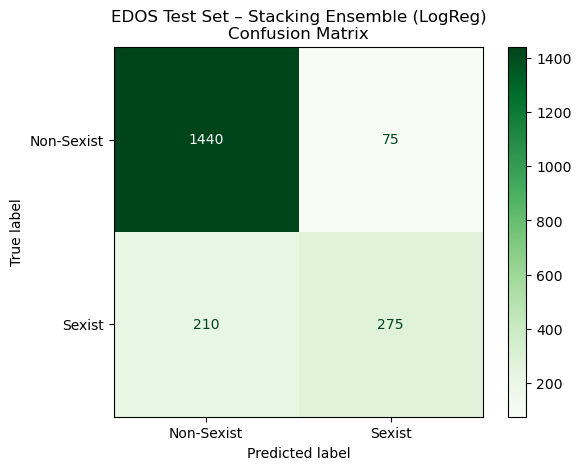

In [219]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svc_class1 = svc_probs[:, 1] if svc_probs.ndim == 2 else svc_probs
glove_class1 = glove_probs.flatten()
bert_class1 = bert_probs.flatten()

X_stack = np.vstack([svc_class1, glove_class1, bert_class1]).T
meta_clf = LogisticRegression()
meta_clf.fit(X_stack, y_true)
y_pred_stack = meta_clf.predict(X_stack)

print("\n=== EDOS: Stacking Ensemble (Logistic Regression) ===")
print(classification_report(y_true, y_pred_stack, target_names=["Non-Sexist", "Sexist"], digits=4))

cm = confusion_matrix(y_true, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Sexist", "Sexist"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Greens", values_format="d")
plt.title("EDOS Test Set – Stacking Ensemble (LogReg)\nConfusion Matrix")
plt.grid(False)
plt.show()


In [393]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svc_class1 = svc_probs[:, 1] if svc_probs.ndim == 2 else svc_probs
glove_class1 = glove_probs.flatten()
bert_class1 = bert_probs.flatten()

X_stack = np.vstack([svc_class1, glove_class1, bert_class1]).T
meta_clf = LogisticRegression()
meta_clf.fit(X_stack, y_true)
y_pred_stack = meta_clf.predict(X_stack)

print("\n=== EDOS: Stacking Ensemble (Logistic Regression) ===")
print(classification_report(y_true, y_pred_stack, target_names=["Non-Sexist", "Sexist"], digits=4))

cm = confusion_matrix(y_true, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Sexist", "Sexist"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Greens", values_format="d")
plt.title("EDOS Test Set – Stacking Ensemble (LogReg)\nConfusion Matrix")
plt.grid(False)
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2015 and the array at index 1 has size 2000

In [221]:
import pandas as pd

df = pd.read_csv("./splits/edos_test.csv")
texts = df["clean_text"].astype(str).tolist()

false_neg_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred_stack)) if true == 1 and pred == 0]

false_neg_df = pd.DataFrame({
    "text": [texts[i] for i in false_neg_indices],
    "true_label": [y_true[i] for i in false_neg_indices],
    "predicted_label": [y_pred_stack[i] for i in false_neg_indices],
    "svc_prob": [svc_class1[i] for i in false_neg_indices],
    "glove_prob": [glove_class1[i] for i in false_neg_indices],
    "bert_prob": [bert_class1[i] for i in false_neg_indices],
})

false_neg_df.to_csv("edos_false_negatives.csv", index=False)
print(f"\n Exported {len(false_neg_df)} false negatives for human review.")



 Exported 210 false negatives for human review.


In [235]:
import pandas as pd

df = pd.read_csv("edos_false_negatives.csv")

df["svc_pred"]   = (df["svc_prob"] > 0.5).astype(int)
df["glove_pred"] = (df["glove_prob"] > 0.5).astype(int)
df["bert_pred"]  = (df["bert_prob"] > 0.5).astype(int)

df["models_predicted_sexist"] = df[["svc_pred", "glove_pred", "bert_pred"]].sum(axis=1)

df["avg_model_confidence"] = df[["svc_prob", "glove_prob", "bert_prob"]].mean(axis=1)

df_sorted = df.sort_values(by="avg_model_confidence", ascending=True)

df_sorted.to_csv("edos_false_negatives_tagged.csv", index=False)
print(f"\n Tagged and saved {len(df)} false negatives with model agreement info.")



 Tagged and saved 210 false negatives with model agreement info.


In [237]:
import pandas as pd

df = pd.read_csv("edos_false_negatives_tagged.csv")

percent = 0.10  # 10%
stratified_sample = df.groupby("models_predicted_sexist", group_keys=False).apply(
    lambda g: g.sample(frac=percent, random_state=42)
).reset_index(drop=True)

stratified_sample.to_csv("edos_false_negatives_stratified_pct.csv", index=False)
print(f"Stratified sample (~{len(stratified_sample)} rows) saved.")


Stratified sample (~21 rows) saved.


/var/folders/x0/50_cl34x1zg9wnnjkygh0svc0000gn/T/ipykernel_1310/452228298.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby("models_predicted_sexist", group_keys=False).apply(


In [241]:
import pandas as pd

df = pd.read_csv("edos_false_negatives_tagged.csv")

sampled = df.groupby("models_predicted_sexist", group_keys=False).apply(
    lambda g: g.sample(n=min(20, len(g)), random_state=42)
).reset_index(drop=True)

sampled.to_csv("edos_false_negatives_stratified_dynamic.csv", index=False)
print(f" Sampled {len(sampled)} rows (max 20 per group) saved to edos_false_negatives_stratified_dynamic.csv")


 Sampled 48 rows (max 20 per group) saved to edos_false_negatives_stratified_dynamic.csv


/var/folders/x0/50_cl34x1zg9wnnjkygh0svc0000gn/T/ipykernel_1310/1444016650.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df.groupby("models_predicted_sexist", group_keys=False).apply(


## DAVIDSON

In [271]:
weights = [0.1, 0.2, 0.8]  
avg_probs = (
    weights[0] * svc_probs +
    weights[1] * glove_probs +
    weights[2] * bert_probs
)

y_pred = np.argmax(avg_probs, axis=1)

print("\n=== DAVIDSON TEST: Weighted Soft Voting Ensemble ===")
print(classification_report(y_true, y_pred, digits=4))


=== DAVIDSON TEST: Weighted Soft Voting Ensemble ===
              precision    recall  f1-score   support

           0     0.5490    0.1958    0.2887       143
           1     0.9281    0.9687    0.9480      1919
           2     0.8682    0.8849    0.8765       417

    accuracy                         0.9100      2479
   macro avg     0.7818    0.6831    0.7044      2479
weighted avg     0.8962    0.9100    0.8979      2479



<Figure size 600x600 with 0 Axes>

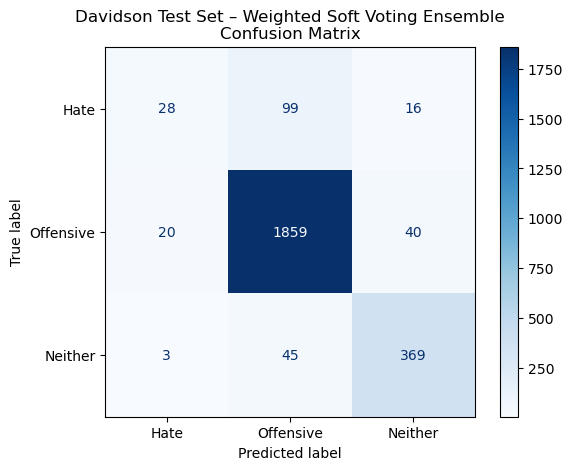

In [273]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["Hate", "Offensive", "Neither"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Davidson Test Set – Weighted Soft Voting Ensemble\nConfusion Matrix")
plt.grid(False)
plt.show()


In [275]:
import pandas as pd
import numpy as np

df = pd.read_csv("./splits/davidson_test.csv")
texts = df["clean_text"].astype(str).tolist()

false_neg_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true in [0, 1] and pred == 2]

svc_class2   = svc_probs[:, 2] if svc_probs.ndim == 2 else svc_probs
glove_class2 = glove_probs[:, 2] if glove_probs.ndim == 2 else glove_probs
bert_class2  = bert_probs[:, 2] if bert_probs.ndim == 2 else bert_probs

fn_df = pd.DataFrame({
    "text": [texts[i] for i in false_neg_indices],
    "true_label": [y_true[i] for i in false_neg_indices],
    "predicted_label": [y_pred[i] for i in false_neg_indices],
    "svc_prob": [svc_class2[i] for i in false_neg_indices],
    "glove_prob": [glove_class2[i] for i in false_neg_indices],
    "bert_prob": [bert_class2[i] for i in false_neg_indices],
})

fn_df["svc_pred"]   = (fn_df["svc_prob"] < 0.5).astype(int)
fn_df["glove_pred"] = (fn_df["glove_prob"] < 0.5).astype(int)
fn_df["bert_pred"]  = (fn_df["bert_prob"] < 0.5).astype(int)
fn_df["models_predicted_sexist"] = fn_df[["svc_pred", "glove_pred", "bert_pred"]].sum(axis=1)
fn_df["avg_model_confidence"] = fn_df[["svc_prob", "glove_prob", "bert_prob"]].mean(axis=1)

fn_df.to_csv("davidson_false_negatives_tagged.csv", index=False)
print(f" Saved {len(fn_df)} false negatives to davidson_false_negatives_tagged.csv")


 Saved 56 false negatives to davidson_false_negatives_tagged.csv


In [277]:
import pandas as pd
import numpy as np

df = pd.read_csv("./splits/davidson_test.csv")
texts = df["clean_text"].astype(str).tolist()

false_neg_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true in [0, 1] and pred == 2]

svc_class2   = svc_probs[:, 2] if svc_probs.ndim == 2 else svc_probs
glove_class2 = glove_probs[:, 2] if glove_probs.ndim == 2 else glove_probs
bert_class2  = bert_probs[:, 2] if bert_probs.ndim == 2 else bert_probs

fn_df = pd.DataFrame({
    "text": [texts[i] for i in false_neg_indices],
    "true_label": [y_true[i] for i in false_neg_indices],
    "predicted_label": [y_pred[i] for i in false_neg_indices],
    "svc_prob": [svc_class2[i] for i in false_neg_indices],
    "glove_prob": [glove_class2[i] for i in false_neg_indices],
    "bert_prob": [bert_class2[i] for i in false_neg_indices],
})

fn_df["svc_pred"]   = (fn_df["svc_prob"] < 0.5).astype(int)
fn_df["glove_pred"] = (fn_df["glove_prob"] < 0.5).astype(int)
fn_df["bert_pred"]  = (fn_df["bert_prob"] < 0.5).astype(int)

fn_df["models_predicted_sexist"] = fn_df[["svc_pred", "glove_pred", "bert_pred"]].sum(axis=1)

print("\n False Negatives by Model Agreement Level:")
print(fn_df["models_predicted_sexist"].value_counts().sort_index())



 False Negatives by Model Agreement Level:
models_predicted_sexist
0    23
1    17
2    14
3     2
Name: count, dtype: int64


In [279]:
import pandas as pd
import numpy as np

df = pd.read_csv("./splits/davidson_test.csv")
texts = df["clean_text"].astype(str).tolist()

false_neg_indices = [
    i for i, (true, pred) in enumerate(zip(y_true, y_pred))
    if (true == 0 and pred in [1, 2]) or  
       (true == 1 and pred == 2)          
]

svc_class_pred   = np.argmax(svc_probs, axis=1)
glove_class_pred = np.argmax(glove_probs, axis=1)
bert_class_pred  = np.argmax(bert_probs, axis=1)

fn_df = pd.DataFrame({
    "text": [texts[i] for i in false_neg_indices],
    "true_label": [y_true[i] for i in false_neg_indices],
    "predicted_label": [y_pred[i] for i in false_neg_indices],
    "svc_prob": [svc_probs[i][y_pred[i]] for i in false_neg_indices],
    "glove_prob": [glove_probs[i][y_pred[i]] for i in false_neg_indices],
    "bert_prob": [bert_probs[i][y_pred[i]] for i in false_neg_indices],
    "svc_pred": [svc_class_pred[i] for i in false_neg_indices],
    "glove_pred": [glove_class_pred[i] for i in false_neg_indices],
    "bert_pred": [bert_class_pred[i] for i in false_neg_indices],
})

fn_df["models_predicted_final"] = (
    (fn_df["svc_pred"] == fn_df["predicted_label"]).astype(int) +
    (fn_df["glove_pred"] == fn_df["predicted_label"]).astype(int) +
    (fn_df["bert_pred"] == fn_df["predicted_label"]).astype(int)
)

fn_df["avg_model_confidence"] = fn_df[["svc_prob", "glove_prob", "bert_prob"]].mean(axis=1)

print("False Negative Types:")
print(fn_df["true_label"].value_counts().rename({0: "Hate", 1: "Offensive"}))
print("\nModel Agreement (on wrong label):")
print(fn_df["models_predicted_final"].value_counts())



False Negative Types:
true_label
Hate         115
Offensive     40
Name: count, dtype: int64

Model Agreement (on wrong label):
models_predicted_final
3    106
2     36
1     13
Name: count, dtype: int64


## HateXplain

<Figure size 600x600 with 0 Axes>

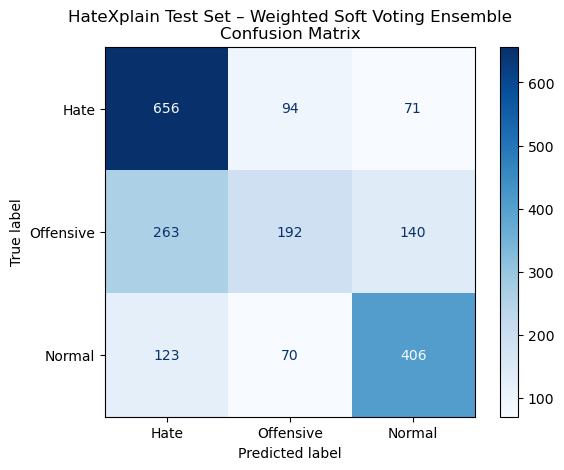

In [294]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["Hate", "Offensive", "Normal"]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("HateXplain Test Set – Weighted Soft Voting Ensemble\nConfusion Matrix")
plt.grid(False)
plt.show()


<Figure size 600x600 with 0 Axes>

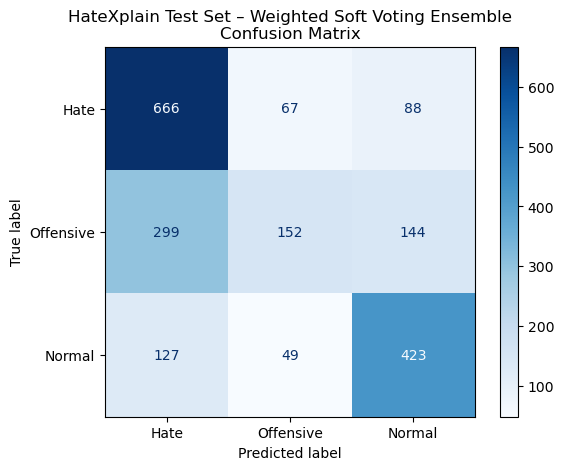

In [383]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["Hate", "Offensive", "Normal"]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("HateXplain Test Set – Weighted Soft Voting Ensemble\nConfusion Matrix")
plt.grid(False)
plt.show()


In [304]:
confused_indices = [
    i for i, (true, pred) in enumerate(zip(y_true, y_pred))
    if (true == 0 and pred == 1) or (true == 1 and pred == 0)
]

confused_df = pd.DataFrame({
    "text": [texts[i] for i in confused_indices],
    "true_label": [y_true[i] for i in confused_indices],
    "predicted_label": [y_pred[i] for i in confused_indices],
})

samples = []
for label, group in confused_df.groupby("true_label"):
    n = min(len(group), 20)
    samples.append(resample(group, n_samples=n, random_state=42, replace=False))

final_df = pd.concat(samples).reset_index(drop=True)

final_df.to_csv("hatexplain_confused_hate_offensive_stratified.csv", index=False)
print(" Saved: hatexplain_confused_hate_offensive_stratified.csv")


 Saved: hatexplain_confused_hate_offensive_stratified.csv


In [306]:
false_neg_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true in [0, 1] and pred == 2]

svc_class2   = svc_probs[:, 2]
glove_class2 = glove_probs[:, 2]
bert_class2  = bert_probs[:, 2]

fn_df = pd.DataFrame({
    "text": [texts[i] for i in false_neg_indices],
    "true_label": [y_true[i] for i in false_neg_indices],
    "predicted_label": [y_pred[i] for i in false_neg_indices],
    "svc_prob": [svc_class2[i] for i in false_neg_indices],
    "glove_prob": [glove_class2[i] for i in false_neg_indices],
    "bert_prob": [bert_class2[i] for i in false_neg_indices],
})

fn_df["svc_pred"]   = (fn_df["svc_prob"] < 0.5).astype(int)
fn_df["glove_pred"] = (fn_df["glove_prob"] < 0.5).astype(int)
fn_df["bert_pred"]  = (fn_df["bert_prob"] < 0.5).astype(int)

fn_df["models_predicted_toxic"] = fn_df[["svc_pred", "glove_pred", "bert_pred"]].sum(axis=1)

print("\n False Negatives by Model Agreement Level (HateXplain):")
print(fn_df["models_predicted_toxic"].value_counts().sort_index())



 False Negatives by Model Agreement Level (HateXplain):
models_predicted_toxic
0    75
1    62
2    66
3    29
Name: count, dtype: int64


In [308]:
import pandas as pd
import numpy as np

df = pd.read_csv("./splits/hatexplain_test.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values  # true labels

svc_class2 = svc_probs[:, 2] if svc_probs.ndim == 2 else svc_probs
glove_class2 = glove_probs[:, 2] if glove_probs.ndim == 2 else glove_probs
bert_class2 = bert_probs[:, 2] if bert_probs.ndim == 2 else bert_probs

false_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

fn_df = pd.DataFrame({
    "text": [texts[i] for i in false_indices],
    "true_label": [y_true[i] for i in false_indices],
    "predicted_label": [y_pred[i] for i in false_indices],
    "svc_prob": [svc_class2[i] for i in false_indices],
    "glove_prob": [glove_class2[i] for i in false_indices],
    "bert_prob": [bert_class2[i] for i in false_indices],
})

fn_df["svc_pred"] = (fn_df["svc_prob"] < 0.5).astype(int)
fn_df["glove_pred"] = (fn_df["glove_prob"] < 0.5).astype(int)
fn_df["bert_pred"] = (fn_df["bert_prob"] < 0.5).astype(int)

fn_df["models_predicted_non_normal"] = fn_df[["svc_pred", "glove_pred", "bert_pred"]].sum(axis=1)
fn_df["avg_model_confidence"] = fn_df[["svc_prob", "glove_prob", "bert_prob"]].mean(axis=1)

fn_df.to_csv("hatexplain_all_misclassifications_tagged.csv", index=False)
print(f" Saved {len(fn_df)} misclassified rows to hatexplain_all_misclassifications_tagged.csv")


 Saved 774 misclassified rows to hatexplain_all_misclassifications_tagged.csv


# Ensembles 2.0 (on ensembles based on the test results) & files saved for error analysis

## EDOS Ensemble (XGB + GloVe-CNN + BERT-CNN

In [15]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)  # shape: (N, 2)

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)  

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy") 
bert_probs = bert_model.predict(bert_X)  

min_len = min(len(xgb_probs), len(glove_probs), len(bert_probs), len(y_true))
xgb_probs = xgb_probs[:min_len]
glove_probs = glove_probs[:min_len]
bert_probs = bert_probs[:min_len]
y_true = y_true[:min_len]

avg_probs = (xgb_probs + glove_probs + bert_probs) / 3
y_pred = (avg_probs[:, 1] > 0.5).astype(int)

print("\n=== EDOS TEST: Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

=== EDOS TEST: Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.8619    0.9683    0.9120      1515
           1     0.8389    0.5155    0.6386       485

    accuracy                         0.8585      2000
   macro avg     0.8504    0.7419    0.7753      2000
weighted avg     0.8563    0.8585    0.8457      2000



In [17]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X)

min_len = min(len(xgb_probs), len(glove_probs), len(bert_probs), len(y_true))
xgb_probs = xgb_probs[:min_len]
glove_probs = glove_probs[:min_len]
bert_probs = bert_probs[:min_len]
y_true = y_true[:min_len]

w1, w2, w3 = 0.2, 0.2, 0.6  
final_probs = (w1 * xgb_probs) + (w2 * glove_probs) + (w3 * bert_probs)
y_pred = (final_probs[:, 1] > 0.5).astype(int)

print("\n=== EDOS TEST: Weighted Soft Voting (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

=== EDOS TEST: Weighted Soft Voting (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.8786    0.9604    0.9177      1515
           1     0.8256    0.5856    0.6852       485

    accuracy                         0.8695      2000
   macro avg     0.8521    0.7730    0.8014      2000
weighted avg     0.8658    0.8695    0.8613      2000



In [19]:
w1, w2, w3 = 0.1, 0.1, 0.8  
final_probs = (w1 * xgb_probs) + (w2 * glove_probs) + (w3 * bert_probs)
y_pred = (final_probs[:, 1] > 0.5).astype(int)

print("\n=== EDOS TEST: Weighted Soft Voting (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


=== EDOS TEST: Weighted Soft Voting (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.8836    0.9518    0.9164      1515
           1     0.8016    0.6082    0.6917       485

    accuracy                         0.8685      2000
   macro avg     0.8426    0.7800    0.8041      2000
weighted avg     0.8637    0.8685    0.8619      2000



In [21]:
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
xgb_class1 = xgb_probs[:, 1]

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)
glove_class1 = glove_probs.flatten() 

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X)
bert_class1 = bert_probs.flatten() 

min_len = min(len(xgb_class1), len(glove_class1), len(bert_class1), len(y_true))
xgb_class1 = xgb_class1[:min_len]
glove_class1 = glove_class1[:min_len]
bert_class1 = bert_class1[:min_len]
y_true = y_true[:min_len]

X_meta = np.vstack([xgb_class1, glove_class1, bert_class1]).T

meta_clf = LogisticRegression()
meta_clf.fit(X_meta, y_true)
y_pred = meta_clf.predict(X_meta)

print("\n=== EDOS TEST: Stacking Ensemble (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== EDOS TEST: Stacking Ensemble (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.8851    0.9558    0.9191      1515
           1     0.8159    0.6124    0.6996       485

    accuracy                         0.8725      2000
   macro avg     0.8505    0.7841    0.8094      2000
weighted avg     0.8683    0.8725    0.8659      2000



In [23]:
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
xgb_class1 = xgb_probs[:, 1]

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)
glove_class1 = glove_probs.flatten()  

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X)
bert_class1 = bert_probs.flatten() 

min_len = min(len(xgb_class1), len(glove_class1), len(bert_class1), len(y_true))
xgb_class1 = xgb_class1[:min_len]
glove_class1 = glove_class1[:min_len]
bert_class1 = bert_class1[:min_len]
y_true = y_true[:min_len]

X_meta = np.vstack([xgb_class1, glove_class1, bert_class1]).T

meta_clf = LogisticRegression()
meta_clf.fit(X_meta, y_true)
y_pred = meta_clf.predict(X_meta)

print("\n=== EDOS TEST: Stacking Ensemble (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== EDOS TEST: Stacking Ensemble (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.8851    0.9558    0.9191      1515
           1     0.8159    0.6124    0.6996       485

    accuracy                         0.8725      2000
   macro avg     0.8505    0.7841    0.8094      2000
weighted avg     0.8683    0.8725    0.8659      2000



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


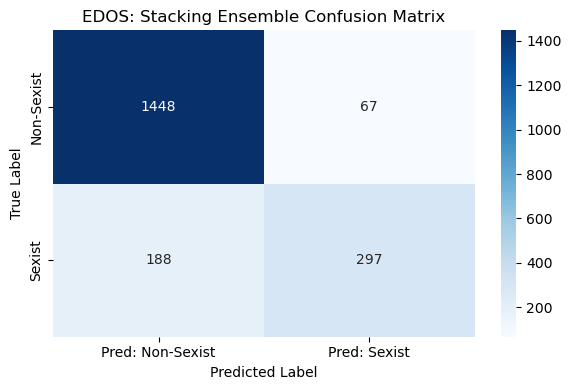

In [13]:
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
xgb_class1 = xgb_probs[:, 1]

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)
glove_class1 = glove_probs.flatten()

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X)
bert_class1 = bert_probs.flatten()

min_len = min(len(xgb_class1), len(glove_class1), len(bert_class1), len(y_true))
xgb_class1 = xgb_class1[:min_len]
glove_class1 = glove_class1[:min_len]
bert_class1 = bert_class1[:min_len]
y_true = y_true[:min_len]

X_meta = np.vstack([xgb_class1, glove_class1, bert_class1]).T

meta_clf = LogisticRegression()
meta_clf.fit(X_meta, y_true)
y_pred = meta_clf.predict(X_meta)

conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Non-Sexist", "Sexist"], columns=["Pred: Non-Sexist", "Pred: Sexist"])
conf_matrix_df.to_csv("edos_stacking_confusion_matrix.csv")

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("EDOS: Stacking Ensemble Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [15]:
plt.savefig('EDOS.png')


<Figure size 640x480 with 0 Axes>

In [17]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
xgb_class1 = xgb_probs[:, 1]
xgb_preds = (xgb_class1 > 0.5).astype(int)

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X).flatten()
glove_preds = (glove_probs > 0.5).astype(int)

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X).flatten()
bert_preds = (bert_probs > 0.5).astype(int)

min_len = min(len(y_true), len(xgb_class1), len(glove_probs), len(bert_probs))
texts = texts[:min_len]
y_true = y_true[:min_len]
xgb_preds = xgb_preds[:min_len]
glove_preds = glove_preds[:min_len]
bert_preds = bert_preds[:min_len]

X_meta = np.vstack([xgb_class1[:min_len], glove_probs[:min_len], bert_probs[:min_len]]).T
meta_clf = LogisticRegression()
meta_clf.fit(X_meta, y_true)
ensemble_preds = meta_clf.predict(X_meta)

false_negatives = (y_true == 1) & (ensemble_preds == 0)

df_fn = pd.DataFrame({
    "text": np.array(texts)[false_negatives],
    "true_label": y_true[false_negatives],
    "ensemble_pred": ensemble_preds[false_negatives],
    "xgb_pred": xgb_preds[false_negatives],
    "glove_pred": glove_preds[false_negatives],
    "bert_pred": bert_preds[false_negatives]
})
df_fn["models_correct"] = df_fn[["xgb_pred", "glove_pred", "bert_pred"]].sum(axis=1)

df_fn.to_csv("edos_false_negatives_analysis.csv", index=False)
print("Saved false negatives analysis to edos_false_negatives_analysis.csv")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Saved false negatives analysis to edos_false_negatives_analysis.csv


In [27]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression

# === Load test data ===
test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
xgb_class1 = xgb_probs[:, 1]
xgb_preds = (xgb_class1 > 0.5).astype(int)

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X).flatten()
glove_preds = (glove_probs > 0.5).astype(int)

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X).flatten()
bert_preds = (bert_probs > 0.5).astype(int)

min_len = min(len(y_true), len(xgb_class1), len(glove_probs), len(bert_probs))
texts = texts[:min_len]
y_true = y_true[:min_len]
xgb_preds = xgb_preds[:min_len]
glove_preds = glove_preds[:min_len]
bert_preds = bert_preds[:min_len]

X_meta = np.vstack([xgb_class1[:min_len], glove_probs[:min_len], bert_probs[:min_len]]).T
meta_clf = LogisticRegression()
meta_clf.fit(X_meta, y_true)
ensemble_preds = meta_clf.predict(X_meta)

false_negatives = (y_true == 1) & (ensemble_preds == 0)
df_fn = pd.DataFrame({
    "text": np.array(texts)[false_negatives],
    "true_label": y_true[false_negatives],
    "ensemble_pred": ensemble_preds[false_negatives],
    "xgb_pred": xgb_preds[false_negatives],
    "glove_pred": glove_preds[false_negatives],
    "bert_pred": bert_preds[false_negatives]
})
df_fn["models_correct"] = df_fn[["xgb_pred", "glove_pred", "bert_pred"]].sum(axis=1)
df_fn.to_csv("edos_false_negatives_analysis.csv", index=False)

false_positives = (y_true == 0) & (ensemble_preds == 1)
df_fp = pd.DataFrame({
    "text": np.array(texts)[false_positives],
    "true_label": y_true[false_positives],
    "ensemble_pred": ensemble_preds[false_positives],
    "xgb_pred": xgb_preds[false_positives],
    "glove_pred": glove_preds[false_positives],
    "bert_pred": bert_preds[false_positives]
})
df_fp["models_correct"] = df_fp[["xgb_pred", "glove_pred", "bert_pred"]].sum(axis=1)
df_fp.to_csv("edos_false_positives_analysis.csv", index=False)

print("Saved both false negatives and false positives analysis CSVs.")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Saved both false negatives and false positives analysis CSVs.


In [19]:
import pandas as pd

df_fn = pd.read_csv("edos_false_negatives_analysis.csv")

group_0_errors = df_fn[df_fn["models_correct"] == 0]

group_0_errors.to_csv("edos_group0_false_negatives.csv", index=False)

print(f"Saved {len(group_0_errors)} Group 0 false negatives to edos_group0_false_negatives.csv")


Saved 126 Group 0 false negatives to edos_group0_false_negatives.csv


In [29]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
xgb_class1 = xgb_probs[:, 1]
xgb_preds = (xgb_class1 > 0.5).astype(int)

glove_model = load_model("./models/edos_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X).flatten()
glove_preds = (glove_probs > 0.5).astype(int)

bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X).flatten()
bert_preds = (bert_probs > 0.5).astype(int)

min_len = min(len(y_true), len(xgb_class1), len(glove_probs), len(bert_probs))
texts = texts[:min_len]
y_true = y_true[:min_len]
xgb_preds = xgb_preds[:min_len]
glove_preds = glove_preds[:min_len]
bert_preds = bert_preds[:min_len]

X_meta = np.vstack([xgb_class1[:min_len], glove_probs[:min_len], bert_probs[:min_len]]).T
meta_clf = LogisticRegression()
meta_clf.fit(X_meta, y_true)
ensemble_preds = meta_clf.predict(X_meta)

false_negatives = (y_true == 1) & (ensemble_preds == 0)
false_positives = (y_true == 0) & (ensemble_preds == 1)

df = pd.DataFrame({
    "text": texts,
    "true_label": y_true,
    "ensemble_pred": ensemble_preds,
    "xgb_pred": xgb_preds,
    "glove_pred": glove_preds,
    "bert_pred": bert_preds
})
df["models_correct"] = df[["xgb_pred", "glove_pred", "bert_pred"]].eq(df["true_label"], axis=0).sum(axis=1)
df["error_type"] = np.where(false_negatives, "False Negative",
                    np.where(false_positives, "False Positive", "Correct"))

error_df = df[df["error_type"] != "Correct"]

error_df.to_csv("edos_model_errors.csv", index=False)
print("Saved combined model error analysis to edos_model_errors.csv")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Saved combined model error analysis to edos_model_errors.csv


In [31]:
all_models_wrong = (
    (xgb_preds != y_true) &
    (glove_preds != y_true) &
    (bert_preds != y_true)
)

all_wrong_df = df[all_models_wrong]

all_wrong_df.to_csv("edos_all_models_failed.csv", index=False)
print("Saved cases where all models predicted incorrectly to edos_all_models_failed.csv")


Saved cases where all models predicted incorrectly to edos_all_models_failed.csv


## DADVIDSON Ensemble (XGB + GloVe-CNN + BERT-CNN)

In [21]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_df = pd.read_csv("./splits/davidson_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values 

xgb = joblib.load("./models/davidson_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/davidson_glove_cnn.h5")
glove_tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/davidson_bert_cnn_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X)

min_len = min(len(xgb_probs), len(glove_probs), len(bert_probs), len(y_true))
xgb_probs = xgb_probs[:min_len]
glove_probs = glove_probs[:min_len]
bert_probs = bert_probs[:min_len]
y_true = y_true[:min_len]

avg_probs = (xgb_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== DAVIDSON TEST: Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

=== DAVIDSON TEST: Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.5926    0.1119    0.1882       143
           1     0.9264    0.9640    0.9448      1919
           2     0.8418    0.9185    0.8784       417

    accuracy                         0.9072      2479
   macro avg     0.7869    0.6648    0.6705      2479
weighted avg     0.8929    0.9072    0.8900      2479



In [23]:
from sklearn.metrics import classification_report
import numpy as np

w1, w2, w3 = 0.2, 0.3, 0.5

weighted_probs = w1 * xgb_probs + w2 * glove_probs + w3 * bert_probs
y_pred_weighted = np.argmax(weighted_probs, axis=1)

print("\n=== DAVIDSON TEST: Weighted Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred_weighted, digits=4))



=== DAVIDSON TEST: Weighted Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.6071    0.1189    0.1988       143
           1     0.9295    0.9625    0.9457      1919
           2     0.8319    0.9257    0.8763       417

    accuracy                         0.9076      2479
   macro avg     0.7895    0.6690    0.6736      2479
weighted avg     0.8945    0.9076    0.8910      2479



In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_meta = np.hstack([xgb_probs, glove_probs, bert_probs]) 

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_meta, y_true)
y_pred_stack = meta_clf.predict(X_meta)

print("\n=== DAVIDSON TEST: Stacking Ensemble (Logistic Regression) ===")
print(classification_report(y_true, y_pred_stack, digits=4))



=== DAVIDSON TEST: Stacking Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

           0     0.5517    0.2238    0.3184       143
           1     0.9345    0.9588    0.9465      1919
           2     0.8518    0.9233    0.8861       417

    accuracy                         0.9104      2479
   macro avg     0.7793    0.7020    0.7170      2479
weighted avg     0.8985    0.9104    0.9001      2479




=== DAVIDSON TEST: Stacking Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

           0     0.5517    0.2238    0.3184       143
           1     0.9345    0.9588    0.9465      1919
           2     0.8518    0.9233    0.8861       417

    accuracy                         0.9104      2479
   macro avg     0.7793    0.7020    0.7170      2479
weighted avg     0.8985    0.9104    0.9001      2479



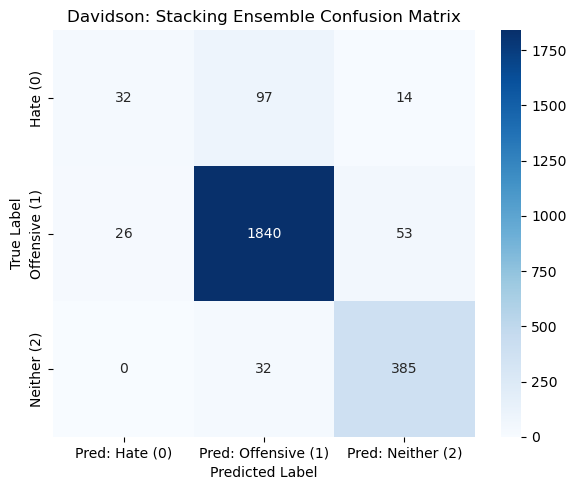

In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_meta = np.hstack([xgb_probs, glove_probs, bert_probs])  

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_meta, y_true)

y_pred_stack = meta_clf.predict(X_meta)

print("\n=== DAVIDSON TEST: Stacking Ensemble (Logistic Regression) ===")
print(classification_report(y_true, y_pred_stack, digits=4))

labels = ["Hate (0)", "Offensive (1)", "Neither (2)"]
conf_matrix = confusion_matrix(y_true, y_pred_stack)
conf_df = pd.DataFrame(conf_matrix, index=labels, columns=[f"Pred: {l}" for l in labels])

conf_df.to_csv("davidson_stacking_confusion_matrix.csv")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues")
plt.title("Davidson: Stacking Ensemble Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [31]:
plt.savefig('Davidson.png')

<Figure size 640x480 with 0 Axes>

In [33]:
false_negatives_idx = np.where(y_true != y_pred_stack)[0]

df = pd.read_csv("./splits/davidson_test.csv")
texts = df["clean_text"].astype(str).tolist()

xgb_preds = np.argmax(xgb_probs, axis=1)
glove_preds = np.argmax(glove_probs, axis=1)
bert_preds = np.argmax(bert_probs, axis=1)

fn_data = []
for i in false_negatives_idx:
    fn_data.append({
        "text": texts[i],
        "true_label": y_true[i],
        "ensemble_pred": y_pred_stack[i],
        "xgb_pred": xgb_preds[i],
        "glove_pred": glove_preds[i],
        "bert_pred": bert_preds[i],
        "models_correct": sum([
            xgb_preds[i] == y_true[i],
            glove_preds[i] == y_true[i],
            bert_preds[i] == y_true[i]
        ])
    })

fn_df = pd.DataFrame(fn_data)

fn_df.to_csv("davidson_false_negatives_analysis.csv", index=False)
print(f"Saved {len(fn_df)} false negatives to davidson_false_negatives_analysis.csv")


Saved 222 false negatives to davidson_false_negatives_analysis.csv


In [35]:
group_0 = fn_df[fn_df["models_correct"] == 0]
group_0.to_csv("davidson_group0_false_negatives.csv", index=False)
print(f"Saved {len(group_0)} group-0 hard false negatives.")


Saved 141 group-0 hard false negatives.


## HateXplain Ensemble (XGB + GloVe-CNN + BERT-CNN)

In [45]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/hatexplain_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/hatexplain_glove_cnn.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/hatexplain_bert_cnn_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X)

min_len = min(len(xgb_probs), len(glove_probs), len(bert_probs), len(y_true))
xgb_probs = xgb_probs[:min_len]
glove_probs = glove_probs[:min_len]
bert_probs = bert_probs[:min_len]
y_true = y_true[:min_len]

avg_probs = (xgb_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== HATEXPLAIN TEST: Soft Voting Ensemble (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.5854    0.8392    0.6897       821
           1     0.5253    0.2622    0.3498       595
           2     0.6802    0.6144    0.6456       599

    accuracy                         0.6020      2015
   macro avg     0.5970    0.5719    0.5617      2015
weighted avg     0.5958    0.6020    0.5762      2015



In [47]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/hatexplain_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/hatexplain_glove_cnn.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/hatexplain_bert_cnn_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(bert_X)

min_len = min(len(xgb_probs), len(glove_probs), len(bert_probs), len(y_true))
xgb_probs = xgb_probs[:min_len]
glove_probs = glove_probs[:min_len]
bert_probs = bert_probs[:min_len]
y_true = y_true[:min_len]

weights = [0.1, 0.1, 0.8]
final_probs = (
    weights[0] * xgb_probs +
    weights[1] * glove_probs +
    weights[2] * bert_probs
)
y_pred = np.argmax(final_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Weighted Voting (XGB + GloVe-CNN + BERT-CNN) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

=== HATEXPLAIN TEST: Weighted Voting (XGB + GloVe-CNN + BERT-CNN) ===
              precision    recall  f1-score   support

           0     0.5976    0.8392    0.6981       821
           1     0.5254    0.2437    0.3330       595
           2     0.6706    0.6561    0.6633       599

    accuracy                         0.6089      2015
   macro avg     0.5979    0.5797    0.5648      2015
weighted avg     0.5980    0.6089    0.5799      2015



In [49]:
from sklearn.linear_model import LogisticRegression

X_meta = np.hstack([
    xgb_probs,
    glove_probs,
    bert_probs
])
meta_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_clf.fit(X_meta, y_true)
y_pred_stack = meta_clf.predict(X_meta)

print("\n=== HATEXPLAIN TEST: Stacking Ensemble (LogReg) ===")
print(classification_report(y_true, y_pred_stack, digits=4))



=== HATEXPLAIN TEST: Stacking Ensemble (LogReg) ===
              precision    recall  f1-score   support

           0     0.6262    0.8100    0.7063       821
           1     0.4881    0.3445    0.4039       595
           2     0.6904    0.6144    0.6502       599

    accuracy                         0.6144      2015
   macro avg     0.6016    0.5896    0.5868      2015
weighted avg     0.6045    0.6144    0.6003      2015



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [51]:
import numpy as np
import pandas as pd

df = pd.read_csv("./splits/hatexplain_test.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

xgb_probs = np.load("hatexplain_xgb_probs.npy")        
glove_probs = np.load("hatexplain_glove_probs.npy")    
bert_probs = np.load("hatexplain_bert_probs.npy")     

min_len = min(len(xgb_probs), len(glove_probs), len(bert_probs), len(y_true))
xgb_probs = xgb_probs[:min_len]
glove_probs = glove_probs[:min_len]
bert_probs = bert_probs[:min_len]
texts = texts[:min_len]
y_true = y_true[:min_len]

X_meta = np.hstack([xgb_probs, glove_probs, bert_probs])

from sklearn.linear_model import LogisticRegression
meta_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_clf.fit(X_meta, y_true)
y_pred_stack = meta_clf.predict(X_meta)

xgb_preds = np.argmax(xgb_probs, axis=1)
glove_preds = np.argmax(glove_probs, axis=1)
bert_preds = np.argmax(bert_probs, axis=1)

false_negatives_idx = np.where(y_true != y_pred_stack)[0]

records = []
for i in false_negatives_idx:
    correct_count = sum([
        xgb_preds[i] == y_true[i],
        glove_preds[i] == y_true[i],
        bert_preds[i] == y_true[i]
    ])
    records.append({
        "text": texts[i],
        "true_label": y_true[i],
        "ensemble_pred": y_pred_stack[i],
        "xgb_pred": xgb_preds[i],
        "glove_pred": glove_preds[i],
        "bert_pred": bert_preds[i],
        "models_correct": correct_count
    })

error_df = pd.DataFrame(records)
error_df.to_csv("hatexplain_false_negatives_analysis.csv", index=False)
print(f"Saved {len(error_df)} false negatives to hatexplain_false_negatives_analysis.csv")

group_0 = error_df[error_df["models_correct"] == 0]
group_0.to_csv("hatexplain_group0_false_negatives.csv", index=False)
print(f"Saved {len(group_0)} hard cases (group 0) to hatexplain_group0_false_negatives.csv")


Saved 764 false negatives to hatexplain_false_negatives_analysis.csv
Saved 501 hard cases (group 0) to hatexplain_group0_false_negatives.csv


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## HateXplain Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM)

In [412]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb_vectorizer, xgb_model = joblib.load("./models/hatexplain_os_xgb.joblib")
xgb_X = xgb_vectorizer.transform(texts)
xgb_probs = xgb_model.predict_proba(xgb_X)

glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/hatexplain_bert_bilstm_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)

avg_probs = (xgb_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Soft Voting Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step

=== HATEXPLAIN TEST: Soft Voting Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.6358    0.7954    0.7067       821
           1     0.5182    0.3345    0.4065       595
           2     0.6639    0.6694    0.6667       599

    accuracy                         0.6218      2015
   macro avg     0.6060    0.5998    0.5933      2015
weighted avg     0.6095    0.6218    0.6062      2015



In [414]:
weighted_probs = (0.5 * xgb_probs) + (0.3 * glove_probs) + (0.2 * bert_probs)
y_pred_weighted = np.argmax(weighted_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Weighted Voting Ensemble ===")
print(classification_report(y_true, y_pred_weighted, digits=4))



=== HATEXPLAIN TEST: Weighted Voting Ensemble ===
              precision    recall  f1-score   support

           0     0.6507    0.7759    0.7078       821
           1     0.4978    0.3731    0.4265       595
           2     0.6610    0.6511    0.6560       599

    accuracy                         0.6199      2015
   macro avg     0.6031    0.6000    0.5968      2015
weighted avg     0.6086    0.6199    0.6093      2015



In [422]:
weighted_probs = (0.3 * xgb_probs) + (0.1 * glove_probs) + (0.6 * bert_probs)
y_pred_weighted = np.argmax(weighted_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Weighted Voting Ensemble ===")
print(classification_report(y_true, y_pred_weighted, digits=4))



=== HATEXPLAIN TEST: Weighted Voting Ensemble ===
              precision    recall  f1-score   support

           0     0.6177    0.7990    0.6968       821
           1     0.5443    0.2891    0.3776       595
           2     0.6499    0.6912    0.6699       599

    accuracy                         0.6164      2015
   macro avg     0.6040    0.5931    0.5814      2015
weighted avg     0.6056    0.6164    0.5945      2015



In [424]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/hatexplain_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/hatexplain_bert_bilstm_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)

meta_X = np.hstack([xgb_probs, glove_probs, bert_probs])

meta_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_clf.fit(meta_X, y_true)  

y_pred = meta_clf.predict(meta_X)

print("\n=== HATEXPLAIN TEST: Stacking Ensemble (XGB + GloVe + BERT) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

=== HATEXPLAIN TEST: Stacking Ensemble (XGB + GloVe + BERT) ===
              precision    recall  f1-score   support

           0     0.6412    0.7966    0.7105       821
           1     0.4926    0.3361    0.3996       595
           2     0.6740    0.6628    0.6684       599

    accuracy                         0.6208      2015
   macro avg     0.6026    0.5985    0.5928      2015
weighted avg     0.6071    0.6208    0.6062      2015



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

=== HATEXPLAIN TEST: Stacking Ensemble (XGB + GloVe + BERT) ===
              precision    recall  f1-score   support

           0     0.6412    0.7966    0.7105       821
           1     0.4926    0.3361    0.3996       595
           2     0.6740    0.6628    0.6684       599

    accuracy                         0.6208      2015
   macro avg     0.6026    0.5985    0.5928      2015
weighted avg     0.6071    0.6208    0.6062      2015



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


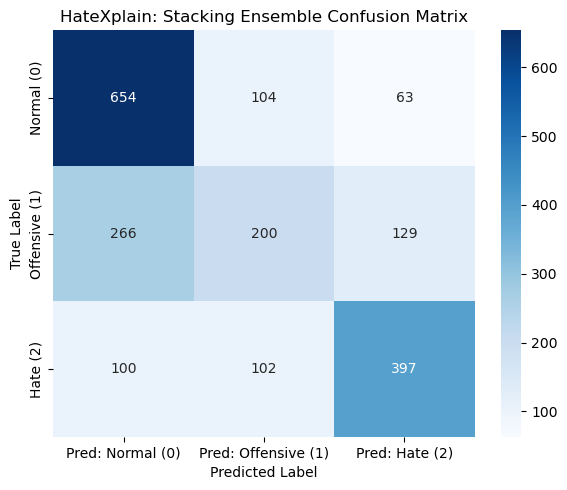

In [426]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/hatexplain_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/hatexplain_bert_bilstm_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)

meta_X = np.hstack([xgb_probs, glove_probs, bert_probs])

meta_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_clf.fit(meta_X, y_true)
y_pred = meta_clf.predict(meta_X)

print("\n=== HATEXPLAIN TEST: Stacking Ensemble (XGB + GloVe + BERT) ===")
print(classification_report(y_true, y_pred, digits=4))

labels = ["Normal (0)", "Offensive (1)", "Hate (2)"]
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=labels, columns=[f"Pred: {l}" for l in labels])

cm_df.to_csv("hatexplain_stacking_confusion_matrix.csv")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("HateXplain: Stacking Ensemble Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [37]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import os

MODEL_NAME = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

df = pd.read_csv("./splits/hatexplain_test.csv")
texts = df["clean_text"].astype(str).tolist()
MAX_LEN = 100

def get_albert_sequence_embeddings(texts, tokenizer, model, max_len=MAX_LEN):
    all_embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting ALBERT embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            seq_embeds = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_embeddings.append(seq_embeds)
    return np.array(all_embeddings)

embeds = get_albert_sequence_embeddings(texts, tokenizer, model, MAX_LEN)
os.makedirs("./models", exist_ok=True)
np.save("./models/hatexplain_albert_embed_test.npy", embeds)
print(" Saved ALBERT test embeddings to ./models/hatexplain_albert_embed_test.npy")


Extracting ALBERT embeddings: 100%|█████████| 2015/2015 [01:35<00:00, 21.14it/s]


 Saved ALBERT test embeddings to ./models/hatexplain_albert_embed_test.npy


In [39]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/hatexplain_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

albert_model = load_model("./models/hatexplain_albert_bilstm_best.h5")
albert_X = np.load("./models/hatexplain_albert_embed_test.npy")
albert_probs = albert_model.predict(albert_X)

avg_probs = (xgb_probs + glove_probs + albert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Soft Voting Ensemble (XGB + GloVe-BiLSTM + ALBERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

=== HATEXPLAIN TEST: Soft Voting Ensemble (XGB + GloVe-BiLSTM + ALBERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.6159    0.8124    0.7006       821
           1     0.5296    0.3008    0.3837       595
           2     0.6633    0.6578    0.6605       599

    accuracy                         0.6154      2015
   macro avg     0.6029    0.5903    0.5816      2015
weighted avg     0.6045    0.6154    0.5951      2015



In [45]:
w_xgb = 0.5
w_glove = 0.3
w_albert = 0.2

weighted_probs = (w_xgb * xgb_probs) + (w_glove * glove_probs) + (w_albert * albert_probs)
y_pred = np.argmax(weighted_probs, axis=1)

print("\n=== HATEXPLAIN TEST: Weighted Soft Voting (XGB + GloVe-BiLSTM + ALBERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


=== HATEXPLAIN TEST: Weighted Soft Voting (XGB + GloVe-BiLSTM + ALBERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.6243    0.8076    0.7042       821
           1     0.5230    0.3244    0.4004       595
           2     0.6627    0.6461    0.6543       599

    accuracy                         0.6169      2015
   macro avg     0.6033    0.5927    0.5863      2015
weighted avg     0.6058    0.6169    0.5997      2015



## Davidson Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM)

In [62]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/davidson_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb = joblib.load("./models/davidson_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)

glove_model = load_model("./models/davidson_glove_bilstm_best.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)

avg_probs = (xgb_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== DAVIDSON TEST: Soft Voting (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step

=== DAVIDSON TEST: Soft Voting (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.6667    0.0699    0.1266       143
           1     0.9032    0.9776    0.9389      1919
           2     0.8682    0.8058    0.8358       417

    accuracy                         0.8963      2479
   macro avg     0.8127    0.6178    0.6338      2479
weighted avg     0.8837    0.8963    0.8747      2479



In [58]:
weights = np.array([0.70, 0.68, 0.73])  
weights = weights / weights.sum()      

ensemble_probs = (
    weights[0] * xgb_probs +
    weights[1] * glove_probs +
    weights[2] * bert_probs
)

y_pred = np.argmax(ensemble_probs, axis=1)

print("\n=== DAVIDSON TEST: Weighted Soft Voting Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


=== DAVIDSON TEST: Weighted Soft Voting Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.6667    0.0839    0.1491       143
           1     0.9044    0.9766    0.9391      1919
           2     0.8663    0.8082    0.8362       417

    accuracy                         0.8967      2479
   macro avg     0.8125    0.6229    0.6415      2479
weighted avg     0.8843    0.8967    0.8762      2479



In [60]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

test_df = pd.read_csv("./splits/davidson_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

xgb_model = joblib.load("./models/davidson_xgb.joblib")
xgb_probs = xgb_model.predict_proba(texts)

glove_model = load_model("./models/davidson_glove_bilstm.h5")
glove_tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(glove_tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)

stacked_features = np.hstack([xgb_probs, glove_probs, bert_probs])

X_stack_train, X_stack_val, y_stack_train, y_stack_val = train_test_split(
    stacked_features, y_true, test_size=0.2, random_state=42
)

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_stack_train, y_stack_train)

y_pred = meta_clf.predict(X_stack_val)

print("\n=== DAVIDSON TEST: Stacking Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===")
print(classification_report(y_stack_val, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

=== DAVIDSON TEST: Stacking Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.4545    0.2083    0.2857        24
           1     0.9453    0.9524    0.9488       399
           2     0.7952    0.9041    0.8462        73

    accuracy                         0.9093       496
   macro avg     0.7317    0.6883    0.6936       496
weighted avg     0.8994    0.9093    0.9016       496



## EDOS Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM)

In [96]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

vectorizer, xgb_model = joblib.load("./models/edos_os_xgb.joblib")
xgb_X = vectorizer.transform(texts)
xgb_probs = xgb_model.predict_proba(xgb_X)

glove_model = load_model("./models/edos_glove_bilstm.h5")
tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/edos_bert_bilstm.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")  

bert_probs = bert_model.predict(bert_X)

avg_probs = (xgb_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== EDOS TEST: Soft Voting Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

=== EDOS TEST: Soft Voting Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.8876    0.8752    0.8814      1515
           1     0.6265    0.6536    0.6398       485

    accuracy                         0.8215      2000
   macro avg     0.7570    0.7644    0.7606      2000
weighted avg     0.8242    0.8215    0.8228      2000



In [98]:
w_xgb = 0.2
w_glove = 0.2
w_bert = 0.6

weighted_probs = (w_xgb * xgb_probs) + (w_glove * glove_probs) + (w_bert * bert_probs)
y_pred = np.argmax(weighted_probs, axis=1)

print("\n=== EDOS TEST: Weighted Soft Voting (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


=== EDOS TEST: Weighted Soft Voting (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.8876    0.8752    0.8814      1515
           1     0.6265    0.6536    0.6398       485

    accuracy                         0.8215      2000
   macro avg     0.7570    0.7644    0.7606      2000
weighted avg     0.8242    0.8215    0.8228      2000



In [81]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

vectorizer, xgb_model = joblib.load("./models/edos_os_xgb.joblib")
xgb_X = vectorizer.transform(texts)
xgb_probs = xgb_model.predict_proba(xgb_X)

glove_model = load_model("./models/edos_glove_bilstm.h5")
tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/edos_bert_bilstm.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")  # shape: (N, 100, 768)
bert_probs = bert_model.predict(bert_X)

stacked_features = np.concatenate([xgb_probs, glove_probs, bert_probs], axis=1)

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(stacked_features, y_true)
y_pred = meta_clf.predict(stacked_features)

print("\n=== EDOS TEST: Stacking Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

=== EDOS TEST: Stacking Ensemble (XGB + GloVe-BiLSTM + BERT-BiLSTM) ===
              precision    recall  f1-score   support

           0     0.8749    0.9512    0.9114      1515
           1     0.7904    0.5753    0.6659       485

    accuracy                         0.8600      2000
   macro avg     0.8326    0.7632    0.7887      2000
weighted avg     0.8544    0.8600    0.8519      2000



# Cross Dataset Evaluation

## Davidson Ensemble on HateXplain

In [100]:
import pandas as pd


df = pd.read_csv("./splits/hatexplain_test.csv")

remap = {2: 0, 1: 1, 0: 2}
df["label"] = df["label"].map(remap)

df.to_csv("./splits/hatexplain_test_remapped_for_davidson.csv", index=False)

print("Saved: hatexplain_test_remapped_for_davidson.csv")


Saved: hatexplain_test_remapped_for_davidson.csv


In [25]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/hatexplain_test_remapped_for_davidson.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy() 
            all_seq.append(last_hidden)
    return np.array(all_seq)  

bert_seq = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save("./models/davidson_bert_embed_test_on_hatexplain.npy", bert_seq)

print("Saved: davidson_bert_embed_test_on_hatexplain.npy (shape:", bert_seq.shape, ")")


Extracting BERT sequence embeddings: 100%|██| 2015/2015 [02:30<00:00, 13.40it/s]


Saved: davidson_bert_embed_test_on_hatexplain.npy (shape: (2015, 100, 768) )


### Soft Voting Ensemble

In [115]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test_remapped_for_davidson.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

svc = joblib.load("./models/davidson_svc_prob.joblib")  
svc_probs = svc.predict_proba(texts)

glove_model = load_model("./models/davidson_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test_on_hatexplain.npy")  
bert_probs = bert_model.predict(bert_X)

avg_probs = (svc_probs + glove_probs + bert_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

print("\n=== CROSS-DATASET TEST: Davidson Ensemble on HateXplain ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

=== CROSS-DATASET TEST: Davidson Ensemble on HateXplain ===
              precision    recall  f1-score   support

           0     0.5257    0.3072    0.3878       599
           1     0.3363    0.5630    0.4211       595
           2     0.5202    0.4239    0.4671       821

    accuracy                         0.4303      2015
   macro avg     0.4607    0.4314    0.4253      2015
weighted avg     0.4675    0.4303    0.4299      2015



In [177]:
weighted_probs = (0.1 * svc_probs) + (0.1 * glove_probs) + (0.8 * bert_probs)
y_pred = np.argmax(weighted_probs, axis=1)

print("\n=== CROSS-DATASET TEST: Weighted Soft Voting (Davidson Ensemble on HateXplain) ===")
print(classification_report(y_true, y_pred, digits=4))

ValueError: operands could not be broadcast together with shapes (2015,3) (2478,3) 

### Stacking Ensemble

In [133]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test_remapped_for_davidson.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

svc = joblib.load("./models/davidson_svc_prob.joblib")
svc_preds = svc.predict(texts)  # shape: (n_samples,)

glove_model = load_model("./models/davidson_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_preds = np.argmax(glove_model.predict(glove_X), axis=1)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test_on_hatexplain.npy")
bert_preds = np.argmax(bert_model.predict(bert_X), axis=1)

meta_X = np.vstack([svc_preds, glove_preds, bert_preds]).T 

meta_clf = LogisticRegression(max_iter=1000, multi_class="multinomial")
meta_clf.fit(meta_X, y_true)  

y_pred = meta_clf.predict(meta_X)

print("\n=== CROSS-DATASET TEST: Stacking Ensemble (Davidson Ensemble on HateXplain) ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step

=== CROSS-DATASET TEST: Stacking Ensemble (Davidson Ensemble on HateXplain) ===
              precision    recall  f1-score   support

           0     0.5506    0.4357    0.4865       599
           1     0.2889    0.0218    0.0406       595
           2     0.4699    0.8563    0.6068       821

    accuracy                         0.4849      2015
   macro avg     0.4365    0.4379    0.3780      2015
weighted avg     0.4405    0.4849    0.4039      2015



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### STACKING (with Probabilities) (best performing)

In [137]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/hatexplain_test_remapped_for_davidson.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

svc = joblib.load("./models/davidson_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)  

glove_model = load_model("./models/davidson_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X) 

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test_on_hatexplain.npy")
bert_probs = bert_model.predict(bert_X)  

meta_X = np.hstack([svc_probs, glove_probs, bert_probs]) 

meta_clf = LogisticRegression(max_iter=1000, multi_class="multinomial")
meta_clf.fit(meta_X, y_true)  

y_pred = meta_clf.predict(meta_X)
print("\n=== STACKING (with Probabilities): Davidson Ensemble on HateXplain ===")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

=== STACKING (with Probabilities): Davidson Ensemble on HateXplain ===
              precision    recall  f1-score   support

           0     0.5543    0.4858    0.5178       599
           1     0.4212    0.2605    0.3219       595
           2     0.5152    0.7040    0.5950       821

    accuracy                         0.5082      2015
   macro avg     0.4969    0.4834    0.4782      2015
weighted avg     0.4990    0.5082    0.4914      2015



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### STACKING (Random Forest)

In [147]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_meta_train = np.load("./models/davidson_meta_X_val.npy")
y_meta_train = np.load("./models/davidson_meta_y_val.npy")

meta_clf = RandomForestClassifier(n_estimators=100, random_state=42)
meta_clf.fit(X_meta_train, y_meta_train)
joblib.dump(meta_clf, "./models/davidson_meta_rf_clf.joblib")

df = pd.read_csv("./splits/hatexplain_test_remapped_for_davidson.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/davidson_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

glove_model = load_model("./models/davidson_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test_on_hatexplain.npy")
bert_probs = bert_model.predict(bert_X)

X_meta_test = np.hstack([svc_probs, glove_probs, bert_probs])

y_pred = meta_clf.predict(X_meta_test)
print("\n STACKING (Random Forest): Trained on Davidson-val, Tested on HateXplain")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

 STACKING (Random Forest): Trained on Davidson-val, Tested on HateXplain
              precision    recall  f1-score   support

           0     0.4788    0.4157    0.4450       599
           1     0.3234    0.4941    0.3910       595
           2     0.5256    0.3752    0.4378       821

    accuracy                         0.4223      2015
   macro avg     0.4426    0.4283    0.4246      2015
weighted avg     0.4520    0.4223    0.4261      2015



### STACKING (MLPClassifier)

In [151]:
import numpy as np
import pandas as pd
import joblib
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_meta_train = np.load("./models/davidson_meta_X_val.npy")
y_meta_train = np.load("./models/davidson_meta_y_val.npy")

meta_clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
meta_clf.fit(X_meta_train, y_meta_train)
joblib.dump(meta_clf, "./models/davidson_meta_mlp_clf.joblib")

df = pd.read_csv("./splits/hatexplain_test_remapped_for_davidson.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/davidson_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

glove_model = load_model("./models/davidson_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test_on_hatexplain.npy")
bert_probs = bert_model.predict(bert_X)

X_meta_test = np.hstack([svc_probs, glove_probs, bert_probs])

y_pred = meta_clf.predict(X_meta_test)
print("\n STACKING (MLPClassifier): Trained on Davidson-val, Tested on HateXplain")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

 STACKING (MLPClassifier): Trained on Davidson-val, Tested on HateXplain
              precision    recall  f1-score   support

           0     0.4512    0.3856    0.4158       599
           1     0.3337    0.5109    0.4037       595
           2     0.5439    0.3922    0.4558       821

    accuracy                         0.4253      2015
   macro avg     0.4429    0.4296    0.4251      2015
weighted avg     0.4543    0.4253    0.4285      2015



### OPTIMAL WEIGHTED VOTING

In [155]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

val_df = pd.read_csv("./splits/davidson_val.csv")
texts = val_df["clean_text"].astype(str).tolist()
y_true = val_df["label"].astype(int).values

svc = joblib.load("./models/davidson_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

glove_model = load_model("./models/davidson_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_val.npy")
bert_probs = bert_model.predict(bert_X)

best_f1 = 0
best_weights = (1/3, 1/3, 1/3)
for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 < 0 or w3 > 1:
            continue
        weighted_probs = (w1 * svc_probs) + (w2 * glove_probs) + (w3 * bert_probs)
        y_pred = np.argmax(weighted_probs, axis=1)
        f1 = f1_score(y_true, y_pred, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_weights = (w1, w2, w3)

print(f" Best Weights (SVC, GloVe, BERT): {best_weights} with Macro F1 = {best_f1:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
 Best Weights (SVC, GloVe, BERT): (0.4, 0.0, 0.6) with Macro F1 = 0.7292


In [163]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

df = pd.read_csv("./splits/hatexplain_test_remapped_for_davidson.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/davidson_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

bert_model = load_model("./models/davidson_bert_bilstm_best.h5")
bert_X = np.load("./models/davidson_bert_embed_test_on_hatexplain.npy")
bert_probs = bert_model.predict(bert_X)

weighted_probs = (0.4 * svc_probs) + (0.6 * bert_probs)
y_pred = np.argmax(weighted_probs, axis=1)

print("\n OPTIMAL WEIGHTED VOTING: Davidson Ensemble on HateXplain")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

 OPTIMAL WEIGHTED VOTING: Davidson Ensemble on HateXplain
              precision    recall  f1-score   support

           0     0.5011    0.3706    0.4261       599
           1     0.3380    0.5630    0.4224       595
           2     0.5353    0.3788    0.4437       821

    accuracy                         0.4308      2015
   macro avg     0.4582    0.4375    0.4307      2015
weighted avg     0.4669    0.4308    0.4322      2015



## HateXplain Ensemble on Davidson

In [187]:
import pandas as pd

df = pd.read_csv("./splits/davidson_test.csv")

remap = {0: 2, 1: 1, 2: 0}
df["label"] = df["label"].map(remap)

df.to_csv("./splits/davidson_test_remapped_for_hatexplain.csv", index=False)

print(" Saved: davidson_test_remapped_for_hatexplain.csv")


 Saved: davidson_test_remapped_for_hatexplain.csv


In [215]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/davidson_test_remapped_for_hatexplain.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

svc = joblib.load("./models/hatexplain_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/hatexplain_bert_bilstm_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_on_davidson.npy") 
bert_probs = bert_model.predict(bert_X)

weighted_probs = (0.8 * svc_probs) + (0.3 * glove_probs) + (0.2 * bert_probs)
y_pred = np.argmax(weighted_probs, axis=1)

print("\n=== CROSS-DATASET TEST: HateXplain Ensemble on Davidson ===")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

=== CROSS-DATASET TEST: HateXplain Ensemble on Davidson ===
              precision    recall  f1-score   support

           0     0.2498    0.8777    0.3889       417
           1     0.9000    0.4268    0.5790      1919
           2     0.3462    0.2517    0.2915       143

    accuracy                         0.4925      2479
   macro avg     0.4987    0.5187    0.4198      2479
weighted avg     0.7587    0.4925    0.5304      2479



In [201]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/davidson_test_remapped_for_hatexplain.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            all_seq.append(last_hidden)
    return np.array(all_seq)

bert_embed = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save("./models/hatexplain_bert_embed_on_davidson.npy", bert_embed)

print(" Saved: ./models/hatexplain_bert_embed_on_davidson.npy with shape", bert_embed.shape)


Extracting BERT sequence embeddings: 100%|██| 2479/2479 [02:01<00:00, 20.38it/s]


 Saved: ./models/hatexplain_bert_embed_on_davidson.npy with shape (2479, 100, 768)


In [219]:
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

df = pd.read_csv("./splits/davidson_test_remapped_for_hatexplain.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/hatexplain_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)

glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)

bert_model = load_model("./models/hatexplain_bert_bilstm_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_on_davidson.npy")
bert_probs = bert_model.predict(bert_X)

X_meta = np.hstack([svc_probs, glove_probs, bert_probs]) 

meta_clf = LogisticRegression(max_iter=1000, multi_class="multinomial")
meta_clf.fit(X_meta, y_true)
y_pred = meta_clf.predict(X_meta)

print("\n STACKING (Probabilities): HateXplain-Trained Ensemble on Davidson")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

 STACKING (Probabilities): HateXplain-Trained Ensemble on Davidson
              precision    recall  f1-score   support

           0     0.6642    0.2182    0.3285       417
           1     0.8089    0.9729    0.8834      1919
           2     0.5000    0.1189    0.1921       143

    accuracy                         0.7967      2479
   macro avg     0.6577    0.4367    0.4680      2479
weighted avg     0.7668    0.7967    0.7502      2479



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Training on Davidson to test on EDOS

In [223]:
import pandas as pd

binary_map = {0: 1, 1: 1, 2: 0}

train_df = pd.read_csv("./splits/davidson_train.csv")
train_df["label"] = train_df["label"].map(binary_map)
train_df.to_csv("./splits/davidson_train_binary.csv", index=False)

val_df = pd.read_csv("./splits/davidson_val.csv")
val_df["label"] = val_df["label"].map(binary_map)
val_df.to_csv("./splits/davidson_val_binary.csv", index=False)

test_df = pd.read_csv("./splits/davidson_test.csv")
test_df["label"] = test_df["label"].map(binary_map)
test_df.to_csv("./splits/davidson_test_binary.csv", index=False)

print(" Davidson binary files saved:")
print(" - davidson_train_binary.csv")
print(" - davidson_val_binary.csv")
print(" - davidson_test_binary.csv")


 Davidson binary files saved:
 - davidson_train_binary.csv
 - davidson_val_binary.csv
 - davidson_test_binary.csv


In [225]:
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

train_df = pd.read_csv("./splits/davidson_train_binary.csv")
val_df = pd.read_csv("./splits/davidson_val_binary.csv")
X_train, y_train = train_df["clean_text"], train_df["label"]
X_val, y_val = val_df["clean_text"], val_df["label"]

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("svc", SVC(probability=True, kernel="linear", C=1.0, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

joblib.dump(pipeline, "./models/davidson_binary_svc_prob.joblib")
print("\n TF-IDF + SVC (Binary):")
print(classification_report(y_val, y_pred, digits=4))



 TF-IDF + SVC (Binary):
              precision    recall  f1-score   support

           0     0.8402    0.8341    0.8372       416
           1     0.9666    0.9680    0.9673      2062

    accuracy                         0.9455      2478
   macro avg     0.9034    0.9011    0.9022      2478
weighted avg     0.9454    0.9455    0.9454      2478



In [227]:
import pandas as pd

test_df = pd.read_csv("./splits/davidson_test.csv")

binary_map = {0: 1, 1: 1, 2: 0}
test_df["label"] = test_df["label"].map(binary_map)

test_df.to_csv("./splits/davidson_test_binary.csv", index=False)
print("Saved remapped binary Davidson test set: davidson_test_binary.csv")


Saved remapped binary Davidson test set: davidson_test_binary.csv


In [229]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/davidson_test_binary.csv")
X_test, y_test = test_df["clean_text"], test_df["label"]

pipeline = joblib.load("./models/davidson_binary_svc_prob.joblib")

y_pred = pipeline.predict(X_test)
print("\nTF-IDF + SVC (Binary) on Davidson Test:")
print(classification_report(y_test, y_pred, digits=4))



TF-IDF + SVC (Binary) on Davidson Test:
              precision    recall  f1-score   support

           0     0.8582    0.8561    0.8571       417
           1     0.9709    0.9714    0.9712      2062

    accuracy                         0.9520      2479
   macro avg     0.9145    0.9138    0.9141      2479
weighted avg     0.9520    0.9520    0.9520      2479



In [233]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

MAX_LEN = 100
MAX_WORDS = 10000
EMBED_DIM = 100
EPOCHS = 10
BATCH_SIZE = 32
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt"  

train_df = pd.read_csv("./splits/davidson_train_binary.csv")
val_df = pd.read_csv("./splits/davidson_val_binary.csv")

texts_train = train_df["clean_text"].tolist()
texts_val = val_df["clean_text"].tolist()
y_train = train_df["label"].values
y_val = val_df["label"].values

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts_train)
X_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=MAX_LEN)
X_val = pad_sequences(tokenizer.texts_to_sequences(texts_val), maxlen=MAX_LEN)
word_index = tokenizer.word_index

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBED_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

model = Sequential([
    Embedding(len(word_index) + 1, EMBED_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

model.save("./models/davidson_binary_glove_bilstm.h5")
joblib.dump(tokenizer, "./models/davidson_binary_glove_tokenizer.joblib")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
620/620 - 21s - 33ms/step - accuracy: 0.8984 - loss: 0.2419 - val_accuracy: 0.9205 - val_loss: 0.1873
Epoch 2/10
620/620 - 21s - 34ms/step - accuracy: 0.9253 - loss: 0.1691 - val_accuracy: 0.9262 - val_loss: 0.1683
Epoch 3/10
620/620 - 21s - 34ms/step - accuracy: 0.9338 - loss: 0.1516 - val_accuracy: 0.9282 - val_loss: 0.1624
Epoch 4/10
620/620 - 21s - 34ms/step - accuracy: 0.9426 - loss: 0.1382 - val_accuracy: 0.9346 - val_loss: 0.1581
Epoch 5/10
620/620 - 21s - 34ms/step - accuracy: 0.9473 - loss: 0.1280 - val_accuracy: 0.9358 - val_loss: 0.1564
Epoch 6/10
620/620 - 21s - 34ms/step - accuracy: 0.9538 - loss: 0.1153 - val_accuracy: 0.9342 - val_loss: 0.1552
Epoch 7/10
620/620 - 21s - 34ms/step - accuracy: 0.9571 - loss: 0.1071 - val_accuracy: 0.9383 - val_loss: 0.1591
Epoch 8/10
620/620 - 21s - 34ms/step - accuracy: 0.9623 - loss: 0.0982 - val_accuracy: 0.9374 - val_loss: 0.1627
Epoch 9/10
620/620 - 21s - 34ms/step - accuracy: 0.9667 - loss: 0.0862 - val_accuracy: 0.9350 - 

['./models/davidson_binary_glove_tokenizer.joblib']

In [235]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import joblib
import numpy as np

df = pd.read_csv("./splits/davidson_val_binary.csv")  
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

tokenizer = joblib.load("./models/davidson_binary_glove_tokenizer.joblib")
model = load_model("./models/davidson_binary_glove_bilstm.h5")

X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)

y_probs = model.predict(X)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

print("\n GloVe + BiLSTM (Binary) on Davidson Val/Test:")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

 GloVe + BiLSTM (Binary) on Davidson Val/Test:
              precision    recall  f1-score   support

           0     0.8504    0.7380    0.7902       416
           1     0.9485    0.9738    0.9610      2062

    accuracy                         0.9342      2478
   macro avg     0.8995    0.8559    0.8756      2478
weighted avg     0.9320    0.9342    0.9323      2478



In [237]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import joblib
import numpy as np

df = pd.read_csv("./splits/davidson_test_binary.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

tokenizer = joblib.load("./models/davidson_binary_glove_tokenizer.joblib")
model = load_model("./models/davidson_binary_glove_bilstm.h5")

X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)

y_probs = model.predict(X)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

print("\n GloVe + BiLSTM (Binary) on Davidson Test Set:")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 GloVe + BiLSTM (Binary) on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.8447    0.7698    0.8055       417
           1     0.9543    0.9714    0.9627      2062

    accuracy                         0.9375      2479
   macro avg     0.8995    0.8706    0.8841      2479
weighted avg     0.9358    0.9375    0.9363      2479



In [239]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

train_df = pd.read_csv("./splits/davidson_train_binary.csv")
val_df = pd.read_csv("./splits/davidson_val_binary.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val = val_df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased"  
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy() 
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_bert_sequence_embeddings(texts_train, tokenizer, model)
X_val = get_bert_sequence_embeddings(texts_val, tokenizer, model)
np.save("./models/davidson_bert_embed_train_seq.npy", X_train)
np.save("./models/davidson_bert_embed_val_seq.npy", X_val)

print(" Saved: BERT sequence embeddings for Davidson train and val")


Extracting BERT sequence embeddings: 100%|█| 19826/19826 [18:29<00:00, 17.87it/s
Extracting BERT sequence embeddings: 100%|██| 2478/2478 [02:14<00:00, 18.48it/s]


 Saved: BERT sequence embeddings for Davidson train and val


In [191]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

X_train = np.load("./models/davidson_bert_embed_train_seq.npy")  
X_val = np.load("./models/davidson_bert_embed_val_seq.npy")

y_train = pd.read_csv("./splits/davidson_train_binary.csv")["label"].values
y_val = pd.read_csv("./splits/davidson_val_binary.csv")["label"].values

model = Sequential([
    Bidirectional(LSTM(64), input_shape=(100, 768)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=32, callbacks=[early_stop], verbose=2)

y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

print("\n BERT + BiLSTM (Binary) on Davidson Validation:")
print(classification_report(y_val, y_pred, digits=4))

model.save("./models/davidson_binary_bert_bilstm.h5")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
620/620 - 81s - 130ms/step - accuracy: 0.9097 - loss: 0.2206 - val_accuracy: 0.9274 - val_loss: 0.1692
Epoch 2/10
620/620 - 64s - 104ms/step - accuracy: 0.9429 - loss: 0.1393 - val_accuracy: 0.9399 - val_loss: 0.1385
Epoch 3/10
620/620 - 69s - 111ms/step - accuracy: 0.9562 - loss: 0.1118 - val_accuracy: 0.9459 - val_loss: 0.1281
Epoch 4/10
620/620 - 44s - 71ms/step - accuracy: 0.9637 - loss: 0.0937 - val_accuracy: 0.9403 - val_loss: 0.1467
Epoch 5/10
620/620 - 45s - 73ms/step - accuracy: 0.9706 - loss: 0.0790 - val_accuracy: 0.9431 - val_loss: 0.1233
Epoch 6/10
620/620 - 47s - 75ms/step - accuracy: 0.9785 - loss: 0.0599 - val_accuracy: 0.9427 - val_loss: 0.1463
Epoch 7/10
620/620 - 42s - 68ms/step - accuracy: 0.9823 - loss: 0.0487 - val_accuracy: 0.9451 - val_loss: 0.1666
Epoch 8/10
620/620 - 44s - 71ms/step - accuracy: 0.9870 - loss: 0.0379 - val_accuracy: 0.9342 - val_loss: 0.2025
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step



 BERT + BiLSTM (Binary) on Davidson Validation:
              precision    recall  f1-score   support

           0     0.8266    0.8365    0.8315       416
           1     0.9669    0.9646    0.9658      2062

    accuracy                         0.9431      2478
   macro avg     0.8968    0.9006    0.8987      2478
weighted avg     0.9434    0.9431    0.9432      2478



In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

X_test = np.load("./models/davidson_bert_embed_test_seq.npy")
y_test = pd.read_csv("./splits/davidson_test_binary.csv")["label"].values

model = load_model("./models/davidson_binary_bert_bilstm.h5")

y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

print("\n BERT + BiLSTM (Binary) on Davidson Test Set:")
print(classification_report(y_test, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

 BERT + BiLSTM (Binary) on Davidson Test Set:
              precision    recall  f1-score   support

           0     0.8491    0.8633    0.8561       417
           1     0.9723    0.9690    0.9706      2062

    accuracy                         0.9512      2479
   macro avg     0.9107    0.9161    0.9134      2479
weighted avg     0.9515    0.9512    0.9514      2479



In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/davidson_test_binary.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased"  
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT test embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # (100, 768)
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_test = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save("./models/davidson_bert_embed_test_seq.npy", X_test)

print(" Saved: ./models/davidson_bert_embed_test_seq.npy with shape", X_test.shape)


Extracting BERT test embeddings: 100%|██████| 2479/2479 [02:03<00:00, 20.14it/s]


 Saved: ./models/davidson_bert_embed_test_seq.npy with shape (2479, 100, 768)


In [9]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

test_df = pd.read_csv("./splits/davidson_test_binary.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

svc = joblib.load("./models/davidson_binary_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)[:, 1] 

glove_model = load_model("./models/davidson_binary_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_binary_glove_tokenizer.joblib")
X_glove = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(X_glove).reshape(-1)

bert_model = load_model("./models/davidson_binary_bert_bilstm.h5")
X_bert = np.load("./models/davidson_bert_embed_test_seq.npy")
bert_probs = bert_model.predict(X_bert).reshape(-1)

svc_weight = 0.3
glove_weight = 0.3
bert_weight = 0.4

ensemble_probs = (
    svc_weight * svc_probs +
    glove_weight * glove_probs +
    bert_weight * bert_probs
)

y_pred = (ensemble_probs > 0.5).astype(int)

print("\n SOFT VOTING ENSEMBLE (Binary): Davidson Test Set")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

 SOFT VOTING ENSEMBLE (Binary): Davidson Test Set
              precision    recall  f1-score   support

           0     0.8819    0.8777    0.8798       417
           1     0.9753    0.9762    0.9758      2062

    accuracy                         0.9597      2479
   macro avg     0.9286    0.9270    0.9278      2479
weighted avg     0.9596    0.9597    0.9596      2479



In [15]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

edos_df = pd.read_csv("./splits/edos_test.csv")
texts = edos_df["clean_text"].astype(str).tolist()
y_true = edos_df["label"].astype(int).values

svc = joblib.load("./models/davidson_binary_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)[:, 1]  

glove_model = load_model("./models/davidson_binary_glove_bilstm.h5")
tokenizer = joblib.load("./models/davidson_binary_glove_tokenizer.joblib")
X_glove = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(X_glove).reshape(-1)

bert_model = load_model("./models/davidson_binary_bert_bilstm.h5")
X_bert = np.load("./models/davidson_bert_embed_on_edos_test_seq.npy")
bert_probs = bert_model.predict(X_bert).reshape(-1)

ensemble_probs = (
    0.3 * svc_probs +
    0.3 * glove_probs +
    0.4 * bert_probs
)
y_pred = (ensemble_probs > 0.5).astype(int)

print("\n CROSS-DATASET: Davidson-Trained Ensemble on EDOS Test")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

 CROSS-DATASET: Davidson-Trained Ensemble on EDOS Test
              precision    recall  f1-score   support

           0     0.8836    0.3307    0.4813      1515
           1     0.2924    0.8639    0.4369       485

    accuracy                         0.4600      2000
   macro avg     0.5880    0.5973    0.4591      2000
weighted avg     0.7402    0.4600    0.4705      2000



In [13]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/edos_test.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased"  
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings (EDOS)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy() 
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_bert = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save("./models/davidson_bert_embed_on_edos_test_seq.npy", X_bert)

print(" Saved: davidson_bert_embed_on_edos_test_seq.npy with shape", X_bert.shape)


Extracting BERT embeddings (EDOS): 100%|████| 2000/2000 [01:44<00:00, 19.12it/s]


 Saved: davidson_bert_embed_on_edos_test_seq.npy with shape (2000, 100, 768)


## Training of HateXplain to test on EDOS

In [24]:
import pandas as pd

train_df = pd.read_csv("./splits/hatexplain_train.csv")
train_df["label"] = train_df["label"].map({0: 0, 1: 1, 2: 1})
train_df.to_csv("./splits/hatexplain_train_binary.csv", index=False)

val_df = pd.read_csv("./splits/hatexplain_val.csv")
val_df["label"] = val_df["label"].map({0: 0, 1: 1, 2: 1})
val_df.to_csv("./splits/hatexplain_val_binary.csv", index=False)

test_df = pd.read_csv("./splits/hatexplain_test.csv")
test_df["label"] = test_df["label"].map({0: 0, 1: 1, 2: 1})
test_df.to_csv("./splits/hatexplain_test_binary.csv", index=False)

print("Saved HateXplain binary splits:")
print(" - hatexplain_train_binary.csv")
print(" - hatexplain_val_binary.csv")
print(" - hatexplain_test_binary.csv")


Saved HateXplain binary splits:
 - hatexplain_train_binary.csv
 - hatexplain_val_binary.csv
 - hatexplain_test_binary.csv


In [26]:
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

train_df = pd.read_csv("./splits/hatexplain_train_binary.csv")
val_df = pd.read_csv("./splits/hatexplain_val_binary.csv")
X_train, y_train = train_df["clean_text"], train_df["label"]
X_val, y_val = val_df["clean_text"], val_df["label"]

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("svc", SVC(probability=True, kernel="linear", C=1.0, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

joblib.dump(pipeline, "./models/hatexplain_binary_svc_prob.joblib")
print("\n TF-IDF + SVC (Binary) on HateXplain:")
print(classification_report(y_val, y_pred, digits=4))



 TF-IDF + SVC (Binary) on HateXplain:
              precision    recall  f1-score   support

           0     0.6513    0.6029    0.6262       821
           1     0.7402    0.7781    0.7587      1194

    accuracy                         0.7067      2015
   macro avg     0.6958    0.6905    0.6924      2015
weighted avg     0.7040    0.7067    0.7047      2015



In [36]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import joblib

MAX_LEN = 100
MAX_WORDS = 10000
EMBED_DIM = 100
EPOCHS = 10
BATCH_SIZE = 32
GLOVE_PATH = "/Users/sandyajaleshkumar/Desktop/Practicum/glove.6B/glove.6B.100d.txt" 

train_df = pd.read_csv("./splits/hatexplain_train_binary.csv")
val_df = pd.read_csv("./splits/hatexplain_val_binary.csv")

texts_train = train_df["clean_text"].tolist()
texts_val = val_df["clean_text"].tolist()
y_train = train_df["label"].values
y_val = val_df["label"].values

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts_train)
X_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=MAX_LEN)
X_val = pad_sequences(tokenizer.texts_to_sequences(texts_val), maxlen=MAX_LEN)
word_index = tokenizer.word_index

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBED_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

model = Sequential([
    Embedding(len(word_index) + 1, EMBED_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

model.save("./models/hatexplain_binary_glove_bilstm.h5")
joblib.dump(tokenizer, "./models/hatexplain_binary_glove_tokenizer.joblib")


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


504/504 - 20s - 39ms/step - accuracy: 0.6491 - loss: 0.6189 - val_accuracy: 0.6998 - val_loss: 0.5805
Epoch 2/10
504/504 - 18s - 36ms/step - accuracy: 0.7049 - loss: 0.5631 - val_accuracy: 0.7097 - val_loss: 0.5659
Epoch 3/10
504/504 - 18s - 35ms/step - accuracy: 0.7188 - loss: 0.5475 - val_accuracy: 0.7107 - val_loss: 0.5624
Epoch 4/10
504/504 - 18s - 35ms/step - accuracy: 0.7282 - loss: 0.5339 - val_accuracy: 0.7176 - val_loss: 0.5564
Epoch 5/10
504/504 - 18s - 35ms/step - accuracy: 0.7356 - loss: 0.5210 - val_accuracy: 0.7345 - val_loss: 0.5513
Epoch 6/10
504/504 - 18s - 36ms/step - accuracy: 0.7475 - loss: 0.5058 - val_accuracy: 0.7241 - val_loss: 0.5507
Epoch 7/10
504/504 - 17s - 35ms/step - accuracy: 0.7547 - loss: 0.4944 - val_accuracy: 0.7151 - val_loss: 0.5544
Epoch 8/10
504/504 - 19s - 37ms/step - accuracy: 0.7668 - loss: 0.4802 - val_accuracy: 0.7206 - val_loss: 0.5620
Epoch 9/10
504/504 - 19s - 37ms/step - accuracy: 0.7778 - loss: 0.4653 - val_accuracy: 0.7325 - val_loss: 0

['./models/hatexplain_binary_glove_tokenizer.joblib']

In [38]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import joblib
import numpy as np

val_df = pd.read_csv("./splits/hatexplain_val_binary.csv")
texts = val_df["clean_text"].astype(str).tolist()
y_true = val_df["label"].astype(int).values

model = load_model("./models/hatexplain_binary_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_binary_glove_tokenizer.joblib")

X_val = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)

y_probs = model.predict(X_val)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

print("\n GloVe + BiLSTM (Binary) on HateXplain Validation Set:")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 GloVe + BiLSTM (Binary) on HateXplain Validation Set:
              precision    recall  f1-score   support

           0     0.6695    0.6784    0.6739       821
           1     0.7768    0.7697    0.7732      1194

    accuracy                         0.7325      2015
   macro avg     0.7232    0.7241    0.7236      2015
weighted avg     0.7331    0.7325    0.7328      2015



In [40]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

train_df = pd.read_csv("./splits/hatexplain_train_binary.csv")
val_df = pd.read_csv("./splits/hatexplain_val_binary.csv")

texts_train = train_df["clean_text"].astype(str).tolist()
texts_val = val_df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT sequence embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # shape: (100, 768)
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_train = get_bert_sequence_embeddings(texts_train, tokenizer, model)
X_val = get_bert_sequence_embeddings(texts_val, tokenizer, model)
np.save("./models/hatexplain_bert_embed_train_seq.npy", X_train)
np.save("./models/hatexplain_bert_embed_val_seq.npy", X_val)

print("Saved BERT sequence embeddings for HateXplain train and val.")


Extracting BERT sequence embeddings: 100%|█| 16118/16118 [20:55<00:00, 12.84it/s
Extracting BERT sequence embeddings: 100%|██| 2015/2015 [03:06<00:00, 10.79it/s]


Saved BERT sequence embeddings for HateXplain train and val.


In [42]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

X_train = np.load("./models/hatexplain_bert_embed_train_seq.npy")
X_val = np.load("./models/hatexplain_bert_embed_val_seq.npy")

y_train = pd.read_csv("./splits/hatexplain_train_binary.csv")["label"].values
y_val = pd.read_csv("./splits/hatexplain_val_binary.csv")["label"].values

model = Sequential([
    Bidirectional(LSTM(64), input_shape=(100, 768)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=10, batch_size=32,
          callbacks=[early_stop], verbose=2)

y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

print("\n BERT + BiLSTM (Binary) on HateXplain Validation Set:")
print(classification_report(y_val, y_pred, digits=4))

model.save("./models/hatexplain_binary_bert_bilstm.h5")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
504/504 - 49s - 98ms/step - accuracy: 0.6722 - loss: 0.6029 - val_accuracy: 0.7201 - val_loss: 0.5498
Epoch 2/10
504/504 - 47s - 94ms/step - accuracy: 0.7250 - loss: 0.5400 - val_accuracy: 0.7360 - val_loss: 0.5312
Epoch 3/10
504/504 - 95s - 188ms/step - accuracy: 0.7515 - loss: 0.5038 - val_accuracy: 0.7444 - val_loss: 0.5247
Epoch 4/10
504/504 - 83s - 164ms/step - accuracy: 0.7735 - loss: 0.4742 - val_accuracy: 0.7380 - val_loss: 0.5220
Epoch 5/10
504/504 - 68s - 134ms/step - accuracy: 0.7992 - loss: 0.4349 - val_accuracy: 0.7385 - val_loss: 0.5454
Epoch 6/10
504/504 - 57s - 114ms/step - accuracy: 0.8311 - loss: 0.3829 - val_accuracy: 0.7325 - val_loss: 0.5958
Epoch 7/10
504/504 - 62s - 124ms/step - accuracy: 0.8628 - loss: 0.3223 - val_accuracy: 0.7350 - val_loss: 0.6328
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step



 BERT + BiLSTM (Binary) on HateXplain Validation Set:
              precision    recall  f1-score   support

           0     0.6802    0.6736    0.6769       821
           1     0.7770    0.7822    0.7796      1194

    accuracy                         0.7380      2015
   macro avg     0.7286    0.7279    0.7282      2015
weighted avg     0.7376    0.7380    0.7378      2015



In [53]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

df = pd.read_csv("./splits/edos_test.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/hatexplain_binary_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)[:, 1]  

glove_model = load_model("./models/hatexplain_binary_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_binary_glove_tokenizer.joblib")
X_glove = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(X_glove).reshape(-1)

bert_model = load_model("./models/hatexplain_binary_bert_bilstm.h5")
X_bert = np.load("./models/hatexplain_bert_embed_on_edos_test_seq.npy")  

ensemble_probs = (
    0.5 * svc_probs +
    0.3 * glove_probs +
    0.2 * bert_probs
)
y_pred = (ensemble_probs > 0.5).astype(int)

print("\n HateXplain-Trained Ensemble on EDOS Test Set:")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

 HateXplain-Trained Ensemble on EDOS Test Set:
              precision    recall  f1-score   support

           0     0.8196    0.5578    0.6638      1515
           1     0.3086    0.6165    0.4113       485

    accuracy                         0.5720      2000
   macro avg     0.5641    0.5871    0.5375      2000
weighted avg     0.6957    0.5720    0.6026      2000



In [49]:

embeddings = bert_model.encode(edos_test_texts)
np.save('./models/hatexplain_bert_embed_on_edos_test_seq.npy', embeddings)


Extracting BERT embeddings (EDOS): 100%|████| 2000/2000 [02:50<00:00, 11.72it/s]


 Saved: hatexplain_bert_embed_on_edos_test_seq.npy with shape (2000, 100, 768)


## Training of EDOS to test on HateXplain

In [74]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

df = pd.read_csv("./splits/hatexplain_test_binary.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/edos_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)[:, 1]

glove_model = load_model("./models/edos_glove_bilstm.h5")
tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
X_glove = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(X_glove).reshape(-1)

bert_model = load_model("./models/edos_bert_bilstm.h5")
X_bert = np.load("./models/edos_bert_embed_on_hatexplain_test_seq.npy")
bert_probs = bert_model.predict(X_bert).reshape(-1)

ensemble_probs = (
    0.4 * svc_probs +
    0.3 * glove_probs +
    0.3 * bert_probs
)
y_pred = (ensemble_probs > 0.5).astype(int)

print("\n EDOS-Trained Ensemble on HateXplain Test Set:")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

 EDOS-Trained Ensemble on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.4167    0.9318    0.5758       821
           1     0.6872    0.1030    0.1792      1194

    accuracy                         0.4407      2015
   macro avg     0.5519    0.5174    0.3775      2015
weighted avg     0.5769    0.4407    0.3408      2015



In [86]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

df = pd.read_csv("./splits/hatexplain_test_binary.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/edos_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)[:, 1]

glove_model = load_model("./models/edos_glove_bilstm.h5")
tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
X_glove = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(X_glove).reshape(-1)

bert_model = load_model("./models/edos_bert_bilstm.h5")
X_bert = np.load("./models/edos_bert_embed_on_hatexplain_test_seq.npy")
bert_probs = bert_model.predict(X_bert).reshape(-1)

ensemble_probs = (
    0.5 * svc_probs +
    0.3 * glove_probs +
    0.2 * bert_probs
)
y_pred = (ensemble_probs > 0.5).astype(int)

print("\n EDOS-Trained Ensemble on HateXplain Test Set:")
print(classification_report(y_true, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

 EDOS-Trained Ensemble on HateXplain Test Set:
              precision    recall  f1-score   support

           0     0.4160    0.9233    0.5736       821
           1     0.6736    0.1089    0.1875      1194

    accuracy                         0.4407      2015
   macro avg     0.5448    0.5161    0.3805      2015
weighted avg     0.5686    0.4407    0.3448      2015



In [21]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/hatexplain_test_binary.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings (EDOS → HateXplain)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()  
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_bert = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save("./models/edos_bert_embed_on_hatexplain_test_seq.npy", X_bert)

print("Saved: edos_bert_embed_on_hatexplain_test_seq.npy with shape", X_bert.shape)


Extracting BERT embeddings (EDOS → HateXplain): 100%|█| 2015/2015 [02:09<00:00, 


Saved: edos_bert_embed_on_hatexplain_test_seq.npy with shape (2015, 100, 768)


## Training of EDOS to test on Davidson

In [92]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

df = pd.read_csv("./splits/davidson_test_binary.csv")
texts = df["clean_text"].astype(str).tolist()
y_true = df["label"].astype(int).values

svc = joblib.load("./models/edos_svc_prob.joblib")
svc_probs = svc.predict_proba(texts)[:, 1]

glove_model = load_model("./models/edos_glove_bilstm.h5")
tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
X_glove = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(X_glove).reshape(-1)

bert_model = load_model("./models/edos_bert_bilstm.h5")
X_bert = np.load("./models/edos_bert_embed_on_davidson_test_seq.npy")
bert_probs = bert_model.predict(X_bert).reshape(-1)

ensemble_probs = (
    0.4 * svc_probs +
    0.3 * glove_probs +
    0.3 * bert_probs
)
y_pred = (ensemble_probs > 0.5).astype(int)

print("\n EDOS-Trained Ensemble on Davidson Binary Test Set:")
print(classification_report(y_true, y_pred, digits=4))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

 EDOS-Trained Ensemble on Davidson Binary Test Set:
              precision    recall  f1-score   support

           0     0.3355    0.9976    0.5021       417
           1     0.9992    0.6004    0.7501      2062

    accuracy                         0.6672      2479
   macro avg     0.6673    0.7990    0.6261      2479
weighted avg     0.8875    0.6672    0.7084      2479



In [90]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

df = pd.read_csv("./splits/davidson_test_binary.csv")
texts = df["clean_text"].astype(str).tolist()

MODEL_NAME = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def get_bert_sequence_embeddings(texts, tokenizer, model, max_len=100):
    all_seq = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting BERT embeddings (EDOS → Davidson)"):
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_len)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            all_seq.append(last_hidden)
    return np.array(all_seq)

X_bert = get_bert_sequence_embeddings(texts, tokenizer, model)
np.save("./models/edos_bert_embed_on_davidson_test_seq.npy", X_bert)

print(" Saved: edos_bert_embed_on_davidson_test_seq.npy with shape", X_bert.shape)


Extracting BERT embeddings (EDOS → Davidson): 100%|█| 2479/2479 [02:18<00:00, 17


 Saved: edos_bert_embed_on_davidson_test_seq.npy with shape (2479, 100, 768)


# AUC-ROC  

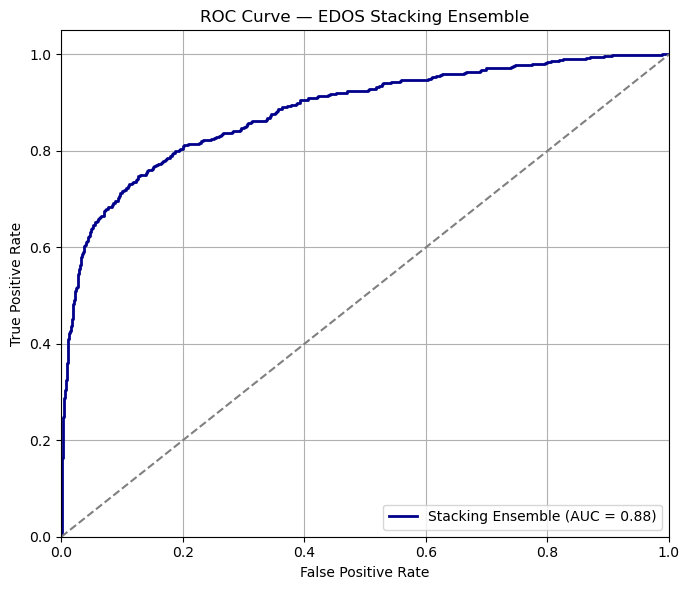

In [436]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

xgb_probs = np.load("edos_xgb_probs.npy")        
glove_probs = np.load("edos_glove_probs.npy")    
bert_probs = np.load("edos_bert_probs.npy")      
y_true = np.load("edos_y_true.npy")              

assert set(np.unique(y_true)) <= {0, 1}, "Only for binary classification."
y_true_bin = label_binarize(y_true, classes=[0, 1])  

X_meta = np.hstack([xgb_probs, glove_probs, bert_probs]) 

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_meta, y_true)
y_pred_probs = meta_clf.predict_proba(X_meta)

if y_pred_probs.shape[1] == 2:
    positive_probs = y_pred_probs[:, 1]
else:
    positive_probs = np.zeros_like(y_true, dtype=float)

fpr, tpr, _ = roc_curve(y_true, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Stacking Ensemble (AUC = {roc_auc:.2f})", color="darkblue", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — EDOS Stacking Ensemble")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [432]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_df = pd.read_csv("./splits/edos_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

#TF-IDF + XGB
xgb = joblib.load("./models/edos_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
np.save("edos_xgb_probs.npy", xgb_probs)

#GloVe + CNN
glove_model = load_model("./models/edos_glove_cnn.h5")
tokenizer = joblib.load("./models/edos_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)
np.save("edos_glove_probs.npy", glove_probs)

#BERT + CNN
bert_model = load_model("./models/edos_bert_cnn.h5")
bert_X = np.load("./models/edos_bert_embed_test_seq.npy")  
bert_probs = bert_model.predict(bert_X)
np.save("edos_bert_probs.npy", bert_probs)


np.save("edos_y_true.npy", y_true)

print(" Saved all required .npy files for EDOS stacking ensemble.")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 Saved all required .npy files for EDOS stacking ensemble.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


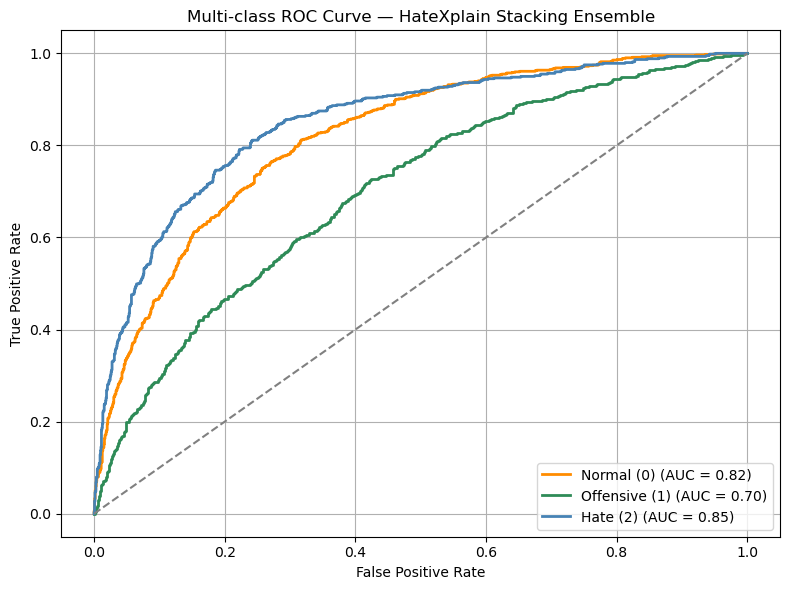

In [442]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

xgb_probs = np.load("hatexplain_xgb_probs.npy")      
glove_probs = np.load("hatexplain_glove_probs.npy") 
bert_probs = np.load("hatexplain_bert_probs.npy")   
y_true = np.load("hatexplain_y_true.npy")           

classes = [0, 1, 2]
y_true_bin = label_binarize(y_true, classes=classes)  

X_meta = np.hstack([xgb_probs, glove_probs, bert_probs])  

meta_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_clf.fit(X_meta, y_true)
y_pred_probs = meta_clf.predict_proba(X_meta)  

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'seagreen', 'steelblue']
labels = ["Normal (0)", "Offensive (1)", "Hate (2)"]
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve — HateXplain Stacking Ensemble')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [440]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_df = pd.read_csv("./splits/hatexplain_test.csv")
texts = test_df["clean_text"].astype(str).tolist()
y_true = test_df["label"].astype(int).values

#TF-IDF + XGB
xgb = joblib.load("./models/hatexplain_xgb.joblib")
xgb_probs = xgb.predict_proba(texts)
np.save("hatexplain_xgb_probs.npy", xgb_probs)

#GloVe + BiLSTM 
glove_model = load_model("./models/hatexplain_glove_bilstm.h5")
tokenizer = joblib.load("./models/hatexplain_glove_tokenizer.joblib")
glove_X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100)
glove_probs = glove_model.predict(glove_X)
np.save("hatexplain_glove_probs.npy", glove_probs)

#BERT + BiLSTM 
bert_model = load_model("./models/hatexplain_bert_bilstm_best.h5")
bert_X = np.load("./models/hatexplain_bert_embed_test.npy")
bert_probs = bert_model.predict(bert_X)
np.save("hatexplain_bert_probs.npy", bert_probs)


np.save("hatexplain_y_true.npy", y_true)

print("All model outputs and labels saved as .npy files.")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
All model outputs and labels saved as .npy files.
